In [4]:
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import math
import json
from nltk import tokenize
import collections
import re
import itertools
import nltk
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel,\
        GenericLikelihoodModelResults

from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.special import zeta
from scipy.stats import binom

import pickle
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

lg = np.log10

In [1612]:
test = pd.read_csv (r'data/webtext.test.csv')
test = test.dropna()
test = test['text'].tolist()

In [213]:
train = pd.read_csv (r'data/webtext.train.csv')

In [2]:
web_train = pd.read_csv (r'data/webtext.train.csv')
web_train = web_train.loc[web_train['length']>= 1000]
web_train = web_train.dropna()
web_train = web_train['text'].tolist()

In [753]:
len(web_train)

71210

In [755]:
web_train_large = web_train[:20000]

In [1561]:
web_train_20000 = pickle.load(open("web_train_20000.p", "rb" ))

In [758]:
gpt_train_large = gpt_train[:20000]

In [5]:
gpt_train_20000 = pickle.load(open("gpt_train_20000.p", "rb" ))

In [ ]:
web_train_pos_1 = pickle.load(open("web_1000_pos_1.p", "rb" ))

In [ ]:
web_train_pos_2 = pickle.load(open("web_1000_pos_2.p", "rb" ))

In [3]:
# web_train_1000 = web_train[:1000]

In [212]:
# web_train_1000_2 = web_train[1000:2000]

In [8]:
# web_train_pos = [make_file(text, multi=False, pos=True) for text in web_train_1000]

In [213]:
# web_train_pos_2 = [make_file(text, multi=False, pos=True) for text in web_train_1000_2]

In [10]:
gpt_train = pd.read_csv (r'data/small-117M-k40.train.csv')
gpt_train = gpt_train.loc[gpt_train['length']>= 1000]
gpt_train = gpt_train.dropna()
gpt_train = gpt_train['text'].tolist()

In [1809]:
gpt_train_medium = pd.read_csv (r'data/medium-345M-k40.train.csv')
gpt_train_medium = gpt_train_medium.loc[gpt_train_medium['length']>= 1000]
gpt_train_medium = gpt_train_medium.dropna()
gpt_train_medium = gpt_train_medium['text'].tolist()

In [1810]:
gpt_train_large = pd.read_csv (r'data/large-762M-k40.train.csv')
gpt_train_large = gpt_train_large.loc[gpt_train_large['length']>= 1000]
gpt_train_large = gpt_train_large.dropna()
gpt_train_large = gpt_train_large['text'].tolist()

In [1821]:
gpt_train_xl = pd.read_csv (r'data/xl-1542M-k40.train.csv')
gpt_train_xl = gpt_train_xl.loc[gpt_train_xl['length']>= 1000]
gpt_train_xl = gpt_train_xl.dropna()
gpt_train_xl = gpt_train_xl['text'].tolist()

In [1817]:
gpt_train_medium_20000 = [make_file(corpus, multi=False, pos=True) for corpus in gpt_train_medium[:20000]]

In [1818]:
gpt_train_large_20000 = [make_file(corpus, multi=False, pos=True) for corpus in gpt_train_large[:20000]]

In [1822]:
gpt_train_xl_20000 = [make_file(corpus, multi=False, pos=True) for corpus in gpt_train_xl[:20000]]

In [1819]:
pickle.dump(gpt_train_medium_20000, open( "gpt_train_medium_20000.p", "wb" ))

In [1820]:
pickle.dump(gpt_train_large_20000, open( "gpt_train_large_20000.p", "wb" ))

In [1823]:
pickle.dump(gpt_train_xl_20000, open( "gpt_train_xl_20000.p", "wb" ))

In [282]:
gpt_train_pos_1 = pickle.load(open("gpt_1000_pos_1.p", "rb" ))

In [283]:
gpt_train_pos_2 = pickle.load(open("gpt_1000_pos_2.p", "rb" ))

## Data processing

In [1812]:
# Pre-processing without part of speech tags
def remove_punctuation(text):
    text = text.lower()
    chars_to_remove = "[\n]!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    tr = str.maketrans(" ", " ", chars_to_remove)
    return text.translate(tr)


def preprocess(corpus, sent = True):
    if sent:
        corpus = tokenize.sent_tokenize(corpus)
        corpus = [remove_punctuation(sent).split() for sent in corpus]
    else:
        corpus = remove_punctuation(corpus).split()
    return corpus

In [1813]:
# Pre-processing with part of speech tags
def part_of_speech(corpus):
    corpus = tokenize.sent_tokenize(corpus)
    chars_to_remove = "[\n]"
    tr = str.maketrans(" ", " ", chars_to_remove)
    chars_to_remove2 = "[\n]!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    new_corp = []
    test = []

    for sent in corpus:
        sent = sent.translate(tr)
        words_sent = tokenize.word_tokenize(sent)
        sent_pos = nltk.pos_tag(words_sent)
        new_sent = []
        for (word, pos) in sent_pos:
            tr2 = str.maketrans("", "", chars_to_remove2)
            word = word.translate(tr2)
            if word:
                new_sent.append((word.lower(), pos))
        new_corp.append(new_sent)
    return new_corp

In [1814]:
# Total preprocessing function for a corpus. Input can be one string (corpus),
# for which you put multi = False, or a list of several strings (corpora) that 
# you want to turn into one big corpus, for which you put multi = True.
# For PoS tags, put pos = True.
def make_file(corp, multi = True, sent = True, pos = False):
    if multi:
        corpus = ''
        for subcorp in corp:
            corpus += subcorp
    else:
        corpus = corp
        
    if pos:
        corpus = part_of_speech(corpus)
    
    else:
        corpus = preprocess(corpus, sent = sent)
    
    return corpus

## Webtext test files

In [79]:
real_test = pd.read_csv (r'data/webtext.test.csv')
real_test = real_test.dropna()
real_test = real_test['text'].tolist()

In [356]:
real_test_1 = pickle.load(open("real_test_1.p", "rb" ))

In [357]:
real_test_2 = pickle.load(open("real_test_2.p", "rb" ))

In [52]:
real_test_3 = pickle.load(open("real_test_3.p", "rb" ))

In [53]:
real_test_4 = pickle.load(open("real_test_4.p", "rb" ))

In [54]:
real_test_5 = pickle.load(open("real_test_5.p", "rb" ))

## GPT test files

In [90]:
k40_test = pd.read_csv (r'data/small-117M-k40.test.csv')
k40_test = k40_test.dropna()
k40_test = k40_test['text'].tolist()

In [358]:
k40_test_1 = pickle.load(open("k40_test_1.p", "rb" ))

In [359]:
k40_test_2 = pickle.load(open("k40_test_2.p", "rb" ))

In [57]:
k40_test_3 = pickle.load(open("k40_test_3.p", "rb" ))

In [58]:
k40_test_4 = pickle.load(open("k40_test_4.p", "rb" ))

In [59]:
k40_test_5 = pickle.load(open("k40_test_5.p", "rb" ))

## Creating the data

### Webtext

In [102]:
gpt_real = pd.read_csv (r'data/webtext.train.csv')
gpt_real = gpt_real.dropna()
gpt_real = gpt_real['text'].tolist()

In [ ]:
# real_file = make_file(gpt_real[:50000])

In [43]:
# real_2 = make_file(gpt_real[50000:100000])

In [ ]:
# real_3 = make_file(gpt_real[100000:150000])

In [ ]:
# real_4 = make_file(gpt_real[150000:200000])

In [ ]:
# real_5 = make_file(gpt_real[200000:250000])

In [162]:
real_pos_1 = pickle.load(open("real_pos_1.p", "rb" ))

In [3]:
real_pos_2 = pickle.load(open("real_pos_2.p", "rb" ))

In [4]:
real_pos_3 = pickle.load(open("real_pos_3.p", "rb" ))

In [5]:
real_pos_4 = pickle.load(open("real_pos_4.p", "rb" ))

In [5]:
real_pos_5 = pickle.load(open("real_pos_5.p", "rb" ))

In [132]:
# pickle.dump(real_pos_5, open( "real_pos_5.p", "wb" ))

### GPT Small K40

In [43]:
gpt_small_k40 = pd.read_csv (r'data/small-117M-k40.train.csv')
gpt_small_k40 = gpt_small_k40.dropna()
gpt_small_k40 = gpt_small_k40['text'].tolist()

In [97]:
gpt_small_k40_pos_1 = pickle.load(open("gpt_small_k40_pos_1.p", "rb"))

In [98]:
gpt_small_k40_pos_2 = pickle.load(open("gpt_small_k40_pos_2.p", "rb"))

In [9]:
gpt_small_k40_pos_3 = pickle.load(open("gpt_small_k40_pos_3.p", "rb"))

In [6]:
gpt_small_k40_pos_4 = pickle.load(open("gpt_small_k40_pos_4.p", "rb"))

In [731]:
# k40_5 = make_file(gpt_small_k40[200000:250000], pos = True)

In [732]:
# pickle.dump(k40_5, open("gpt_small_k40_pos_5.p", "wb"))

In [733]:
# gpt_small_k40_pos_5 = pickle.load(open("gpt_small_k40_pos_5.p", "rb"))

### GPT Small Temperature

In [27]:
# gpt_small_temp = pd.read_csv (r'data/small-117M.train.csv')
# gpt_small_temp = gpt_small_temp.dropna()
# gpt_small_temp = gpt_small_temp['text']

In [ ]:
# gpt_small_temp_1 = make_file(gpt_small_temp[0:50000].tolist())

### Subsampling

In [7]:
# Returns 2 lists of corpora, one from which the ranks will be calculated
# and one from which the frequencies will be calculated. Each corpus consists of
# a list of tokenized sentences.
# Input: corpus that is to be subsampled. Should be a list of tokenized sentences.
# k is the amount of tokens that each sampled corpus should contain,
# m is the amount of subcorpera you want for both the ranks and frequencies.
# Max: I would read Valentin's thesis for an explanation on subsampling
def subsampling(corpus, k = 1000000, m = 10, sent = True):
    n = len(corpus)
    
    sen_len = {}

    
    rank_corpera = []
    freq_corpera = []

    if sent:
        for i in range(m):
            used_rank = set()
            used_freq = set()
            rank_count = 0
            freq_count = 0
            rank_samples = []
            freq_samples = []

            while rank_count < k:
                index = np.random.randint(n)
                if index in used_rank:
                    continue

                rank_sample = corpus[index]
                len_sample = len(rank_sample)

                if len_sample == 0:
                    continue

                rank_samples += rank_sample
                rank_count += len_sample

                if len_sample not in sen_len and len_sample < 200:
                    sen_len[len_sample] = 1
                elif len_sample < 200:
                    sen_len[len_sample] += 1


                used_rank.add(index)

            while freq_count < k:
                index = np.random.randint(n)
                if index in used_freq:
                    continue
                freq_sample = corpus[index]
                len_sample = len(freq_sample)

                if len_sample == 0:
                    continue

                freq_samples += freq_sample
                freq_count += len_sample

                if len_sample not in sen_len and len_sample < 200:
                    sen_len[len_sample] = 1
                elif len_sample < 200:
                    sen_len[len_sample] += 1

                used_freq.add(index)

            rank_corpera.append(rank_samples)
            freq_corpera.append(freq_samples)
#                 rank_corpera.append([item for sublist in rank_samples for item in sublist])
#                 freq_corpera.append([item for sublist in freq_samples for item in sublist])


    else:
        for i in range(m):
            rank_samples = random.sample(corpus, k)
            freq_samples = random.sample(corpus, k)
            rank_corpera.append(rank_samples)
            freq_corpera.append(freq_samples)
    
#     return rank_corpera, freq_corpera, sen_len
    return rank_corpera, freq_corpera

### Calculating the frequencies

In [503]:
# Returns a dataframe of word frequencies for list of corpora,
# with each column corresponding to a different corpus.
# Input: list of corpora. Each corpus consists of a list of tokenized sentences.
def calculate_freqs(freq_sents, norm=True, text=None):
    freq_dict = {}
    norm_dict = {}
    for i, corpus in enumerate(freq_sents):
        freq_dict['{} c_frequency {}'.format(text,i)] = collections.Counter(corpus)
        if norm:
            len_corp = len(corpus)
            norm_dict['{} c_frequency {}'.format(text, i)] = {k: v / len_corp for k, v in freq_dict['{} c_frequency {}'.format(text,i)].items()}
    
    if norm:
        freqs_df = pd.DataFrame(norm_dict)
    else:
        freqs_df = pd.DataFrame(freq_dict)
    freqs_df = freqs_df.fillna(0)
    
    
    return freqs_df

In [192]:
# Returns a dataframe with the mean frequency of each word across different corpora.
# Input: frequency dataframe
def mean_freqs(freqs_df):
    return(freqs_df.mean(axis=1))

### Calculating the ranks

In [188]:
# Returns a dataframe of word ranks for list of corpora,
# with each column corresponding to a different corpus.
# Input: list of corpora. Each corpus consists of a list of tokenized sentences.
def calculate_ranks(rank_sents, norm=False, text=None):
    ranks_dicts = {}
    for i, corpus in enumerate(rank_sents):
        freqs = collections.Counter(corpus)
        if norm:
            len_corp = len(corpus)
            for key in freqs:
                freqs[key] /= len_corp
        ranks_dicts['{} c_rank {}'.format(text, i)] = {w: r for r, (w, c) in enumerate(freqs.most_common(), 1)}
    
    ranks_df = pd.DataFrame(ranks_dicts)
    for column in ranks_df:
        min_rank = int(np.ceil(ranks_df[column].max() + 1))
        nan_rows = ranks_df[ranks_df[column].isnull()]
        num_nans = len(nan_rows)
        nan_ranks = list(range(min_rank, min_rank+num_nans))
        random.shuffle(nan_ranks)
        ranks_df.loc[ranks_df[column].isnull(), column] = nan_ranks

    return ranks_df

In [178]:
# Returns a dataframe with the mean rank of each word across different corpora.
# Input: rank dataframe
def mean_ranks(ranks_df):
    return ranks_df.mean(axis=1)

In [505]:
# Creates combined dataframe of ranks and frequencies
# Input: 2 lists (freq_sents and rank_sents) of corpora. Each corpus
# consists of a list of tokenized sentences. These lists are to be obtained form
# subsampling.
def ranks_freqs(freq_sents, rank_sents, text=None, norm=False):
    freqs_df = calculate_freqs(freq_sents, text=text, norm=norm)
    freqs_df['Frequency'] = mean_freqs(freqs_df)
    ranks_df = calculate_ranks(rank_sents, text=text, norm=norm)
    ranks_df['Rank'] = mean_ranks(ranks_df)
    
    # Put mean ranks and freqs together and remove all words that
    # do not have both a rank and frequency (which happens when a word)
    # is only present in freq_sents and not in rank_sents or vice versa
    ranks_freqs_df = pd.concat([ranks_df, freqs_df], axis = 1)
    ranks_freqs_df = ranks_freqs_df.dropna()
#     ranks_freqs_df = ranks_freqs_df.loc[ranks_freqs_df['Frequency'] >=1]
    return ranks_freqs_df

In [13]:
def freq_of_freqs_hist_plot(freqs):
    freq_of_freqs = collections.Counter(freqs)
    plt.bar(list(freq_of_freqs.keys()), freq_of_freqs.values(), color='b')
    plt.show()
    return None

In [14]:
def freq_of_freqs_hexbin_plot(freqs):
    freq_of_freqs = collections.Counter(freqs)
    hexbin_plot(list(freq_of_freqs.keys()), freq_of_freqs.values())
    plt.show()
    return None

## Fano factor

In [15]:
def fano_factor(ranks_freqs_df, ylim = None):
    fano = []

    for index, row in ranks_freqs_df.iterrows():
        fano.append((np.cov(row[0:10], row[11:21])[0][1])/row['Rank'])
    ranks_freqs_df['Fano'] = fano
#     fano_plot(ranks_freqs_df, ylim=ylim)
    return ranks_freqs_df

### Estimating Zipf's law

We estimate Zipf's law using $f(w) \propto \frac{1}{r(w)^{\alpha}}$. In the following code block, the $\alpha$ is found using maximum likelihood estimation, for which the code was taken from https://stats.stackexchange.com/questions/6780/how-to-calculate-zipfs-law-coefficient-from-a-set-of-top-frequencies .

In [16]:
# MLE of Zipf's law parameters (alpha and beta)
class Mandelbrot(GenericLikelihoodModel):

    def __init__(self, frequencies, ranks, **kwargs):
        if not len(frequencies) == len(ranks):
            raise ValueError("NOT THE SAME NUMBER OF RANKS AND FREQS!")
        
        frequencies = np.asarray(frequencies)
        ranks = np.asarray(ranks)
        
        self.n_obs = np.sum(frequencies)
        
        super().__init__(endog=frequencies, exog=ranks, **kwargs)
        self.fit_result = None
    

    def prob(self, params, ranks=None, log=False):
        if ranks is None:
            ranks = self.exog
        
        alpha, beta = params
        if log:
            return -alpha*lg(beta+ranks) - lg(zeta(alpha, q=beta+1.))
        else:
            return ((beta + ranks)**(-alpha))/zeta(alpha, q=beta+1.)
    
    
    def loglike(self, params):
        rs = self.exog
        fs = self.endog
        alpha, beta = params
        
#        if alpha > 10 or beta > 20:
#            return -np.inf
        
#         if alpha < 1.0 or beta < 0.0:
#             return -np.inf
        
        # no need to calculate P(r) when observed f(r) was zero
        log_probs = -alpha*lg(beta+rs) - lg(zeta(alpha, q=beta+1.))
        log_probs = log_probs.reshape(-1, )
        return np.sum(fs * log_probs) - beta**5
    
    
    def register_fit(self, fit_result, overwrite=False):
        if not self.fit_result is None and not overwrite:
            raise ValueError("A fit result is already registered and overwrite=False!")
            
        self.fit_result = fit_result
        self.optim_params = fit_result.params
        self.pseudo_r_squared = self.pseudo_r_squared(self.optim_params)
        self.SE, self.SE_relative = fit_result.bse, fit_result.bse/self.optim_params
        self.BIC, self.BIC_relative = fit_result.bic,\
                            (-2*self.null_loglike())/fit_result.bic
        
        return self.optim_params
    
    def print_result(self, string=False):
        if self.fit_result is None:
            raise ValueError("Register a fitting result first!")

        def format_x(x):
            return float('{0:.3g}'.format(x))


        s = "="*50
        s += "\n" + "MANDELBROT"
        s += "\n" + "  Optimal Parameters " + str(tuple(map(format_x, self.optim_params)))
        
        s += "\n" + "  Standard Error [relative]: " + str(tuple(map(format_x, self.SE))) +\
              ", [" + str(tuple(map(format_x, self.SE_relative))) + "]"
        
        s += "\n" + "  Pseudo R^2: " + str(format_x(self.pseudo_r_squared))
        
        s += "\n" + "  BIC [relative]: " + str(format_x(self.BIC)) +\
              ", [" + str(format_x(self.BIC_relative)) + "]"
        s += "\n" + "="*50
        
        if string:
            return s
        
        print(s)
    
    
    def null_loglike(self, epsilon=1e-10):
        return self.loglike((1.+epsilon, 0.0))
    
    def pseudo_r_squared(self, params):
        return 1-self.loglike(params)/self.null_loglike()
    
    
    def predict(self, params, ranks=None, freqs=True, n_obs=None, 
                correct_for_finite_domain=True):
        if ranks is None:
            ranks = self.exog
        ranks = np.asarray(ranks)
        
        if n_obs is None:
            n_obs = self.n_obs
            
        alpha, beta = params
        pred_probs = self.prob(params, ranks=ranks, log=False)
        
        if correct_for_finite_domain:
            if not freqs:
                raise NotImplementedError("Correction for "\
                                          "finite domain not implemented with probabilities!")
            return pred_probs*(n_obs/np.sum(pred_probs))
        
        if freqs:
            return n_obs*pred_probs
        
        return pred_probs



In [136]:
# Returns a dataframe containing the mean frequencies and ranks, as well as 
# the estimated frequencies from Zipf's law and the error between the (log) mean
# frequencies and (log) estimated frequencies.
def zipfs_law(df, print_stats = True):
    mandelbrot = Mandelbrot(df['Frequency'], df['Rank'])
    mandelbrot_fit = mandelbrot.fit(start_params=np.asarray([1.0, 1.0]), # [1.0, 1.0]
                                method="powell", full_output=True, disp=0)
    mandelbrot.register_fit(mandelbrot_fit)
    if print_stats:
        mandelbrot.print_result()
    
    model_params = mandelbrot.optim_params
    alpha, beta =  mandelbrot.optim_params
    preds = mandelbrot.predict(model_params, df['Rank'])

    df['Estimated frequency'] = preds
    return df

## Voor Max:
Om van een corpus (= een lijst van tokenized zinnen) een dataframe met Zipf's law te krijgen moet je dit runnen (geeft zo natuurlijk errors dus moet je nog invullen):

In [379]:
# 'corpus' is dus een lijst van tokenized zinnen. k en m kan je zelf invullen of 
# default gebruiken.
rank_corpora, freq_corpora = subsampling(corpus, k=?, m=?)
ranks_freqs_df = ranks_freqs(rank_corpora, freq_corpora)
# Hieruit krijg je dus een dataframe met voor elk woord de rank, frequency,
# estimated frequency volgens Zipf's law en de error.
zipf_df = zipfs_law(ranks_freqs_df)

# Plotting (code from Valentin's thesis)

In [18]:
def get_lims(xs, ys, log=False, equal_aspect=False):
    lows = min(xs), min(ys)
    highs = max(xs), max(ys)
    
    if log:
        c_low, c_high = (lambda x: x*0.5), (lambda x: x*1.5)   
    else:
        c_low, c_high = (lambda x: x*0.6), (lambda x: x*1.05)   
    
    if log:
        lows = tuple(max(10**-10, l) for l in lows)
    
    if equal_aspect:
        lims = (c_low(min(lows)),)*2, (c_high(max(highs)),)*2
        return list(zip(*lims))
    
    return (c_low(lows[0]), c_high(highs[0])),\
                (c_low(lows[1]), c_high(highs[1]))

In [19]:
def remove_zeros(x_vals, y_vals):
    return list(zip(*[(x, y) for x, y in zip(x_vals, y_vals) 
                      if x > 0 and y > 0]))

In [20]:
def fano_plot(ranks_freqs_df, ylim = None, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    ranks_freqs_filt = ranks_freqs_df.loc[(ranks_freqs_df['Fano'] >= -5) & (ranks_freqs_df['Fano'] <= 5)]
    xs = ranks_freqs_filt['Rank']
    ys = ranks_freqs_filt['Fano']
    
    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
#     plt.xlim(lims_x)
#     plt.ylim(lims_y)
    if ylim:
        plt.ylim(ylim)
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
    
        
    return lims

In [21]:
def type_plot(df, word_type, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    xs = df['Rank']
    ys = df['Frequency']
    est = df['Estimated frequency']
    
    if min_y is not None:
        xs, ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if y >= min_y]))
    
    if not lims:
        lims = get_lims(xs, ys, log=log)
    
    
    if ignore_zeros:
        xs, ys = remove_zeros(xs, ys)

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log", yscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    type_df = df.query('ilevel_1 == @word_type')
    params2 = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                linewidths=0.2)
    hb2 = plt.hexbin(type_df['Rank'], type_df['Frequency'], **params2)
    
    lims_x, lims_y = lims
    plt.xlim(lims_x)
    plt.ylim(lims_y)
    
    if cbar:
        plt.gcf().colorbar(hb)
        plt.gcf().colorbar(hb2)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
        
    plt.plot(xs, est, color='r', linestyle="--")
        
    return lims

In [22]:
def hexbin_plot(xs, ys, est=None, word_type=None, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    
    
    if min_y is not None:
        xs, ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if y >= min_y]))
    
    if not lims:
        lims = get_lims(xs, ys, log=log)
    
    
    if ignore_zeros:
        xs, ys = remove_zeros(xs, ys)

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log", yscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if word_type:
        type_df = df.query('ilevel_1 == @word_type')
        params2 = dict(color = 'red', gridsize=75, mincnt=1,
                  linewidths=0.2)
        plt.hexbin(type_df['Rank'], type_df['Frequency'], **params2)
    
    lims_x, lims_y = lims
    plt.xlim(lims_x)
    plt.ylim(lims_y)
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
        
    if est is not None:
        plt.plot(xs, est, color='r', linestyle="--")
        
    return lims

In [23]:
def hexbin_error(xs, ys, xlbl=None, ylbl=None,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    

    # cmap='cividis'
    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)

    plt.ticklabel_format(style="sci", axis="both", 
                            scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
    
    plt.ylim([-2,2])
        
    plt.axhline(linewidth=1.5, color='r', linestyle="--")
        
    return None

In [24]:
def plot_type_zipf(df, word_type):
    type_df = df.query('ilevel_1 == @word_type')
    zipf_type = zipfs_law(type_df)
    plt.title("{}".format(word_type))
    hexbin_plot(zipf_type['Rank'], zipf_type['Frequency'], zipf_type['Estimated frequency'])
    plt.show()
    hexbin_error(zipf_type['Rank (log)'], zipf_type['Error'])
    plt.show()
    
    return zipf_type

In [25]:
def plot_zipf(ranks_freqs_df):
    ranks_freqs_df = ranks_freqs_df.sort_values(by=['Rank'])
    zipf_df = zipfs_law(ranks_freqs_df)
#     ranks_freqs_df = ranks_freqs_df.loc[ranks_freqs_df['Frequency'] >=1]
#     hexbin_plot(ranks_freqs_df['Rank'], ranks_freqs_df['Frequency'], est = ranks_freqs_df['Estimated frequency'])
#     plt.show()
#     hexbin_error(zipf_df['Rank (log)'], zipf_df['Error'])
#     plt.show()
    
    return zipf_df

# PoS

In [196]:
df_real_1 = pickle.load(open('df_real_1.pkl', 'rb'))
df_real_2 = pickle.load(open('df_real_2.pkl', 'rb'))
df_real_3 = pickle.load(open('df_real_3.pkl', 'rb'))
df_real_4 = pickle.load(open('df_real_4.pkl', 'rb'))
df_real_5 = pickle.load(open('df_real_5.pkl', 'rb'))

In [197]:
df_k40_1 = pickle.load(open('df_k40_1.pkl', 'rb'))
df_k40_2 = pickle.load(open('df_k40_2.pkl', 'rb'))
df_k40_3 = pickle.load(open('df_k40_3.pkl', 'rb'))
df_k40_4 = pickle.load(open('df_k40_4.pkl', 'rb'))
df_k40_5 = pickle.load(open('df_k40_5.pkl', 'rb'))

In [31]:
real_dfs = [df_real_1, df_real_2, df_real_3, df_real_4]
k40_dfs = [df_k40_1, df_k40_2, df_k40_3, df_k40_4]

In [26]:
df_real_1.index.unique(level=1)

Index(['DT', 'TO', 'IN', 'CC', 'VBZ', 'PRP', 'VBD', 'VBP', 'VB', 'RB', 'PRP$',
       'WDT', 'MD', 'WP', 'CD', 'WRB', 'VBN', 'EX', 'JJ', 'NNS', 'NN', 'RP',
       'JJR', 'RBR', 'VBG', 'NNP', 'RBS', 'JJS', 'PDT', 'NNPS', 'WP$', 'UH',
       'FW', 'LS', '$', 'SYM', 'POS', ''''],
      dtype='object')

OPEN<br>
NN = noun, common, singular or mass<br>
NNS = noun, common, plural<br>
NNP = noun, proper, singular<br><br>

VBD = verb, past tense<br>
VBP = verb, present tense, not 3rd person singular<br>
VBG = verb, present participle or gerund<br>
VB = verb, base form<br>
VBZ = verb, present tense, 3rd person singular <br>
VBN = verb, past participle<br><br>

JJ = adjective or numeral, ordinal<br>
JJR = adjective, comparative<br>
JJS = adjective, superlative<br><br>

RB: adverb<br>
RBR: adverb, comparative<br>
RBS: adverb, superlative<br><br>

CLOSED <br>
DT = determiner <br>
TO = to
IN = preposition or conjunction
CC = numeral, cardinal
VBZ = verb, present tense, 3rd person singular
PRP = pronoun, personal
RB = particle
PRP$ = pronoun, possessive
WDT = WH-determiner
MD = modal auxiliary
WP = WH-pronoun


In [46]:
# nouns_real_1 = df_real_1.query("ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'")
real_noun_dfs = [df.query("ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'") for df in real_dfs]
real_not_noun_dfs = [df.query("ilevel_1 != 'NN' and ilevel_1 != 'NNS' and ilevel_1 != 'NNP'") for df in real_dfs]

real_verb_dfs = [df.query("ilevel_1 == 'VB' or ilevel_1 == 'VBD' or ilevel_1 == 'VBG' or ilevel_1 == 'VBN' or ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'") for df in real_dfs]
real_not_verb_dfs = [df.query("ilevel_1 != 'VB' and ilevel_1 != 'VBD' and ilevel_1 != 'VBG' and ilevel_1 != 'VBN' and ilevel_1 != 'VBP' and ilevel_1 != 'VBZ'") for df in real_dfs]

real_adj_dfs = [df.query("ilevel_1 == 'JJ' or ilevel_1 == 'JJR' or ilevel_1 == 'JJS'") for df in real_dfs]
real_not_adj_dfs = [df.query("ilevel_1 != 'JJ' and ilevel_1 != 'JJR' and ilevel_1 != 'JJS'") for df in real_dfs]

real_adv_dfs = [df.query("ilevel_1 == 'RB' or ilevel_1 == 'RBR' or ilevel_1 == 'RBS'") for df in real_dfs]
real_not_adv_dfs = [df.query("ilevel_1 != 'RB' and ilevel_1 != 'RBR' and ilevel_1 != 'RBS'") for df in real_dfs]


k40_noun_dfs = [df.query("ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'") for df in k40_dfs]
k40_not_noun_dfs = [df.query("ilevel_1 != 'NN' and ilevel_1 != 'NNS' and ilevel_1 != 'NNP'") for df in k40_dfs]

k40_verb_dfs = [df.query("ilevel_1 == 'VB' or ilevel_1 == 'VBD' or ilevel_1 == 'VBG' or ilevel_1 == 'VBN' or ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'") for df in k40_dfs]
k40_not_verb_dfs = [df.query("ilevel_1 != 'VB' and ilevel_1 != 'VBD' and ilevel_1 != 'VBG' and ilevel_1 != 'VBN' and ilevel_1 != 'VBP' and ilevel_1 != 'VBZ'") for df in k40_dfs]

k40_adj_dfs = [df.query("ilevel_1 == 'JJ' or ilevel_1 == 'JJR' or ilevel_1 == 'JJS'") for df in k40_dfs]
k40_not_adj_dfs = [df.query("ilevel_1 != 'JJ' and ilevel_1 != 'JJR' and ilevel_1 != 'JJS'") for df in k40_dfs]

k40_adv_dfs = [df.query("ilevel_1 == 'RB' or ilevel_1 == 'RBR' or ilevel_1 == 'RBS'") for df in k40_dfs]
k40_not_adv_dfs = [df.query("ilevel_1 != 'RB' and ilevel_1 != 'RBR' and ilevel_1 != 'RBS'") for df in k40_dfs]


real_types_df = [real_noun_dfs, real_verb_dfs, real_adj_dfs, real_adv_dfs]
real_not_types_df = [real_not_noun_dfs, real_not_verb_dfs, real_not_adj_dfs, real_not_adv_dfs]

k40_types_df = [k40_noun_dfs, k40_verb_dfs, k40_adj_dfs, k40_adv_dfs]
k40_not_types_df = [k40_not_noun_dfs, k40_not_verb_dfs, k40_not_adj_dfs, k40_not_adv_dfs]

titles = ["Nouns", "Verbs", "Adjectives", "Adverbs"]
saves = ["nouns_", "verbs_", "adjectives_", "adverbs_"]

In [65]:
for i, query in enumerate(queries1):
    for j, real in enumerate(real_dfs):
        type_df = real.query(query)
        rest_df = real.query(queries2[i])
        hexbin_plot(rest_df['Rank'], rest_df['Frequency'], est=rest_df['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", cbar=False)

        hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=True, label = titles[i])
        plt.title("{} in Real Text {}".format(titles[i], j+1))
        plt.legend()
        plt.savefig(saves[i] + "real_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()
        
        hexbin_error(type_df['Rank (log)'], type_df['Error'])
        plt.title("Error of {} in Real Text {}".format(titles[i], j+1))
        plt.savefig(saves[i] + "error_real_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()

In [67]:
for i, query in enumerate(queries1):
    for j, real in enumerate(k40_dfs):
        type_df = real.query(query)
        rest_df = real.query(queries2[i])
        hexbin_plot(rest_df['Rank'], rest_df['Frequency'], est=rest_df['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", cbar=False)

        hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=True, label = titles[i])
        plt.title("{} in GPT Text {}".format(titles[i], j+1))
        plt.legend()
        plt.savefig(saves[i] + "k40_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()
        
        hexbin_error(type_df['Rank (log)'], type_df['Error'])
        plt.title("Error of {} in GPT Text {}".format(titles[i], j+1))
        plt.savefig(saves[i] + "error_k40_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()

In [58]:
queries1 = ["ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'", 
            "ilevel_1 == 'VB' or ilevel_1 == 'VBD' or ilevel_1 == 'VBG' or ilevel_1 == 'VBN' or ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'",
           "ilevel_1 == 'JJ' or ilevel_1 == 'JJR' or ilevel_1 == 'JJS'", 
           "ilevel_1 == 'RB' or ilevel_1 == 'RBR' or ilevel_1 == 'RBS'"]

queries2 = ["ilevel_1 != 'NN' and ilevel_1 != 'NNS' and ilevel_1 != 'NNP'", 
            "ilevel_1 != 'VB' and ilevel_1 != 'VBD' and ilevel_1 != 'VBG' and ilevel_1 != 'VBN' and ilevel_1 != 'VBP' and ilevel_1 != 'VBZ'",
           "ilevel_1 != 'JJ' and ilevel_1 != 'JJR' and ilevel_1 != 'JJS'", 
           "ilevel_1 != 'RB' and ilevel_1 != 'RBR' and ilevel_1 != 'RBS'"]

titles = ["Nouns", "Verbs", "Adjectives", "Adverbs"]
saves = ["nouns_", "verbs_", "adjectives_", "adverbs_"]

In [37]:
# queries1 = ["ilevel_1 == 'NN' or ilevel_1 == 'NNS'", 
#             "ilevel_1 == 'NNP'", "ilevel_1 == 'VB'", "ilevel_1 == 'VBD'", 
#             "ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'", ]

# queries2 = ["ilevel_1 != 'NN' and ilevel_1 != 'NNS'", 
#             "ilevel_1 != 'NNP'", "ilevel_1 != 'VB'", "ilevel_1 != 'VBD'",
#            "ilevel_1 != 'VBP'"]

# titles = ["Common Nouns", "Proper Nouns", "Verbs Base Form", "Verbs Past Tense",
#          "Verbs Present Tense"]

# saves = ["common_nouns_", "proper_nouns_", "verbs_base_", "verbs_past_",
#         "verbs_present_"]

# # queries1 = ["ilevel_1 == 'VBD'"]
# # queries2 = ["ilevel_1 != 'VBD'"]
# # titles = ["Verbs Past Tense"]
# # saves = ["verb_past_real_"]

In [60]:
for i, query in enumerate(queries1):
    for j, real in enumerate(real_dfs):
        type_df = real.query(query)
        rest_df = real.query(queries2[i])
        hexbin_plot(rest_df['Rank'], rest_df['Frequency'], est=rest_df['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", cbar=False)

        hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=True, label = titles[i])
        plt.title("{} in Real Text {}".format(titles[i], j+1))
        plt.legend()
        plt.savefig(saves[i] + "real_" + str(j+1) + ".png",
                    dpi=300)
        plt.close()

In [34]:
for i, k40 in enumerate(k40_dfs):
    type_df = k40.query("ilevel_1 == 'VBD'")
    rest_df = k40.query("ilevel_1 != 'VBD'")
    hexbin_plot(rest_df['Rank'], rest_df['Frequency'], est=rest_df['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$")

    hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
            color="red", edgecolors="red", cmap="Reds_r", cbar=False, label = 'Verbs past tense')
    plt.title("Verbs Past Tense in GPT Text {}".format(i+1))
    plt.legend()
    plt.savefig("verb_past_k40_" + str(i+1) + ".png",
                dpi=300)
    plt.close()

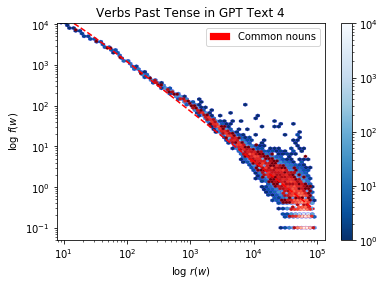

In [33]:
# for i, real in enumerate(real_dfs):
real = df_k40_4
# NN_df = real.query("ilevel_1 == 'NN' or ilevel_1 == 'NNS'")
JJ_df = real.query("ilevel_1 == 'VBD'")
not_real = real.query("ilevel_1 != 'VBD'")
hexbin_plot(not_real['Rank'], not_real['Frequency'], est=not_real['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$")

hexbin_plot(JJ_df['Rank'], JJ_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
            color="red", edgecolors="red", cmap="Reds_r", cbar=False, label = 'Common nouns')
plt.title("Verbs Past Tense in GPT Text {}".format(i+1))
plt.legend()
# plt.savefig("verb_past_k40_4.png",
#             dpi=300)
# plt.savefig("common_nouns_real_" + i + ".png",
#             dpi=300)

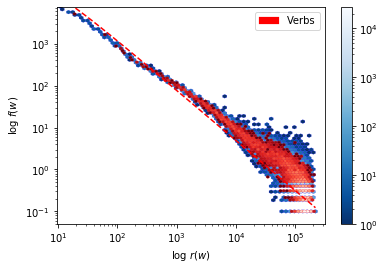

In [95]:
hexbin_plot(real_plot_5['Rank'], real_plot_5['Frequency'], est=real_plot_5['Estimated frequency'], xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$")

hexbin_plot(type_df['Rank'], type_df['Frequency'], est=None, xlbl=r"$\log$ $r(w)$", ylbl=r"$\log$ $f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=False, label = 'Verbs')
plt.legend()
plt.savefig("Verbs_real_5.png", dpi=300)

# Tests real text

### 1

In [110]:
df_real_1 = pickle.load(open('df_real_1.pkl', 'rb'))

In [111]:
df_real_1.index.unique(level=1)

Index(['DT', 'TO', 'IN', 'CC', 'VBZ', 'PRP', 'VBD', 'VBP', 'VB', 'RB', 'PRP$',
       'WDT', 'MD', 'WP', 'CD', 'WRB', 'VBN', 'EX', 'JJ', 'NNS', 'NN', 'RP',
       'JJR', 'RBR', 'VBG', 'NNP', 'RBS', 'JJS', 'PDT', 'NNPS', 'WP$', 'UH',
       'FW', 'LS', '$', 'SYM', 'POS', ''''],
      dtype='object')

In [31]:
rank_sents_real_1, freq_sents_real_1, sen_len_real_1 = subsampling(real_pos_1)

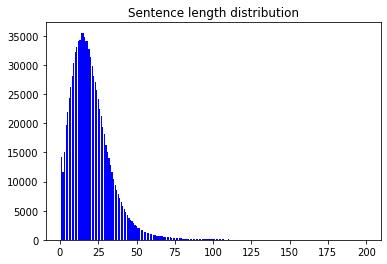

In [32]:
plt.bar(list(sen_len_real_1.keys()), sen_len_real_1.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [33]:
ranks_freqs_real_1 = ranks_freqs(rank_sents_real_1, freq_sents_real_1)

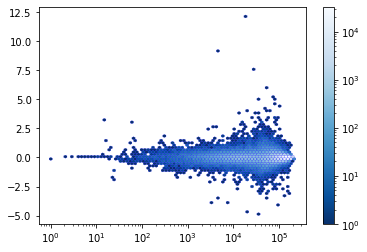

In [34]:
fano_real_1 = fano_factor(ranks_freqs_real_1)

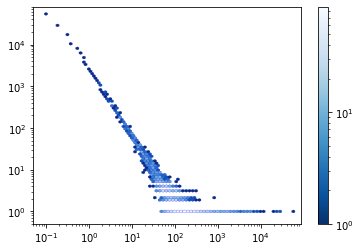

In [70]:
freq_of_freqs_hexbin_plot(real_plot_1['Frequency'])

In [71]:
real_plot_1.to_pickle('df_real_1.pkl')

### 2

In [58]:
rank_sents_real_2, freq_sents_real_2, sen_len_real_2 = subsampling(real_pos_2)

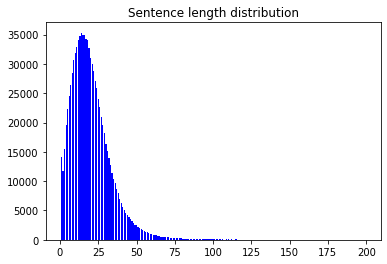

In [59]:
plt.bar(list(sen_len_real_2.keys()), sen_len_real_2.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [60]:
ranks_freqs_real_2 = ranks_freqs(rank_sents_real_2, freq_sents_real_2)

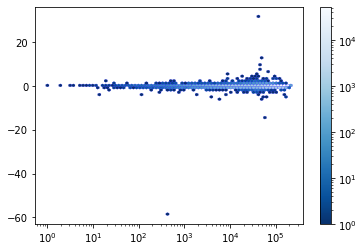

In [61]:
fano_real_2 = fano_factor(ranks_freqs_real_2)

0         1         2         3         4  \
the            DT        1.0       1.0       1.0       1.0       1.0   
to             TO        2.0       2.0       2.0       2.0       2.0   
of             IN        3.0       3.0       3.0       3.0       3.0   
and            CC        4.0       4.0       4.0       4.0       4.0   
a              DT        5.0       5.0       5.0       5.0       5.0   
...                      ...       ...       ...       ...       ...   
spectaclehis   JJ   246750.0  233432.0  235807.0  191790.0  197783.0   
townsquare     NNP  195214.0   55788.0  194122.0  249554.0  220167.0   
rarecasualplay NNP  247153.0  238557.0  242107.0  253150.0  256554.0   
unrewarding    VBG  241640.0  253525.0  224952.0  219968.0  226183.0   
kyriazis       NNP  253593.0  236783.0  219018.0  233236.0  230762.0   

                           5         6         7         8         9  ...  \
the            DT        1.0       1.0       1.0       1.0       1.0  ...   
to             TO        2.0       2.0       2.0       2.0       2.0  ...   
of             IN        3.0       3.0       3.0       3.0       3.0  ...   
and            CC        4.0       4.0       4.0       4.0       4.0  ...   
a              DT        5.0       5.0       5.0       5.0       5.0  ...   
...                      ...       ...       ...       ...       ...  ...   
spectaclehis   JJ   230486.0   52783.0  253186.0  250026.0  225388.0  ...   
townsquare     NNP  237067.0  256414.0  250449.0  247084.0  213416.0  ...   
rarecasualplay NNP  215709.0  178001.0   65407.0  238952.0  186647.0  ...   
unrewarding    VBG  242416.0  209679.0  251306.0  206382.0   62014.0  ...   
kyriazis       NNP   49586.0  252285.0  236916.0  224053.0  209913.0  ...   

                          7        8        9  Frequency      Fano  \
the            DT   57184.0  57323.0  57569.0    57448.9  0.000000   
to             TO   27596.0  27781.0  28164.0    27899.9  0.000000   
of             IN   25893.0  26116.0  26006.0    26095.2  0.000000   
and            CC   25284.0  25413.0  25227.0    25389.7  0.000000   
a              DT   23636.0  23459.0  23373.0    23446.6  0.000000   
...                     ...      ...      ...        ...       ...   
spectaclehis   JJ       1.0      0.0      0.0        0.1  0.021747   
townsquare     NNP      0.0      0.0      0.0        0.1 -0.081862   
rarecasualplay NNP      1.0      0.0      0.0        0.1 -0.076867   
unrewarding    VBG      0.0      0.0      0.0        0.1 -0.002145   
kyriazis       NNP      1.0      0.0      0.0        0.2  0.031726   

                    Estimated frequency  Rank (log)  Frequency (log)  \
the            DT          54222.533931    0.000000        10.958651   
to             TO          41921.050494    0.693147        10.236378   
of             IN          33925.516297    1.098612        10.169507   
and            CC          28344.426663    1.386294        10.142099   
a              DT          24245.129017    1.609438        10.062481   
...                                 ...         ...              ...   
spectaclehis   JJ              0.128036   12.263129        -2.302585   
townsquare     NNP             0.127903   12.264000        -2.302585   
rarecasualplay NNP             0.127690   12.265396        -2.302585   
unrewarding    VBG             0.126561   12.272827        -2.302585   
kyriazis       NNP             0.125991   12.276599        -1.609438   

                    Estimated frequency (log)     Error  
the            DT                   10.900852  0.057799  
to             TO                   10.643543 -0.407165  
of             IN                   10.431923 -0.262416  
and            CC                   10.252186 -0.110087  
a              DT                   10.095971 -0.033490  
...                                       ...       ...  
spectaclehis   JJ                   -2.055440 -0.247145  
townsquare     NNP                  -2.056481 -0.246104  
rarecasua

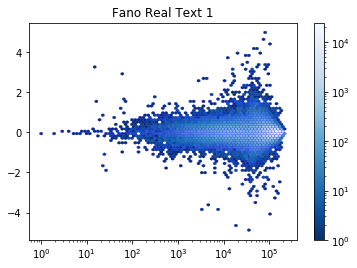

In [145]:
fano_plot(df_real_1)
plt.title("Fano Real Text 1")
plt.savefig("fano_real_1",
            dpi=300)

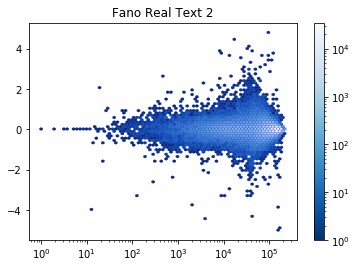

In [147]:
fano_plot(df_real_2)
plt.title("Fano Real Text 2")
plt.savefig("fano_real_2",
            dpi=300)

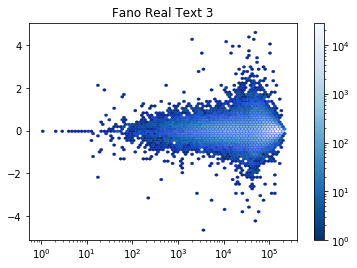

In [150]:
fano_plot(df_real_3)
plt.title("Fano Real Text 3")
plt.savefig("fano_real_3",
            dpi=300)

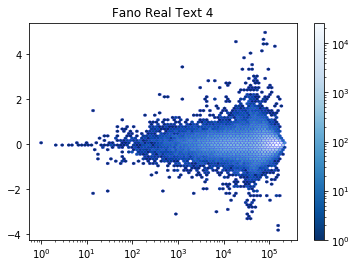

In [151]:
fano_plot(df_real_4)
plt.title("Fano Real Text 4")
plt.savefig("fano_real_4",
            dpi=300)

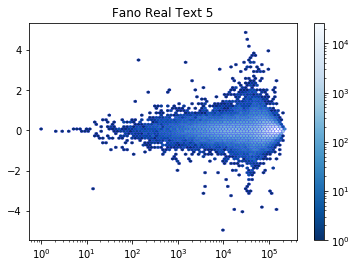

In [152]:
fano_plot(df_real_5)
plt.title("Fano Real Text 5")
plt.savefig("fano_real_5",
            dpi=300)

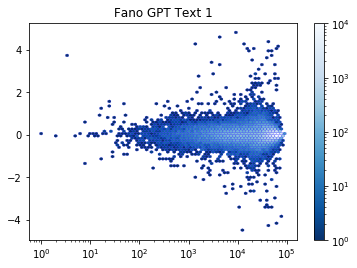

In [153]:
fano_plot(df_k40_1)
plt.title("Fano GPT Text 1")
plt.savefig("fano_k40_1",
            dpi=300)

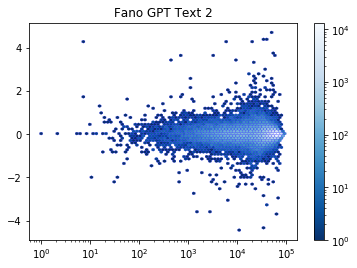

In [154]:
fano_plot(df_k40_2)
plt.title("Fano GPT Text 2")
plt.savefig("fano_k40_2",
            dpi=300)

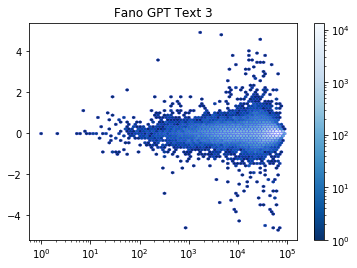

In [155]:
fano_plot(df_k40_3)
plt.title("Fano GPT Text 3")
plt.savefig("fano_k40_3",
            dpi=300)

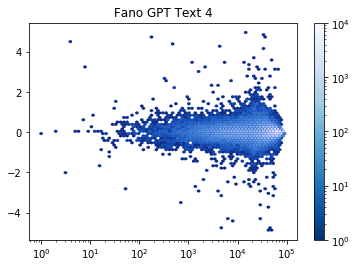

In [156]:
fano_plot(df_k40_4)
plt.title("Fano GPT Text 4")
plt.savefig("fano_k40_4",
            dpi=300)

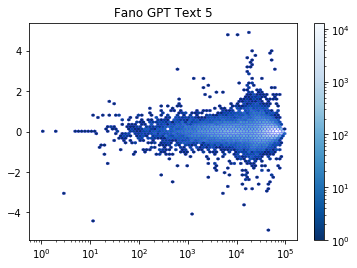

In [157]:
fano_plot(df_k40_5)
plt.title("Fano GPT Text 5")
plt.savefig("fano_k40_5",
            dpi=300)

In [70]:
df_real_1.head(10)

0     1     2     3     4     5     6     7     8     9  ...  \
the DT    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
to  TO    2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
of  IN    3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0  ...   
and CC    4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0  ...   
a   DT    5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0  ...   
in  IN    6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0  ...   
is  VBZ   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0  ...   
for IN    8.0   8.0   8.0   8.0   8.0   8.0   8.0   8.0   8.0   8.0  ...   
it  PRP   9.0   9.0   9.0   9.0   9.0   9.0   9.0   9.0   9.0   9.0  ...   
on  IN   10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  ...   

               7        8        9  Frequency  Fano  Estimated frequency  \
the DT   57184.0  57323.0  57569.0    57448.9   0.0         54222.533931   
to  TO   27596.0  27781.0  28164.0    27899.9   0.0         41921.050494   
of  IN   25893.0  26116.0  26006.0    26095.2   0.0         33925.516297   
and CC   25284.0  25413.0  25227.0    25389.7   0.0         28344.426663   
a   DT   23636.0  23459.0  23373.0    23446.6   0.0         24245.129017   
in  IN   19000.0  19050.0  18899.0    18949.7   0.0         21116.886661   
is  VBZ  11182.0  11227.0  11269.0    11310.5   0.0         18657.555266   
for IN   10012.0  10047.0  10010.0    10066.0   0.0         16677.456010   
it  PRP   8787.0   8849.0   8816.0     8811.3   0.0         15051.764869   
on  IN    8306.0   8184.0   8222.0     8175.5   0.0         13695.123765   

         Rank (log)  Frequency (log)  Estimated frequency (log)     Error  
the DT     0.000000        10.958651                  10.900852  0.057799  
to  TO     0.693147        10.236378                  10.643543 -0.407165  
of  IN     1.098612        10.169507                  10.431923 -0.262416  
and CC     1.386294        10.142099                  10.252186 -0.110087  
a   DT     1.609438        10.062481                  10.095971 -0.033490  
in  IN     1.791759         9.849543                   9.957828 -0.108285  
is  VBZ    1.945910         9.333487                   9.834006 -0.500520  
for IN     2.079442         9.216919                   9.721813 -0.504894  
it  PRP    2.197225         9.083790                   9.619251 -0.535460  
on  IN     2.302585         9.008897                   9.524795 -0.515898  

[10 rows x 28 columns]

In [169]:
df_real_1['Rank']

the             DT          1.0
to              TO          2.0
of              IN          3.0
and             CC          4.0
a               DT          5.0
                         ...   
spectaclehis    JJ     211743.1
townsquare      NNP    211927.5
rarecasualplay  NNP    212223.7
unrewarding     VBG    213806.5
kyriazis        NNP    214614.5
Name: Rank, Length: 179741, dtype: float64

In [71]:
df_k40_1.head(10)

0     1     2     3     4     5     6     7     8     9  ...  \
the DT    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
to  TO    2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   
a   DT    3.0   3.0   3.0   3.0   3.0   4.0   4.0   3.0   4.0   4.0  ...   
of  IN    4.0   4.0   4.0   4.0   4.0   3.0   3.0   4.0   3.0   3.0  ...   
and CC    5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0  ...   
in  IN    6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0  ...   
it  PRP   8.0   7.0   8.0   7.0   7.0   7.0   7.0   7.0   7.0   8.0  ...   
is  VBZ   7.0   8.0   7.0   8.0   8.0   8.0   8.0   8.0   8.0   7.0  ...   
i   PRP   9.0   9.0   9.0   9.0   9.0   9.0   9.0   9.0   9.0   9.0  ...   
for IN   10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  ...   

               7        8        9  Frequency       Fano  Estimated frequency  \
the DT   60238.0  59810.0  59966.0    60257.8   0.000000         58862.299260   
to  TO   34543.0  34702.0  34493.0    34460.1   0.000000         45765.396967   
a   DT   27136.0  27045.0  27248.0    26950.9  11.875817         34467.659503   
of  IN   26852.0  26894.0  26696.0    26996.0   3.734568         33260.073223   
and CC   24803.0  24736.0  24712.0    24649.6   0.000000         26575.336991   
in  IN   19796.0  19527.0  19918.0    19660.3   0.000000         23138.901968   
it  PRP  12445.0  12256.0  12547.0    12396.2  -1.348554         19727.446858   
is  VBZ  12394.0  12145.0  12389.0    12447.5   0.656566         18855.620914   
i   PRP  11154.0  11060.0  10939.0    10988.4   0.000000         16451.186217   
for IN   10548.0  10821.0  10696.0    10621.3   0.000000         14952.140276   

         Rank (log)  Frequency (log)  Estimated frequency (log)     Error  
the DT     0.000000        11.006387                  10.982956  0.023431  
to  TO     0.693147        10.447557                  10.731284 -0.283726  
a   DT     1.223775        10.201772                  10.447777 -0.246005  
of  IN     1.280934        10.203444                  10.412113 -0.208669  
and CC     1.609438        10.112516                  10.187739 -0.075223  
in  IN     1.791759         9.886357                  10.049271 -0.162914  
it  PRP    1.987874         9.425145                   9.889766 -0.464621  
is  VBZ    2.041220         9.429275                   9.844566 -0.415291  
i   PRP    2.197225         9.304595                   9.708153 -0.403557  
for IN     2.302585         9.270617                   9.612610 -0.341993  

[10 rows x 28 columns]

Optimization terminated successfully.
         Current function value: 19.535931
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.2, 3.16)
  Standard Error [relative]: (0.000347, 0.0203), [(0.00029, 0.00641)]
  Pseudo R^2: 0.715
  BIC [relative]: 6960000.0, [3.51]


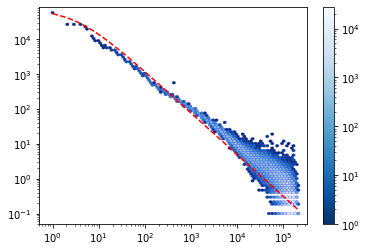

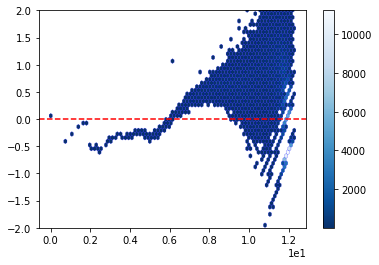

In [63]:
real_plot_2 = plot_zipf(fano_real_2)

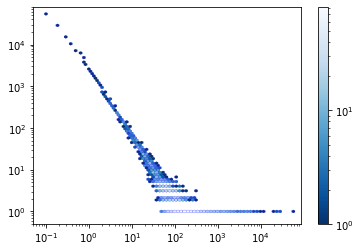

In [65]:
freq_of_freqs_hexbin_plot(real_plot_2['Frequency'])

In [68]:
real_plot_2.to_pickle('df_real_2.pkl')

### 3

In [72]:
rank_sents_real_3, freq_sents_real_3, sen_len_real_3 = subsampling(real_pos_3)

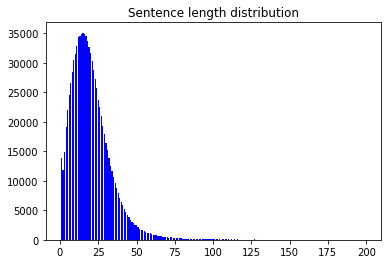

In [73]:
plt.bar(list(sen_len_real_3.keys()), sen_len_real_3.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [74]:
ranks_freqs_real_3 = ranks_freqs(rank_sents_real_3, freq_sents_real_3)

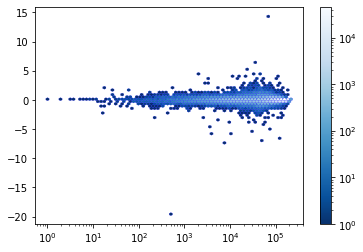

In [75]:
fano_real_3 = fano_factor(ranks_freqs_real_3)

In [69]:
fano_3 = pickle.load(open('df_real_3.pkl', 'rb'))

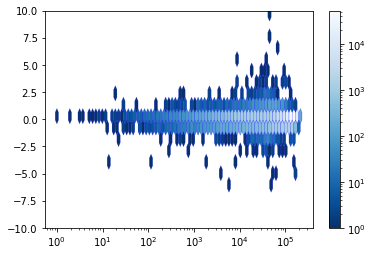

In [70]:
fano_plot(fano_2, ylim = [-10,10])

Optimization terminated successfully.
         Current function value: 19.446316
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.2, 3.16)
  Standard Error [relative]: (0.000347, 0.0203), [(0.00029, 0.00641)]
  Pseudo R^2: 0.715
  BIC [relative]: 6970000.0, [3.51]


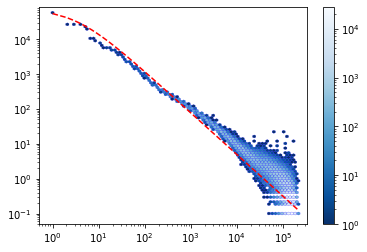

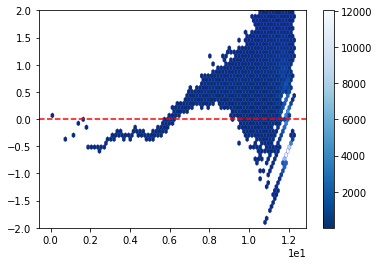

In [76]:
real_plot_3 = plot_zipf(fano_real_3)

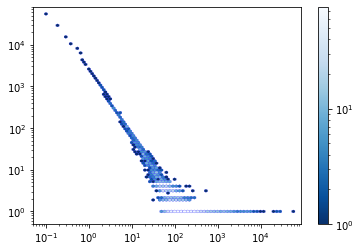

In [77]:
freq_of_freqs_hexbin_plot(real_plot_3['Frequency'])

In [78]:
real_plot_3.to_pickle('df_real_3.pkl')

### 4

In [106]:
rank_sents_real_4, freq_sents_real_4, sen_len_real_4 = subsampling(real_pos_4)

In [107]:
pickle.dump(sen_len_real_4, open("sen_len_real_4.p", "wb"))

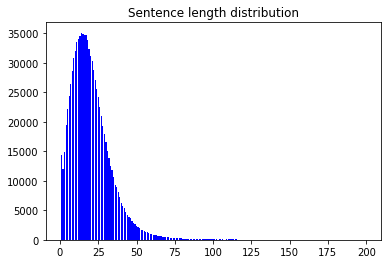

In [108]:
plt.bar(list(sen_len_real_4.keys()), sen_len_real_4.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [109]:
ranks_freqs_real_4 = ranks_freqs(rank_sents_real_4, freq_sents_real_4)

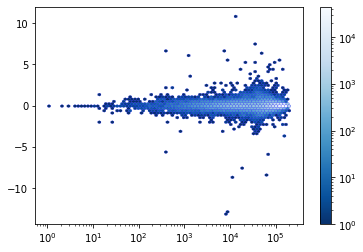

In [110]:
fano_real_4 = fano_factor(ranks_freqs_real_4)

Optimization terminated successfully.
         Current function value: 19.456186
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.2, 3.16)
  Standard Error [relative]: (0.000347, 0.0203), [(0.00029, 0.00641)]
  Pseudo R^2: 0.715
  BIC [relative]: 6970000.0, [3.51]


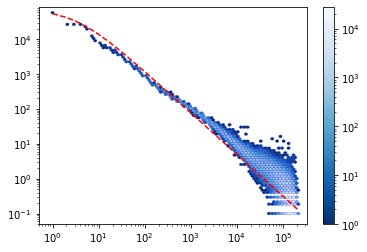

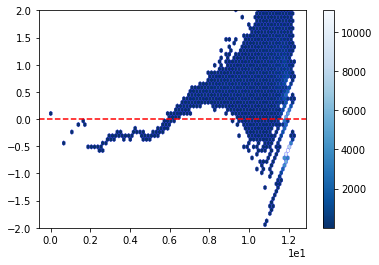

In [111]:
real_plot_4 = plot_zipf(fano_real_4)

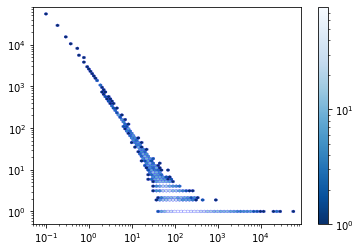

In [112]:
freq_of_freqs_hexbin_plot(real_plot_4['Frequency'])

In [113]:
real_plot_4.to_pickle('df_real_4.pkl')

### 5

In [34]:
rank_sents_real_5, freq_sents_real_5, sen_len_real_5 = subsampling(real_pos_5)

In [35]:
pickle.dump(sen_len_real_5, open("sen_len_real_5.p", "wb"))

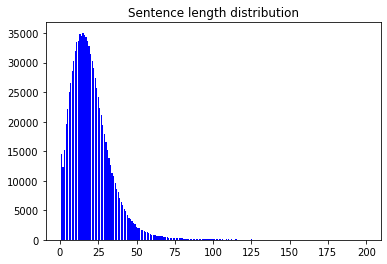

In [36]:
plt.bar(list(sen_len_real_5.keys()), sen_len_real_5.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [37]:
ranks_freqs_real_5 = ranks_freqs(rank_sents_real_5, freq_sents_real_5)

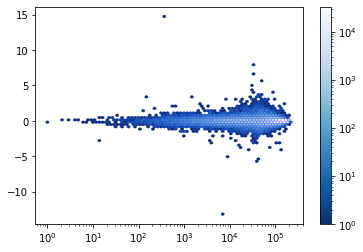

In [38]:
fano_real_5 = fano_factor(ranks_freqs_real_5)

Optimization terminated successfully.
         Current function value: 19.357884
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.2, 3.17)
  Standard Error [relative]: (0.000347, 0.0203), [(0.00029, 0.00641)]
  Pseudo R^2: 0.715
  BIC [relative]: 6970000.0, [3.51]


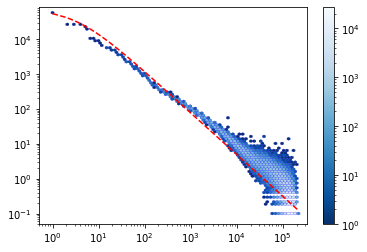

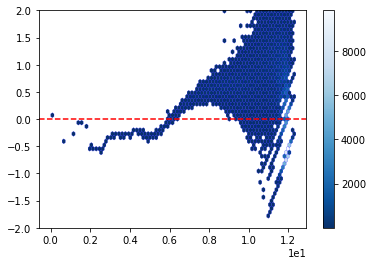

In [39]:
real_plot_5 = plot_zipf(ranks_freqs_real_5)

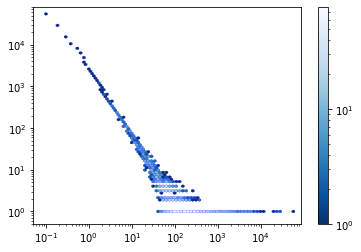

In [40]:
freq_of_freqs_hexbin_plot(real_plot_5['Frequency'])

# Tests generated text

### 1

In [79]:
rank_sents_k40_1, freq_sents_k40_1, sen_len_k40_1 = subsampling(gpt_small_k40_pos_1)

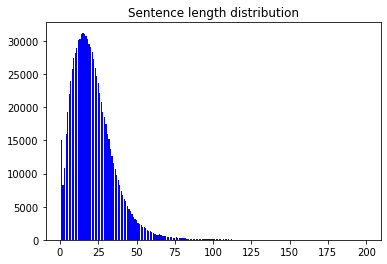

In [80]:
plt.bar(list(sen_len_k40_1.keys()), sen_len_k40_1.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [81]:
ranks_freqs_k40_1 = ranks_freqs(rank_sents_k40_1, freq_sents_k40_1)

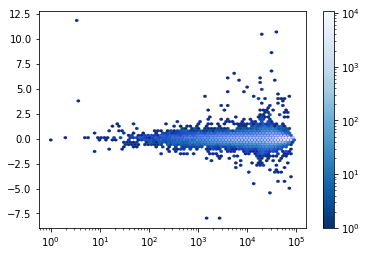

In [82]:
fano_k40_1 = fano_factor(ranks_freqs_k40_1)

Optimization terminated successfully.
         Current function value: 39.881365
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 3.42)
  Standard Error [relative]: (0.000417, 0.0193), [(0.000338, 0.00565)]
  Pseudo R^2: 0.742
  BIC [relative]: 6160000.0, [3.88]


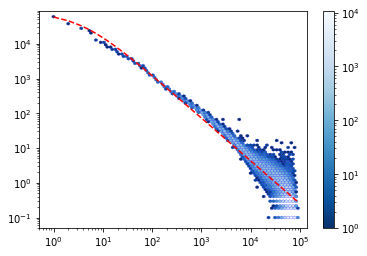

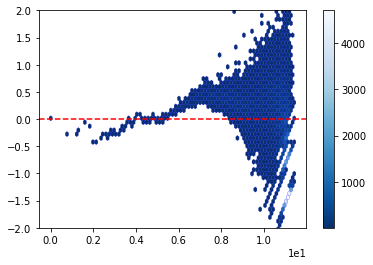

In [83]:
gpt_small_k40_1_plot = plot_zipf(fano_k40_1)

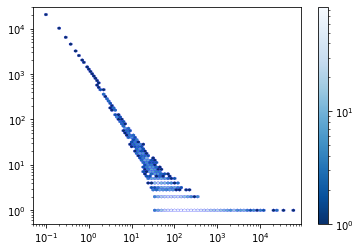

In [84]:
freq_of_freqs_hexbin_plot(gpt_small_k40_1_plot['Frequency'])

In [85]:
gpt_small_k40_1_plot.to_pickle('df_k40_1.pkl')

### 2

In [86]:
rank_sents_k40_2, freq_sents_k40_2, sen_len_k40_2 = subsampling(gpt_small_k40_pos_2)

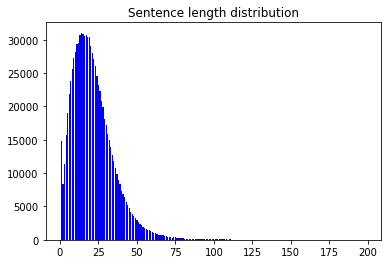

In [87]:
plt.bar(list(sen_len_k40_2.keys()), sen_len_k40_2.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [88]:
ranks_freqs_k40_2 = ranks_freqs(rank_sents_k40_2, freq_sents_k40_2)

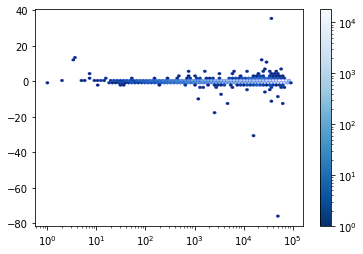

In [89]:
fano_k40_2 = fano_factor(ranks_freqs_k40_2)

Optimization terminated successfully.
         Current function value: 40.147515
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 3.42)
  Standard Error [relative]: (0.000417, 0.0193), [(0.000338, 0.00564)]
  Pseudo R^2: 0.742
  BIC [relative]: 6160000.0, [3.88]


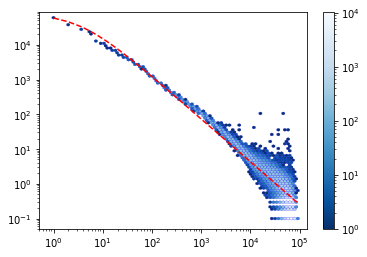

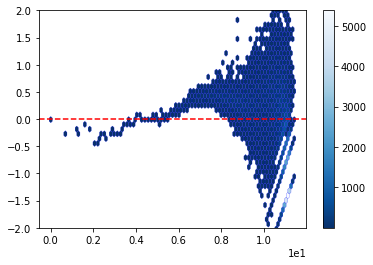

In [90]:
gpt_small_k40_2_plot = plot_zipf(fano_k40_2)

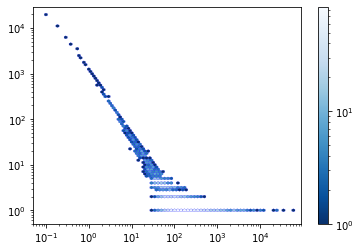

In [91]:
freq_of_freqs_hexbin_plot(gpt_small_k40_2_plot['Frequency'])

In [92]:
gpt_small_k40_2_plot.to_pickle('df_k40_2.pkl')

### 3

In [93]:
rank_sents_k40_3, freq_sents_k40_3, sen_len_k40_3 = subsampling(gpt_small_k40_pos_3)

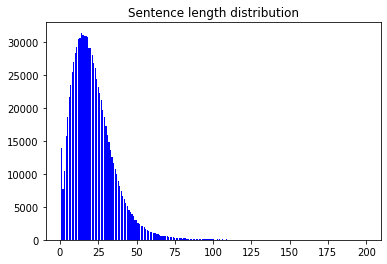

In [94]:
plt.bar(list(sen_len_k40_3.keys()), sen_len_k40_3.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [95]:
ranks_freqs_k40_3 = ranks_freqs(rank_sents_k40_3, freq_sents_k40_3)

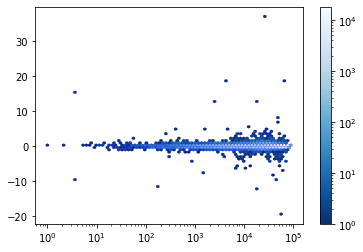

In [96]:
fano_k40_3 = fano_factor(ranks_freqs_k40_3)

Optimization terminated successfully.
         Current function value: 39.960822
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 3.43)
  Standard Error [relative]: (0.000417, 0.0193), [(0.000338, 0.00564)]
  Pseudo R^2: 0.742
  BIC [relative]: 6160000.0, [3.88]


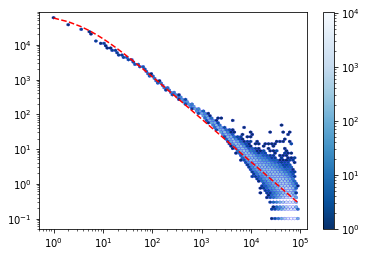

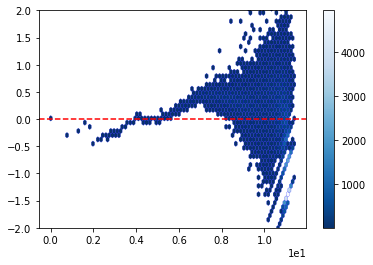

In [97]:
gpt_small_k40_3_plot = plot_zipf(fano_k40_3)

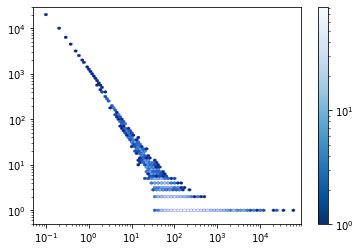

In [98]:
freq_of_freqs_hexbin_plot(gpt_small_k40_3_plot['Frequency'])

In [99]:
gpt_small_k40_3_plot.to_pickle('df_k40_3.pkl')

### 4

In [26]:
rank_sents_k40_4, freq_sents_k40_4, sen_len_k40_4 = subsampling(gpt_small_k40_pos_4)

In [27]:
pickle.dump(sen_len_k40_4, open("sen_len_k40_4.p", "wb"))

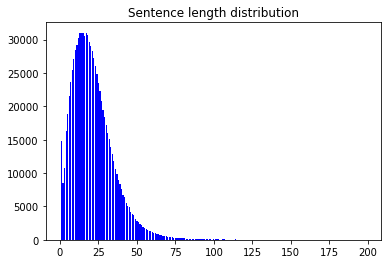

In [28]:
plt.bar(list(sen_len_k40_4.keys()), sen_len_k40_4.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [29]:
ranks_freqs_k40_4 = ranks_freqs(rank_sents_k40_4, freq_sents_k40_4)

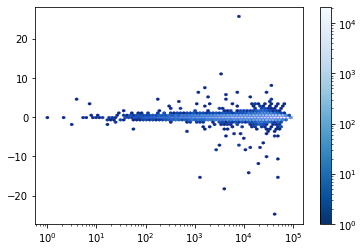

In [30]:
fano_k40_4 = fano_factor(ranks_freqs_k40_4)

Optimization terminated successfully.
         Current function value: 39.923858
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 3.43)
  Standard Error [relative]: (0.000417, 0.0193), [(0.000338, 0.00564)]
  Pseudo R^2: 0.742
  BIC [relative]: 6170000.0, [3.88]


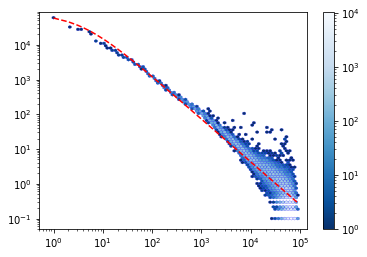

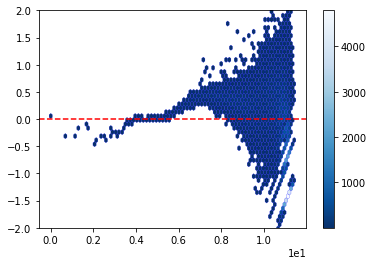

In [31]:
gpt_small_k40_4_plot = plot_zipf(fano_k40_4)

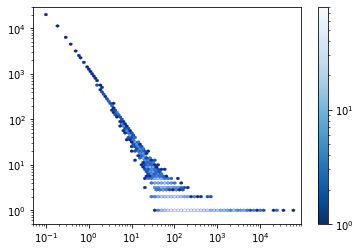

In [32]:
freq_of_freqs_hexbin_plot(gpt_small_k40_4_plot['Frequency'])

In [33]:
gpt_small_k40_4_plot.to_pickle('df_k40_4.pkl')

### 5

In [51]:
rank_sents_k40_5, freq_sents_k40_5, sen_len_k40_5 = subsampling(k40_5)

In [52]:
pickle.dump(sen_len_k40_5, open("sen_len_k40_5.p", "wb"))

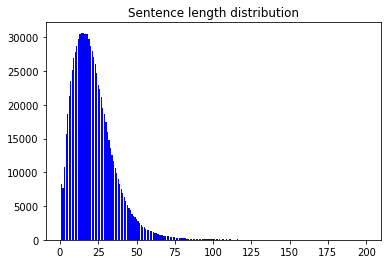

In [53]:
plt.bar(list(sen_len_k40_5.keys()), sen_len_k40_5.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [54]:
ranks_freqs_k40_5 = ranks_freqs(rank_sents_k40_5, freq_sents_k40_5)

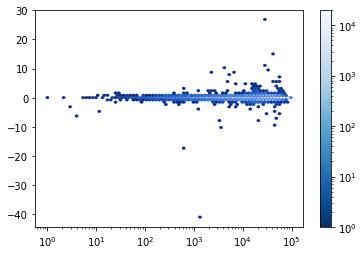

In [55]:
fano_k40_5 = fano_factor(ranks_freqs_k40_5)

Optimization terminated successfully.
         Current function value: 40.827385
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.24, 3.55)
  Standard Error [relative]: (0.000427, 0.0193), [(0.000345, 0.00543)]
  Pseudo R^2: 0.746
  BIC [relative]: 6040000.0, [3.94]


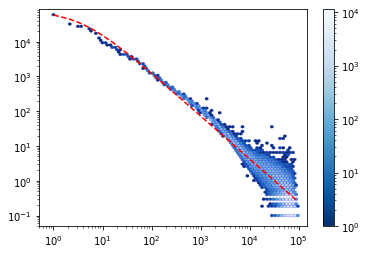

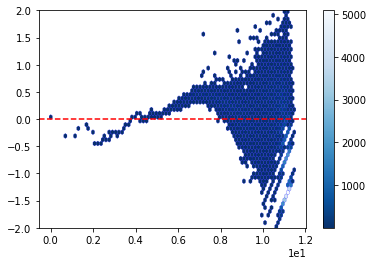

In [56]:
gpt_small_k40_5_plot = plot_zipf(fano_k40_5)

In [57]:
gpt_small_k40_5_plot.to_pickle('df_k40_5.pkl')

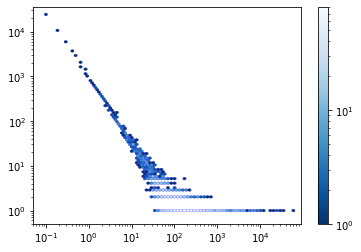

In [71]:
freq_of_freqs_hexbin_plot(gpt_small_k40_5_plot['Frequency'])

# Tets files

## Real

### 1

In [184]:
rank_sents_real_test_1, freq_sents_real_test_1, sen_len_real_test_1 = subsampling(real_test_1, k=10000)

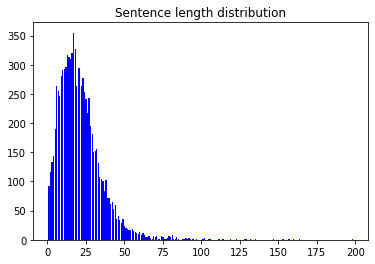

In [185]:
plt.bar(list(sen_len_real_test_1.keys()), sen_len_real_test_1.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [186]:
ranks_freqs_real_test_1 = ranks_freqs(rank_sents_real_test_1, freq_sents_real_test_1)

In [187]:
fano_real_test_1 = fano_factor(ranks_freqs_real_test_1)

In [188]:
real_test_plot_1 = plot_zipf(fano_real_test_1)

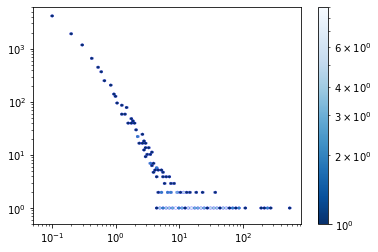

In [189]:
freq_of_freqs_hexbin_plot(real_test_plot_1['Frequency'])

### 2

In [316]:
rank_sents_real_test_2, freq_sents_real_test_2, sen_len_real_test_2 = subsampling(real_test_2, k=10000)

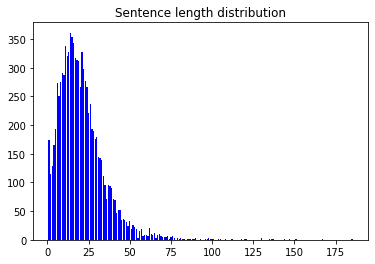

In [317]:
plt.bar(list(sen_len_real_test_2.keys()), sen_len_real_test_2.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [318]:
ranks_freqs_real_test_2 = ranks_freqs(rank_sents_real_test_2, freq_sents_real_test_2)

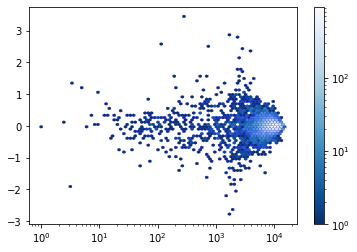

In [319]:
fano_real_test_2 = fano_factor(ranks_freqs_real_test_2)

Optimization terminated successfully.
         Current function value: 2.889556
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.19, 1.81)
  Standard Error [relative]: (0.00329, 0.0762), [(0.00276, 0.0421)]
  Pseudo R^2: 0.713
  BIC [relative]: 63600.0, [3.49]


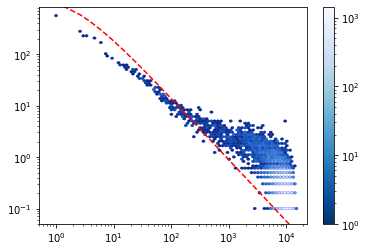

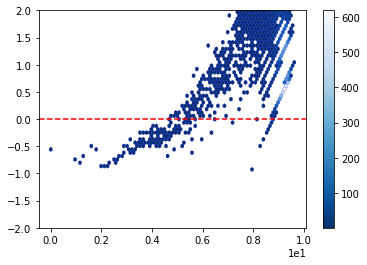

In [320]:
real_test_plot_2 = plot_zipf(fano_real_test_2)

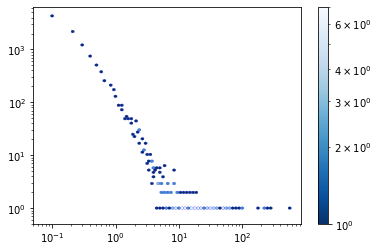

In [321]:
freq_of_freqs_hexbin_plot(real_test_plot_2['Frequency'])

### 3

In [322]:
rank_sents_real_test_3, freq_sents_real_test_3, sen_len_real_test_3 = subsampling(real_test_3, k=10000)

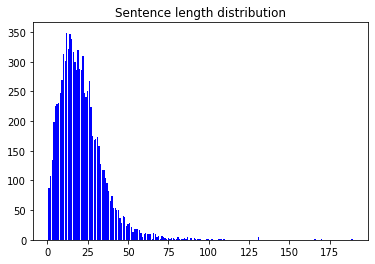

In [323]:
plt.bar(list(sen_len_real_test_3.keys()), sen_len_real_test_3.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [324]:
ranks_freqs_real_test_3 = ranks_freqs(rank_sents_real_test_3, freq_sents_real_test_3)

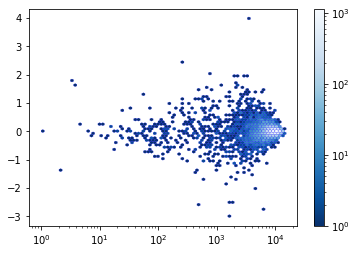

In [325]:
fano_real_test_3 = fano_factor(ranks_freqs_real_test_3)

Optimization terminated successfully.
         Current function value: 2.944900
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.2, 1.8)
  Standard Error [relative]: (0.00334, 0.0765), [(0.00279, 0.0424)]
  Pseudo R^2: 0.715
  BIC [relative]: 62800.0, [3.51]


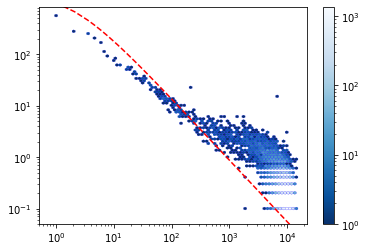

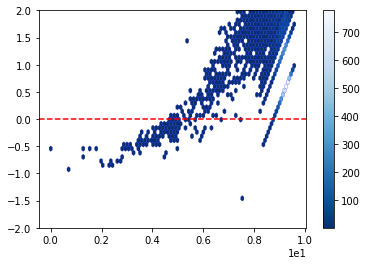

In [326]:
real_test_plot_3 = plot_zipf(fano_real_test_3)

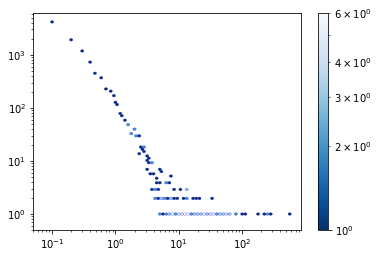

In [327]:
freq_of_freqs_hexbin_plot(real_test_plot_3['Frequency'])

### 4

In [328]:
rank_sents_real_test_4, freq_sents_real_test_4, sen_len_real_test_4 = subsampling(real_test_4, k=10000)

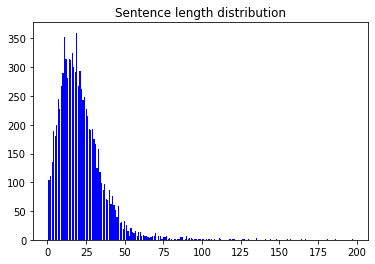

In [329]:
plt.bar(list(sen_len_real_test_4.keys()), sen_len_real_test_4.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [330]:
ranks_freqs_real_test_4 = ranks_freqs(rank_sents_real_test_4, freq_sents_real_test_4)

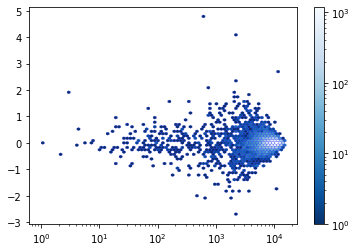

In [331]:
fano_real_test_4 = fano_factor(ranks_freqs_real_test_4)

Optimization terminated successfully.
         Current function value: 2.914029
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.19, 1.8)
  Standard Error [relative]: (0.0033, 0.0765), [(0.00276, 0.0424)]
  Pseudo R^2: 0.713
  BIC [relative]: 63500.0, [3.49]


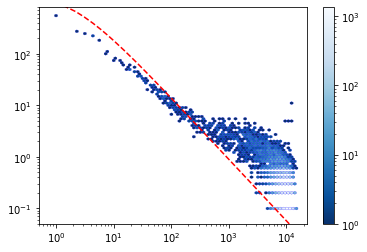

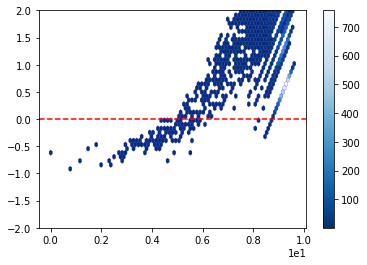

In [332]:
real_test_plot_4 = plot_zipf(fano_real_test_4)

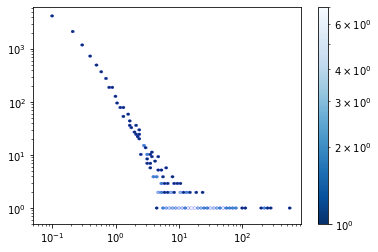

In [333]:
freq_of_freqs_hexbin_plot(real_test_plot_4['Frequency'])

### 5

In [334]:
rank_sents_real_test_5, freq_sents_real_test_5, sen_len_real_test_5 = subsampling(real_test_5, k=10000)

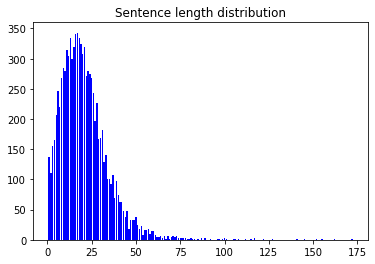

In [335]:
plt.bar(list(sen_len_real_test_5.keys()), sen_len_real_test_5.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [336]:
ranks_freqs_real_test_5 = ranks_freqs(rank_sents_real_test_5, freq_sents_real_test_5)

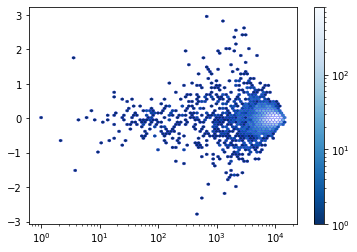

In [337]:
fano_real_test_5 = fano_factor(ranks_freqs_real_test_5)

Optimization terminated successfully.
         Current function value: 2.983701
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.2, 1.82)
  Standard Error [relative]: (0.00335, 0.0756), [(0.0028, 0.0415)]
  Pseudo R^2: 0.716
  BIC [relative]: 62600.0, [3.52]


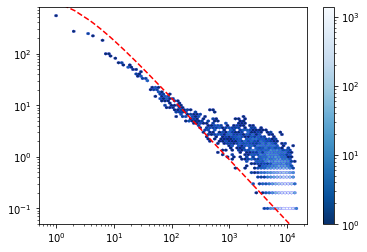

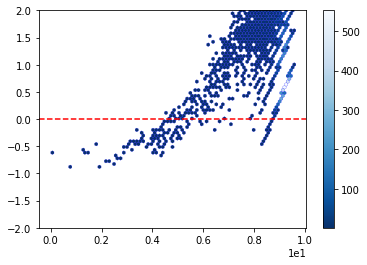

In [338]:
real_test_plot_5 = plot_zipf(fano_real_test_5)

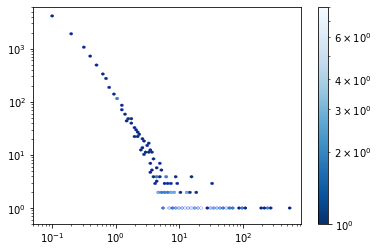

In [339]:
freq_of_freqs_hexbin_plot(real_test_plot_5['Frequency'])

## GPT

### 1

In [340]:
rank_sents_k40_test_1, freq_sents_k40_test_1, sen_len_k40_test_1 = subsampling(k40_test_1, k=10000)

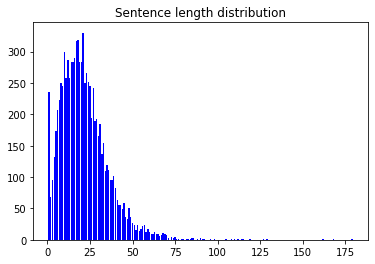

In [341]:
plt.bar(list(sen_len_k40_test_1.keys()), sen_len_k40_test_1.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [342]:
ranks_freqs_k40_test_1 = ranks_freqs(rank_sents_k40_test_1, freq_sents_k40_test_1)

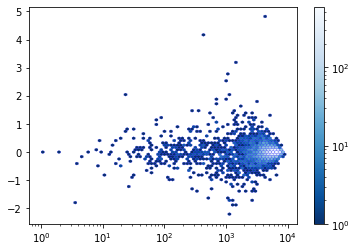

In [343]:
fano_k40_test_1 = fano_factor(ranks_freqs_k40_test_1)

Optimization terminated successfully.
         Current function value: 4.364083
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 1.94)
  Standard Error [relative]: (0.00378, 0.0696), [(0.00308, 0.0358)]
  Pseudo R^2: 0.738
  BIC [relative]: 59300.0, [3.82]


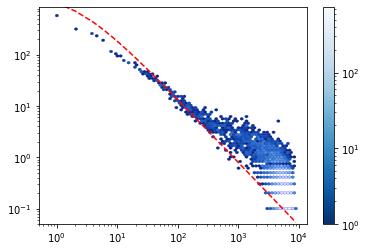

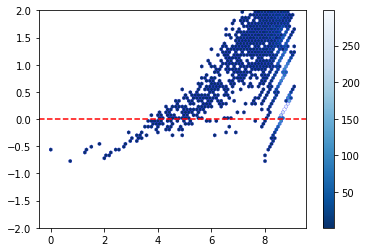

In [344]:
k40_test_plot_1 = plot_zipf(fano_k40_test_1)

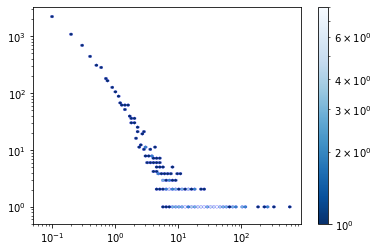

In [345]:
freq_of_freqs_hexbin_plot(k40_test_plot_1['Frequency'])

### 2

In [346]:
rank_sents_k40_test_2, freq_sents_k40_test_2, sen_len_k40_test_2 = subsampling(k40_test_2, k=10000)

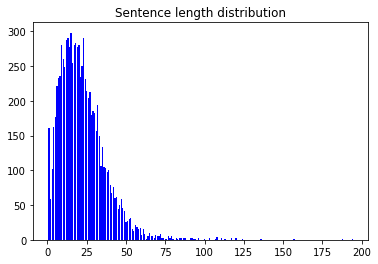

In [347]:
plt.bar(list(sen_len_k40_test_2.keys()), sen_len_k40_test_2.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [348]:
ranks_freqs_k40_test_2 = ranks_freqs(rank_sents_k40_test_2, freq_sents_k40_test_2)

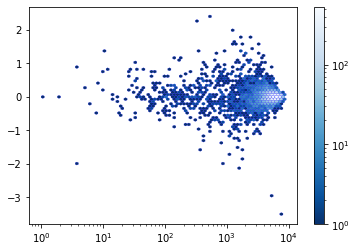

In [349]:
fano_k40_test_2 = fano_factor(ranks_freqs_k40_test_2)

Optimization terminated successfully.
         Current function value: 4.382054
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 1.98)
  Standard Error [relative]: (0.00378, 0.0683), [(0.00308, 0.0346)]
  Pseudo R^2: 0.739
  BIC [relative]: 59300.0, [3.83]


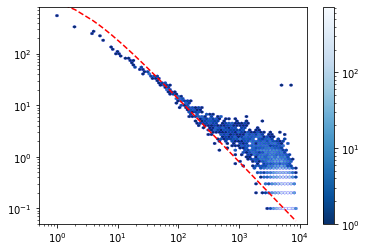

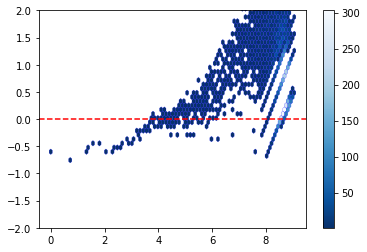

In [350]:
k40_test_plot_2 = plot_zipf(fano_k40_test_2)

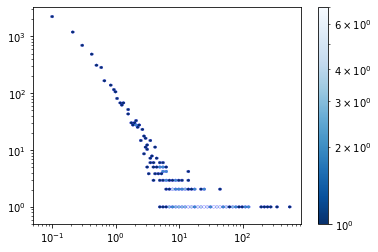

In [351]:
freq_of_freqs_hexbin_plot(k40_test_plot_2['Frequency'])

### 3

In [352]:
rank_sents_k40_test_3, freq_sents_k40_test_3, sen_len_k40_test_3 = subsampling(k40_test_3, k=10000)

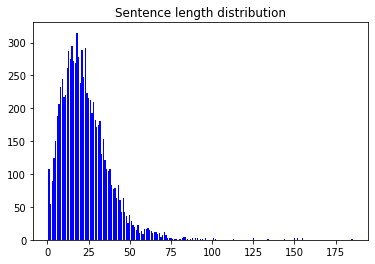

In [353]:
plt.bar(list(sen_len_k40_test_3.keys()), sen_len_k40_test_3.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [354]:
ranks_freqs_k40_test_3 = ranks_freqs(rank_sents_k40_test_3, freq_sents_k40_test_3)

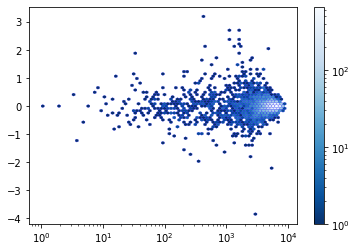

In [355]:
fano_k40_test_3 = fano_factor(ranks_freqs_k40_test_3)

Optimization terminated successfully.
         Current function value: 4.278127
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 1.93)
  Standard Error [relative]: (0.00375, 0.07), [(0.00306, 0.0362)]
  Pseudo R^2: 0.737
  BIC [relative]: 59800.0, [3.81]


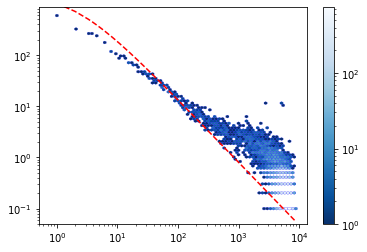

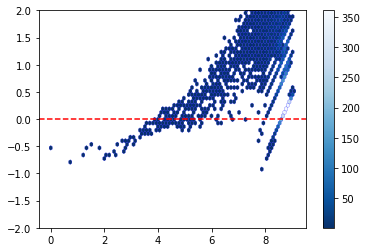

In [356]:
k40_test_plot_3 = plot_zipf(fano_k40_test_3)

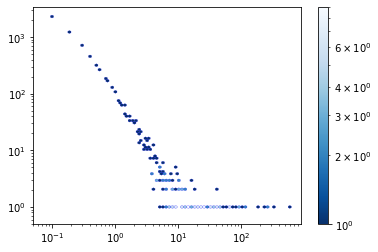

In [357]:
freq_of_freqs_hexbin_plot(k40_test_plot_3['Frequency'])

### 4

In [358]:
rank_sents_k40_test_4, freq_sents_k40_test_4, sen_len_k40_test_4 = subsampling(k40_test_4, k=10000)

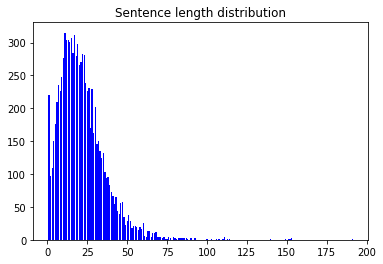

In [359]:
plt.bar(list(sen_len_k40_test_4.keys()), sen_len_k40_test_4.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [360]:
ranks_freqs_k40_test_4 = ranks_freqs(rank_sents_k40_test_4, freq_sents_k40_test_4)

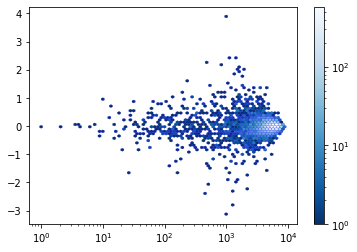

In [361]:
fano_k40_test_4 = fano_factor(ranks_freqs_k40_test_4)

Optimization terminated successfully.
         Current function value: 4.389129
         Iterations: 1
         Function evaluations: 24
MANDELBROT
  Optimal Parameters (1.23, 1.96)
  Standard Error [relative]: (0.0038, 0.0691), [(0.00309, 0.0353)]
  Pseudo R^2: 0.74
  BIC [relative]: 59300.0, [3.84]


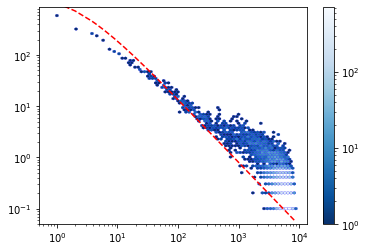

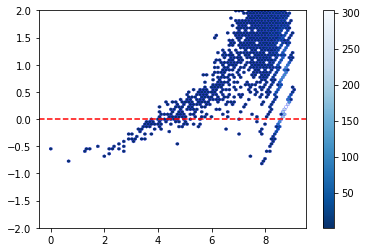

In [362]:
k40_test_plot_4 = plot_zipf(fano_k40_test_4)

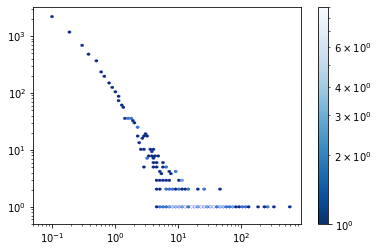

In [363]:
freq_of_freqs_hexbin_plot(k40_test_plot_4['Frequency'])

### 5

In [364]:
rank_sents_k40_test_5, freq_sents_k40_test_5, sen_len_k40_test_5 = subsampling(k40_test_5, k=10000)

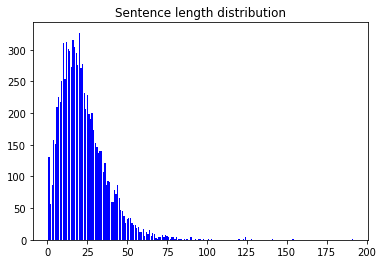

In [365]:
plt.bar(list(sen_len_k40_test_5.keys()), sen_len_k40_test_5.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [366]:
ranks_freqs_k40_test_5 = ranks_freqs(rank_sents_k40_test_5, freq_sents_k40_test_5)

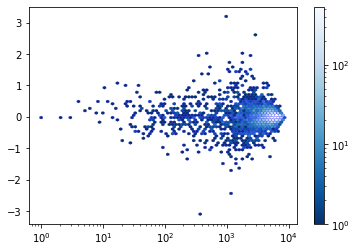

In [367]:
fano_k40_test_5 = fano_factor(ranks_freqs_k40_test_5)

Optimization terminated successfully.
         Current function value: 4.461878
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.23, 1.95)
  Standard Error [relative]: (0.00383, 0.0693), [(0.00311, 0.0355)]
  Pseudo R^2: 0.741
  BIC [relative]: 58700.0, [3.86]


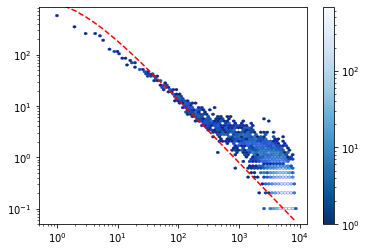

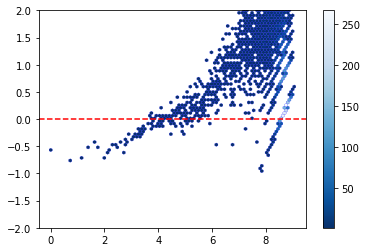

In [368]:
k40_test_plot_5 = plot_zipf(fano_k40_test_5)

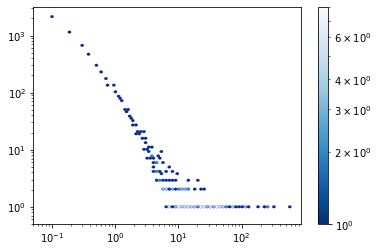

In [369]:
freq_of_freqs_hexbin_plot(k40_test_plot_5['Frequency'])

In [372]:
real_test_plot_1['Round'] = round(real_test_plot_1['Rank']).astype(int)

In [373]:
k40_test_plot_1['Round'] = round(k40_test_plot_1['Rank']).astype(int)

In [379]:
real_test_plot_1['Ding'] = real_test_plot_1['Rank'] * real_test_plot_1['Frequency']

In [385]:
real_test_plot_1

0        1        2        3        4        5        6  \
the        DT       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
to         TO       2.0      2.0      2.0      3.0      2.0      4.0      4.0   
of         IN       4.0      4.0      4.0      2.0      4.0      2.0      2.0   
and        CC       3.0      3.0      5.0      5.0      3.0      3.0      3.0   
a          DT       5.0      5.0      3.0      4.0      5.0      5.0      5.0   
...                 ...      ...      ...      ...      ...      ...      ...   
midwife    NN   17429.0  12604.0  16154.0  18742.0   7300.0  18927.0  19030.0   
detector   NN   18615.0   1563.0  15951.0  13341.0  18652.0  18509.0  11540.0   
entourages NNS  15750.0  18850.0  17727.0  16840.0  15178.0   3700.0  17284.0   
speeds     NNS  18110.0  17218.0  17996.0   4983.0  18847.0  17790.0  18979.0   
bullies    NNP  16494.0  19007.0  16221.0  18782.0  18246.0  17969.0  18269.0   

                      7        8        9  ...      9  Frequency      Fano  \
the        DT       1.0      1.0      1.0  ...  583.0      561.6  0.000000   
to         TO       2.0      3.0      2.0  ...  276.0      278.8  0.649573   
of         IN       4.0      4.0      3.0  ...  258.0      248.5 -0.353535   
and        CC       3.0      2.0      4.0  ...  239.0      240.8  0.287582   
a          DT       5.0      5.0      5.0  ...  223.0      221.7  0.877069   
...                 ...      ...      ...  ...    ...        ...       ...   
midwife    NN    2427.0  18987.0  12276.0  ...    0.0        0.1  0.035852   
detector   NN    9293.0  17486.0  19043.0  ...    0.0        0.1 -0.008166   
entourages NNS   4090.0  17818.0  17093.0  ...    0.0        0.1  0.010139   
speeds     NNS  16164.0   1948.0  15052.0  ...    0.0        0.2  0.057952   
bullies    NNP   4751.0  17620.0   1098.0  ...    0.0        0.1  0.029461   

                Estimated frequency  Rank (log)  Frequency (log)  \
the        DT           1012.717920    0.000000         6.330790   
to         TO            589.767864    0.955511         5.630495   
of         IN            494.277574    1.193922         5.515443   
and        CC            482.926546    1.223775         5.483967   
a          DT            369.766786    1.547563         5.401325   
...                             ...         ...              ...   
midwife    NN              0.036654    9.574122        -2.302585   
detector   NN              0.036618    9.574935        -2.302585   
entourages NNS             0.036516    9.577273        -2.302585   
speeds     NNS             0.035698    9.596194        -1.609438   
bullies    NNP             0.035304    9.605466        -2.302585   

                Estimated frequency (log)     Error  Round     Ding  
the        DT                    6.920393 -0.589603      1   561.60  
to         TO                    6.379729 -0.749234      3   724.88  
of         IN                    6.203097 -0.687654      3   820.05  
and        CC                    6.179865 -0.695898      3   818.72  
a          DT                    5.912872 -0.511547      5  1041.99  
...                                   ...       ...    ...      ...  
midwife    NN                   -3.306246  1.003661  14388  1438.76  
detector   NN                   -3.307219  1.004634  14399  1439.93  
entourages NNS                  -3.310017  1.007432  14433  1443.30  
speeds     NNS                  -3.332663  1.723225  14709  2941.74  
bullies    NNP                  -3.343759  1.041173  14846  1484.57  

[10601 rows x 30 columns]

In [388]:
real_test_plot_1.loc[real_test_plot_1['Frequency'] >= 1]

0        1        2        3        4        5        6  \
the        DT       1.0      1.0      1.0      1.0      1.0      1.0      1.0   
to         TO       2.0      2.0      2.0      3.0      2.0      4.0      4.0   
of         IN       4.0      4.0      4.0      2.0      4.0      2.0      2.0   
and        CC       3.0      3.0      5.0      5.0      3.0      3.0      3.0   
a          DT       5.0      5.0      3.0      4.0      5.0      5.0      5.0   
...                 ...      ...      ...      ...      ...      ...      ...   
fiscal     JJ   17557.0  15514.0  15528.0  14823.0   2906.0  15338.0   1333.0   
bank       NN    3916.0  18753.0   5360.0  14218.0  12612.0  10126.0  11581.0   
restaurant NN   17956.0   1342.0   3840.0  17288.0  13968.0  16245.0   2002.0   
walker     NNP   2318.0  16667.0  12901.0  18182.0   1681.0   6335.0   8962.0   
freedom    NNP  10040.0   2433.0   7665.0   7090.0  15956.0  16984.0  15768.0   

                      7        8        9  ...      9  Frequency      Fano  \
the        DT       1.0      1.0      1.0  ...  583.0      561.6  0.000000   
to         TO       2.0      3.0      2.0  ...  276.0      278.8  0.649573   
of         IN       4.0      4.0      3.0  ...  258.0      248.5 -0.353535   
and        CC       3.0      2.0      4.0  ...  239.0      240.8  0.287582   
a          DT       5.0      5.0      5.0  ...  223.0      221.7  0.877069   
...                 ...      ...      ...  ...    ...        ...       ...   
fiscal     JJ   15592.0   8579.0    637.0  ...    0.0        1.1  0.111220   
bank       NN   12413.0  15020.0   3885.0  ...    1.0        1.1  0.070318   
restaurant NN   17739.0  10684.0  10287.0  ...    3.0        1.5  0.156497   
walker     NNP  15923.0  15399.0  13179.0  ...    1.0        1.2  0.407766   
freedom    NNP  18499.0   3338.0  18258.0  ...    3.0        1.1  0.248888   

                Estimated frequency  Rank (log)  Frequency (log)  \
the        DT           1012.717920    0.000000         6.330790   
to         TO            589.767864    0.955511         5.630495   
of         IN            494.277574    1.193922         5.515443   
and        CC            482.926546    1.223775         5.483967   
a          DT            369.766786    1.547563         5.401325   
...                             ...         ...              ...   
fiscal     JJ              0.051775    9.285513         0.095310   
bank       NN              0.051731    9.286227         0.095310   
restaurant NN              0.049809    9.317858         0.405465   
walker     NNP             0.049705    9.319616         0.182322   
freedom    NNP             0.047415    9.359028         0.095310   

                Estimated frequency (log)     Error  Round      Ding  
the        DT                    6.920393 -0.589603      1    561.60  
to         TO                    6.379729 -0.749234      3    724.88  
of         IN                    6.203097 -0.687654      3    820.05  
and        CC                    6.179865 -0.695898      3    818.72  
a          DT                    5.912872 -0.511547      5   1041.99  
...                                   ...       ...    ...       ...  
fiscal     JJ                   -2.960842  3.056153  10781  11858.77  
bank       NN                   -2.961697  3.057007  10788  11867.24  
restaurant NN                   -2.999551  3.405017  11135  16702.65  
walker     NNP                  -3.001656  3.183978  11155  13385.64  
freedom    NNP                  -3.048823  3.144133  11603  12763.41  

[1154 rows x 30 columns]

In [701]:
# Returns a dataframe containing the mean frequencies and ranks, as well as 
# the estimated frequencies from Zipf's law and the error between the (log) mean
# frequencies and (log) estimated frequencies.
def zipfs_law2(df):
    mandelbrot = Mandelbrot(df['Frequency'], df['Rank'])
    mandelbrot_fit = mandelbrot.fit(start_params=np.asarray([1.0, 1.0]), # [1.0, 1.0]
                                method="powell", full_output=True, disp=0)
    mandelbrot.register_fit(mandelbrot_fit)
#     mandelbrot.print_result()

    model_params = mandelbrot.optim_params
    alpha, beta =  mandelbrot.optim_params
    preds = mandelbrot.predict(model_params, df['Rank'])

    df['Estimated frequency'] = preds
    df['Rank (log)'] = np.log(df['Rank'])
    df['Frequency (log)'] = np.log(df['Frequency'])
    df['Estimated frequency (log)'] = np.log(df['Estimated frequency'])
    df['Error'] = df['Frequency (log)'] - df['Estimated frequency (log)']
    return df

In [702]:
def split_corpus(corpus, n):
    len_corp = len(corpus)
    if len_corp < n:
        new_corpus = []
        num = int(1000/(n/len_corp))
        for subcorpus in corpus:
            for i in range(num):
                new_corpus.append(subcorpus[i*num:(i+1)*num])
        corpus = new_corpus

    random.shuffle(corpus)
    return np.array_split(corpus, n)

In [703]:
# Returns 2 lists of corpora, one from which the ranks will be calculated
# and one from which the frequencies will be calculated. Each corpus consists of
# a list of tokenized sentences.
# Input: corpus that is to be subsampled. Should be a list of tokenized sentences.
# k is the amount of tokens that each sampled corpus should contain,
# m is the amount of subcorpera you want for both the ranks and frequencies.
# Max: I would read Valentin's thesis for an explanation on subsampling
def subsampling(corpus, k = 1000000, m = 10, sent = True):
    n = len(corpus)
    
    sen_len = {}

    
    rank_corpera = []
    freq_corpera = []

    if sent:
        for i in range(m):
            used_rank = set()
            used_freq = set()
            rank_count = 0
            freq_count = 0
            rank_samples = []
            freq_samples = []

            while rank_count < k:
                index = np.random.randint(n)
                if index in used_rank:
                    continue

                rank_sample = corpus[index]
                len_sample = len(rank_sample)

                if len_sample == 0:
                    continue

                if rank_count > k:
                    max_len = len_sample - (rank_count - k)
                    rank_sample = rank_sample[:max_len]
                    
                rank_samples += rank_sample
                rank_count += len_sample


                used_rank.add(index)

            while freq_count < k:
                index = np.random.randint(n)
                if index in used_freq:
                    continue
                freq_sample = corpus[index]
                len_sample = len(freq_sample)

                if len_sample == 0:
                    continue
                    
                if freq_count > k:
                    max_len = len_sample - (freq_count - k)
                    freq_sample = freq_sample[:max_len]

                freq_samples += freq_sample
                freq_count += len_sample

                if len_sample not in sen_len and len_sample < 200:
                    sen_len[len_sample] = 1
                elif len_sample < 200:
                    sen_len[len_sample] += 1

                used_freq.add(index)

            rank_corpera.append(rank_samples)
            freq_corpera.append(freq_samples)
#                 rank_corpera.append([item for sublist in rank_samples for item in sublist])
#                 freq_corpera.append([item for sublist in freq_samples for item in sublist])


    else:
        for i in range(m):
            rank_samples = random.sample(corpus, k)
            freq_samples = random.sample(corpus, k)
            rank_corpera.append(rank_samples)
            freq_corpera.append(freq_samples)
    
#     return rank_corpera, freq_corpera, sen_len
    return rank_corpera, freq_corpera

In [1054]:
# Divides a big corpus into "n" subcorpera and calculates the frequencies for each
# subcorpus. Returns a dataframe containing the frequencies by word and by rank.
def sample_corpora2(corpus, text, n=10, norm=True, subclasses=False):
    num_corp = len(corpus)
    corpus = [item for sublist in corpus for item in sublist]
    rank_corp, freq_corp = subsampling(corpus, k=num_corp*100, m=n)

    by_rank = pd.DataFrame()
    by_word = pd.DataFrame()

    ranks_freqs_df = ranks_freqs(rank_corp, freq_corp, text=text, norm=norm)
    ranks_freqs_df = fano_factor(ranks_freqs_df)
    ranks_freqs_df = zipfs_law(ranks_freqs_df, print_stats=False)
    ranks_freqs_df['Error'] = abs(ranks_freqs_df['Frequency'] - ranks_freqs_df['Estimated frequency'])
    ranks_freqs_df['Fano'] = abs(ranks_freqs_df['Fano'])
    ranks_freqs_df['Tot rank'] = ranks_freqs_df['Rank'].rank(method='first')
    
    by_ranks_pos = ranks_freqs_df.copy()
    by_ranks_pos.reset_index(inplace=True)

    if subclasses == False:
        by_ranks_pos['level_1'] = by_ranks_pos['level_1'].replace({'NN': 'Noun', 'NNS':'Noun', 
                                           'NNP':'Noun', 'VB':'Verb', 'VBD':'Verb', 
                                           'VBG':'Verb', 'VBN':'Verb', 'VBP':'Verb', 
                                          'VBZ':'Verb', 'JJ':'Adjective', 
                                           'JJR':'Adjective', 'JJS':'Adjective', 'RB':'Adverb',
                                          'RBR':'Adverb', 'RBS':'Adverb'})
    

    by_ranks_pos['PoS rank'] = by_ranks_pos.groupby('level_1')['Rank'].rank(method='first')
    by_ranks_pos = by_ranks_pos.set_index(['level_1', 'PoS rank'])
    
    if subclasses == False:
        classes = ['Noun', 'Verb', 'Adjective', 'Adverb']
    else:
        classes = ['NN', 'NNS', 'NNP', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
    
    by_ranks_pos = by_ranks_pos.loc[classes]
    by_ranks_pos = by_ranks_pos.filter(regex='c_frequency|Frequency|Error|Fano')
    by_ranks_pos = by_ranks_pos.rename(columns={"Frequency": "{} mean freq".format(text),
                                         "Error": "{} error".format(text),
                                         "Fano": "{} fano".format(text)})
    

    
    by_rank = ranks_freqs_df.filter(regex='Tot rank|c_frequency|Frequency|Error|Fano').set_index(['Tot rank'])
    by_rank = by_rank.rename(columns={"Frequency": "{} mean freq".format(text),
                                         "Error": "{} error".format(text),
                                         "Fano": "{} fano".format(text)})
    
    by_word = ranks_freqs_df.filter(regex='c_frequency|Frequency|Error|Fano')
    by_word = by_word.rename(columns={"Frequency": "{} mean freq".format(text),
                                         "Error": "{} error".format(text),
                                         "Fano": "{} fano".format(text)})

    by_word = by_word.sort_values(by=['{} mean freq'.format(text)], ascending=False)
    by_rank = by_rank.sort_values(by=['Tot rank'])
    by_ranks_pos = by_ranks_pos.sort_index(by=['level_1', 'PoS rank'])
    
    by_word = by_word.fillna(0)
    by_rank = by_rank.dropna()
    by_ranks_pos = by_ranks_pos.dropna()
    
    return by_word, by_rank, by_ranks_pos
#     return None

In [801]:
# Takes 2 corpora and aligns their frequency values by specific words and ranks 
# so that the Mann-Whitney test can be applied to the frequencies of every word
# or rank.
def mann_whitney_df2(corpus1, corpus2, n=10, t=0, norm=True, subclasses=False):
    words_corpus1, ranks_corpus1, ranks_pos_corpus1 = sample_corpora2(corpus1, text="C1", n=n, norm=norm, subclasses=subclasses)
    words_corpus2, ranks_corpus2, ranks_pos_corpus2 = sample_corpora2(corpus2, text="C2", n=n, norm=norm, subclasses=subclasses)
    
    words_df = pd.concat([words_corpus1, words_corpus2], axis=1)
    lol = words_df.loc[:, words_df.columns.str.contains('freq')].fillna(0)
    words_df.loc[:, words_df.columns.str.contains('freq')] = lol
    words_df['error diff'] = abs(words_df['C1 error'] - words_df['C2 error'])
#     words_df = words_df.fillna(0)
    
    
    ranks_df = pd.concat([ranks_corpus1, ranks_corpus2], axis=1)
    ranks_df = ranks_df.dropna()
    ranks_df['error diff'] = abs(ranks_df['C1 error'] - ranks_df['C2 error'])

    ranks_pos_df = pd.concat([ranks_pos_corpus1, ranks_pos_corpus2], axis=1)
    ranks_pos_df = ranks_pos_df.dropna()
    return words_df, ranks_df, ranks_pos_df

In [1467]:
# Applies the Mann-Whitney test to a dataframe containing frequencies per word
# or rank.
def mann_whitney_test2(df, n=10):
    stats = []
    p = []
    
    df1 = df.loc[:, df.columns.str.contains('frequency')]
    
    for index, row in df1.iterrows():
        mann = mannwhitneyu(row[0:n], row[n:])
        stats.append(mann[0])
        p.append(mann[1])
    df['statistics'] = stats
    df['p-value'] = p
    df["H0"] = df['p-value'] > 0.05
    df = df.filter(regex='mean freq|error|fano|statistics|p-value|H0')
    
    return df

In [802]:
# Takes 2 corpora, and applies the Mann-Whitney test to ranks and specific words.
# Returns dataframes containing the results for both methods.
def mann_whitney_words_ranks2(corpus1, corpus2, n=10, repeat = 10, t=0, norm=True, subclasses=False):
    words_df, ranks_df, ranks_pos_df = mann_whitney_df2(corpus1, corpus2, n=n, t=t, norm=norm, subclasses=subclasses)
    df1 = mann_whitney_test2(words_df, n=n)
    df2 = mann_whitney_test2(ranks_df, n=n)
    df3 = mann_whitney_test2(ranks_pos_df, n=n)
    return df1, df2, df3

In [803]:
# Takes 2 corpora, and applies the Mann-Whitney test to specific words and ranks.
# Calculates for both methods the percentage of words/ranks that reject H0.
def stats_mw2(corpus1, corpus2, n=10, t=0, norm=True, print_stats=True, subclasses=False):
    words_df, ranks_df, ranks_pos_df = mann_whitney_words_ranks2(corpus1, corpus2, n=n, t=t, norm=norm, subclasses=subclasses)

    tot_words = len(words_df)
    no_h0_words = len(words_df.loc[words_df['p-value']<=0.05])
    perc_words = no_h0_words/tot_words*100
    
    tot_ranks = len(ranks_df)
    no_h0_ranks = len(ranks_df.loc[ranks_df['p-value']<=0.05])
    perc_ranks = no_h0_ranks/tot_ranks*100
    
    if print_stats:
        print("WORDS:\n")
        print("Total words: ", tot_words)
        print("No H0: ", no_h0_words)
        print("Percentage: ", perc_words)
    
        print("\n\nRANKS:\n")
        print("Total ranks: ", tot_ranks)
        print("No H0: ", no_h0_ranks)
        print("Percentage: ", perc_ranks)
    
    stats = [perc_words, perc_ranks]
    
    return words_df, ranks_df, stats, ranks_pos_df

In [1523]:
# Takes 2 corpora, and applies the Mann-Whitney procedure to "times" subparts
# of both corpora. 
# Returns dataframes containing distributions of the total percentages as well 
# as per-rank percentages of rejected H0 ranks and words.
def stats_dist2(corpus1, corpus2, times=10, n=10, t=0, norm=True, subclasses=False):
    if subclasses == False:
        classes = ['Noun', 'Verb', 'Adjective', 'Adverb']
    else:
        classes = ['NN', 'NNS', 'NNP', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
    
    len_corp = int(len(corpus1)/times)
    ranks_stats_df = {}
    words_stats_df = {}
    
    pos_stats_df = pd.DataFrame()
    
    error_ranks_stats_df = {}
    error_words_stats_df = {}
    
    
    for i in range(times):
        i_words = {}
        i_ranks = {}
        
        i_error_words = {}
        i_error_ranks = {}
        
        corpus1_samp = corpus1[i*len_corp:(i+1)*len_corp]
        corpus2_samp = corpus2[i*len_corp:(i+1)*len_corp]
        words_df, ranks_df, stats, ranks_pos_df = stats_mw2(corpus1_samp, corpus2_samp, n=n, t=t, norm=norm, print_stats=False, subclasses=subclasses)
        words_df['comb mean'] = words_df[['C1 mean freq', 'C2 mean freq']].mean(axis=1)
        words_df = words_df.sort_values(by=['comb mean'], ascending=False)
        ranks_df = ranks_df.sort_values(by=['Tot rank'])
        
        
        dif_ranks_words, dif_ranks_error_words = dif_ranks2(words_df)
        dif_ranks_ranks, dif_ranks_error_ranks = dif_ranks2(ranks_df)
        dif_ranks_pos = dif_ranks2(ranks_pos_df, error=False)
        
        
        i_words['total']= stats[0]
        for index, value in dif_ranks_words.items():
            i_words[index] = value
        
        i_ranks['total'] = stats[1]
        for index, value in dif_ranks_ranks.items():
            i_ranks[index] = value
         
        
    
        i_pos = pd.DataFrame()
        pos = {}
        for pos_class in classes:
            pos[i] = {}
            df = ranks_pos_df.loc[[pos_class]]
            try:
                pos[i][(pos_class, 'total')] = len(df.loc[df['p-value']<=0.05])/len(df) * 100
            except ZeroDivisionError:
                pos[i][(pos_class,'total')] = None
            dif_ranks_pos = dif_ranks2(ranks_pos_df.loc[[pos_class]], error=False).sort_index()
            for index, value in dif_ranks_pos.items():
                pos[i][(pos_class,index)] = value
            i_pos = pd.concat([i_pos, pd.DataFrame(pos)], axis=0)
            
        

        pos_stats_df = pd.concat([i_pos, pos_stats_df], axis=1).sort_index()
        words_stats_df[i] = i_words
        ranks_stats_df[i] = i_ranks
        
#         print(ranks_df.loc[ranks_df['H0'] == False]['error diff'])
        
        i_error_words['total'] = words_df['error diff'].mean()
        for index, value in dif_ranks_error_words.items():
            i_error_words[index] = value
        
        i_error_ranks['total'] = ranks_df['error diff'].mean()
        for index, value in dif_ranks_error_ranks.items():
            i_error_ranks[index] = value
            
        error_words_stats_df[i] = i_error_words
        error_ranks_stats_df[i] = i_error_ranks
        
   
    return pd.DataFrame(words_stats_df), pd.DataFrame(ranks_stats_df), pos_stats_df, pd.DataFrame(error_words_stats_df), pd.DataFrame(error_ranks_stats_df)

In [1495]:
def readable_stats(corpus1, corpus2, times=10, n=10, t=0, norm=True, subclasses=False):
    words_stats_df, ranks_stats_df, pos_stats_df, words_error_stats_df, ranks_error_stats_df = stats_dist2(corpus1, corpus2, times=times, n=n, t=t, norm=norm, subclasses=subclasses)
    ranks = pd.DataFrame()
    words = pd.DataFrame()
    pos = pd.DataFrame()
    
    words['mean perc'] = words_stats_df.mean(axis=1)
    words['std perc'] = words_stats_df.std(axis=1)
    words['mean error'] = words_error_stats_df.mean(axis=1)
    words['std error'] = words_error_stats_df.std(axis=1)

    
    ranks['mean perc'] = ranks_stats_df.mean(axis=1)
    ranks['std perc'] = ranks_stats_df.std(axis=1)
    ranks['mean error'] = ranks_error_stats_df.mean(axis=1)
    ranks['std error'] = ranks_error_stats_df.std(axis=1)
    
    pos['mean perc'] = pos_stats_df.mean(axis = 1)
    pos['std perc'] = pos_stats_df.std(axis = 1)
    
    return words, ranks, pos, words_stats_df, ranks_stats_df, pos_stats_df, words_error_stats_df, ranks_error_stats_df

In [1768]:
def perc_error(df, c1, c2, t, word, save=True):
    x = df["mean perc"]
    y = df["mean error"]
    xerr = df["std perc"]
    yerr = df["std error"]
    
    df1 = df[1:5]
    df = df[5:]
    x1 = df["mean perc"]
    y1 = df["mean error"]
    xerr1 = df["std perc"]
    yerr1 = df["std error"]
    
    x2 = df1["mean perc"]
    y2 = df1["mean error"]
    xerr2 = df1["std perc"]
    yerr2 = df1["std error"]

    plt.scatter(x1, y1)
    plt.scatter(x2, y2, color="red")
    plt.errorbar(x1,y1,xerr = xerr1, yerr=yerr1, linestyle="None")
    plt.errorbar(x2,y2,xerr = xerr2, yerr=yerr2, linestyle="None", color="red")
    plt.ylim(min(y)-max(yerr), max(y)+max(yerr))
    plt.title("{}-{}, {} tokens, {}".format(c1, c2, t, word))
    plt.xlabel("Percentage reject H0")
    plt.ylabel("Zipf error difference")
    plt.legend()
    if save:
        plt.savefig(c1 + "_" + c2 + "_" + t + "_" + word + ".png",
                    dpi=300)
    plt.show()
    if save:
        plt.close()
    return None

In [1544]:
corpus = [item for sublist in web_train_20000[0:2000] for item in sublist]

In [1542]:
def has_duplicates2(seq):
    seen = []
    unique_list = [x for x in seq if x not in seen and not seen.append(x)]
    print(len(seq), len(unique_list))
    return None

In [1545]:
has_duplicates2(corpus)

74595 72520


In [1546]:
corpus2 = [item for sublist in gpt_train_20000[0:2000] for item in sublist]

In [1562]:
df_real_1 = pickle.load(open("df_real_1.pkl", "rb" ))

In [1547]:
has_duplicates2(corpus2)

78829 73331


In [1553]:
def highlight(colour, text):
    if colour == "black":
        return "\033[1;40m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;41m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;42m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;43m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;44m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;45m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;46m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;47m" + str(text) + "\033[1;m"
    return str(text)

In [1558]:
print(highlight("cyan", "lol"))

lol


## Readable stats 2.000 tokens (10 x 200)

In [1518]:
web_gpt_10 = readable_stats(web_train_20000[0:10], gpt_train_20000[0:10], times=10, n=10, t=0, norm=True)

In [1512]:
web_web_10 = readable_stats(web_train_20000[0:10], web_train_20000[10:20], times=10, n=10, t=0, norm=True)

In [1513]:
gpt_gpt_10 = readable_stats(gpt_train_20000[0:10], gpt_train_20000[10:20], times=10, n=10, t=0, norm=True)

### Comparing individual words

In [1519]:
web_gpt_10[]

mean perc   std perc
Adjective 1-10    16.000000  12.649111
          11-20    4.000000   5.477226
          11-end   2.777778   5.555556
          21-end   0.000000   0.000000
          total    9.829870   5.731505
Adverb    1-10    22.000000  22.997584
          11-end  16.666667  40.824829
          total   18.719197  18.793612
Noun      1-10    33.000000  21.108187
          11-20   15.000000  18.408935
          21-40    6.666667   7.905694
          21-end   0.000000        NaN
          41-end   6.259375   6.549313
          total   12.881220   5.316509
Verb      1-10    29.000000   8.755950
          11-20   14.444444  14.240006
          11-end        NaN        NaN
          21-40    5.000000   4.629100
          21-end   0.000000        NaN
          41-end   2.256944   4.572649
          total   12.305395   4.166540

In [1072]:
web_web_20[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total     33.436676   2.097081              0.003670              0.000942   
1-10      44.000000  20.655911              0.023692              0.015160   
11-20     55.000000  17.795130              0.003751              0.002162   
21-40     52.500000  12.747549              0.002366              0.001157   
41-80     56.000000  10.814085              0.001967              0.000692   
81-160    67.000000   2.958040              0.001322              0.000542   
161-320   72.000000   5.565269              0.000899              0.000409   
321-640   80.187500   2.531057                   NaN              0.000258   
641-1280  21.984375   6.393767                   NaN              0.000102   
1281-end   0.000000   0.000000                   NaN              0.000043   

          std reject H0  std accept H0  
total          0.001195       0.000252  
1-10           0.011564       0.005228  
11-20          0.001524       0.001035  
21-40          0.000776       0.000455  
41-80          0.000172       0.000126  
81-160         0.000134       0.000062  
161-320        0.000068       0.000026  
321-640             NaN       0.000037  
641-1280            NaN       0.000025  
1281-end            NaN       0.000002

In [1073]:
gpt_gpt_10[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total     33.699134   2.980095              0.003757              0.000944   
1-10      54.000000  15.055453              0.025213              0.015609   
11-20     44.000000  14.298407              0.003261              0.002498   
21-40     49.500000  12.349089              0.002436              0.001454   
41-80     57.250000   6.061032              0.002272              0.000873   
81-160    59.625000   6.039511              0.001611              0.000632   
161-320   66.000000   4.431187              0.000960              0.000418   
321-640   72.718750   9.775086              0.000658              0.000212   
641-end    0.177620   0.397170                   NaN              0.000030   
641-1280   2.281250   2.580728                   NaN              0.000048   
1281-end   0.000000   0.000000                   NaN                   NaN   

          std reject H0  std accept H0  
total          0.001330       0.000196  
1-10           0.015361       0.005198  
11-20          0.001550       0.001133  
21-40          0.000646       0.000571  
41-80          0.000255       0.000121  
81-160         0.000161       0.000083  
161-320        0.000077       0.000026  
321-640             NaN       0.000027  
641-end             NaN       0.000011  
641-1280            NaN       0.000030  
1281-end            NaN            NaN

### Comparing ranks

In [1074]:
web_gpt_20[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total    12.341032   1.668036              0.002329              0.000448   
1-10     38.000000  12.489996              0.016908              0.010902   
11-20    35.454545  17.930075              0.003165              0.001643   
21-40    40.476190  15.096064              0.003166              0.001303   
41-80    32.926829   5.145128              0.002561              0.000843   
81-160   25.432099   4.458141              0.001711              0.000578   
161-320  12.732919   3.461027              0.001346              0.000371   
321-640   6.728972   1.655493              0.001193              0.000266   
641-end   5.834609   1.930768              0.001060              0.000228   

         std reject H0  std accept H0  
total         0.000355       0.000041  
1-10          0.011667       0.005499  
11-20         0.000495       0.000376  
21-40         0.000615       0.000433  
41-80         0.000372       0.000122  
81-160        0.000154       0.000103  
161-320       0.000170       0.000026  
321-640       0.000080       0.000017  
641-end       0.000077       0.000031

In [1075]:
web_web_20[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total     9.909486   1.247907              0.001959              0.000425   
1-10     36.000000  12.000000              0.010968              0.013197   
11-20    37.272727  19.263291              0.002609              0.001588   
21-40    31.904762  12.056180              0.003077              0.000997   
41-80    29.512195   5.609756              0.002125              0.000754   
81-160   22.716049   4.389232              0.001742              0.000515   
161-320  13.913043   1.968072              0.001293              0.000343   
321-640   5.950156   1.265043              0.001218              0.000285   
641-end   3.415195   1.403987              0.001066              0.000235   

         std reject H0  std accept H0  
total         0.000254       0.000083  
1-10          0.004411       0.007135  
11-20         0.000503       0.000612  
21-40         0.000644       0.000197  
41-80         0.000131       0.000111  
81-160        0.000197       0.000061  
161-320       0.000101       0.000018  
321-640       0.000125       0.000064  
641-end       0.000095       0.000041

In [1076]:
gpt_gpt_10[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total    13.507166   1.951937              0.002643              0.000443   
1-10     43.000000  14.866069              0.018598              0.007686   
11-20    36.363636  15.745916              0.002766              0.001562   
21-40    31.428571  10.476190              0.003779              0.001290   
41-80    35.121951   7.493801              0.002578              0.000897   
81-160   25.061728   4.418649              0.001849              0.000569   
161-320  14.658385   3.132800              0.001389              0.000357   
321-640   6.814642   1.072818              0.001173              0.000269   
641-end   3.302018   2.382032              0.001125              0.000223   
321-end   5.966261   0.930290              0.001277              0.000244   

         std reject H0  std accept H0  
total         0.000628       0.000033  
1-10          0.009115       0.003032  
11-20         0.001252       0.000586  
21-40         0.000947       0.000298  
41-80         0.000389       0.000122  
81-160        0.000303       0.000075  
161-320       0.000109       0.000032  
321-640       0.000083       0.000021  
641-end       0.000246       0.000027  
321-end       0.000083       0.000003

### Comparing PoS ranks

In [1077]:
web_gpt_20[2]

mean perc   std perc
Adjective 1-10     26.000000  15.055453
          11-20    19.000000  15.951315
          21-40     6.500000   5.296750
          41-80     6.750000   4.417453
          81-end    1.154924   1.908480
          total     8.577699   2.427909
Adverb    1-10     47.000000  13.374935
          11-20    24.000000  16.465452
          21-40     7.777778   9.391190
          21-end    0.000000        NaN
          41-end    4.352679   6.499003
          total    19.883048   7.081308
Noun      1-10     31.000000  15.238839
          11-20    29.000000  11.972190
          161-320   4.642857   1.242537
          161-end   4.896457   1.761078
          21-40    23.000000   7.149204
          321-end   4.535152   3.232148
          41-80    16.750000   8.502451
          81-160    9.750000   4.993051
          total     9.681989   2.136032
Verb      1-10     41.000000  19.692074
          11-20    30.000000  13.333333
          161-end   2.533680   4.056093
          21-40    19.500000  10.394977
          41-80    11.250000   7.476816
          81-160    5.875000   2.360703
          total    10.967774   2.312679

In [1078]:
web_web_20[2]

mean perc   std perc
Noun      1-10     23.000000  14.944341
          11-20    30.000000  14.907120
          161-320   4.750000   1.844662
          21-40    20.000000   8.498366
          321-end   2.365859   2.140350
          41-80    17.000000   4.216370
          81-160    9.875000   3.030516
          total     8.161162   2.118141
Verb      1-10     39.000000  15.951315
          11-20    29.000000  18.529256
          161-end   2.247218   1.993442
          21-40    12.500000   7.905694
          41-80     7.750000   3.216710
          81-160    2.875000   1.868043
          total     7.480711   2.425012
Adjective 1-10     16.000000   8.432740
          11-20    15.000000  11.785113
          21-40     7.500000   9.204468
          41-80     3.000000   1.972027
          81-end    2.161914   2.226982
          total     5.471061   1.535037
Adverb    1-10     27.000000  13.374935
          11-20    16.000000  10.749677
          21-40     7.500000   5.400617
          41-end    2.259804   4.070855
          total    11.439709   4.650930

In [1079]:
gpt_gpt_10[2]

mean perc   std perc
Adjective 1-10     29.000000  19.692074
          11-20    18.000000  13.984118
          21-40    12.000000   7.527727
          41-80     4.642857   3.037464
          41-end    5.783016   2.942154
          81-end    0.000000   0.000000
          total    10.458398   2.894366
Adverb    1-10     34.000000  17.126977
          11-20    28.000000  16.865481
          21-40    10.000000   4.472136
          21-end    8.710010   7.375846
          41-end    6.666667  10.327956
          total    19.602689   4.969107
Noun      1-10     26.000000  13.498971
          11-20    21.000000  13.703203
          161-320   4.166667   0.954703
          161-end   5.479275   2.881064
          21-40    24.500000  10.658851
          321-end   1.449275   2.510219
          41-80    17.000000   8.482007
          81-160   10.250000   1.645701
          total    11.120393   2.613233
Verb      1-10     38.000000  22.509257
          11-20    26.000000  13.498971
          161-end   4.000000  12.649111
          21-40    27.000000  12.064641
          41-80    15.500000   5.868939
          81-160    4.875000   2.664713
          total    12.759548   3.373876

## Readable stats 10.000 tokens (10 x 1000)

In [1524]:
web_gpt_100 = readable_stats(web_train_20000[0:100], gpt_train_20000[0:100], times=10, n=10, t=0, norm=True)

In [1498]:
web_web_100 = readable_stats(web_train_20000[0:100], web_train_20000[100:200], times=10, n=10, t=0, norm=True)

In [1499]:
gpt_gpt_100 = readable_stats(gpt_train_20000[0:100], gpt_train_20000[100:200], times=10, n=10, t=0, norm=True)

### Comparing individual words

In [1484]:
plt.scatter(x = web_gpt_100[0]["mean perc"], y = web_gpt_100[6])

TypeError: boxplot() got an unexpected keyword argument 'y'

In [1765]:
web_gpt_1000[1]

mean perc   std perc  mean error     std error
total      18.350319   0.853936    0.000058  2.914434e-06
1-10       75.000000  10.801234    0.005647  1.225809e-03
11-20      89.090909   8.353969    0.001897  2.857146e-04
21-40      79.047619  10.812309    0.000695  5.827038e-05
41-80      90.000000   7.312555    0.000475  9.296072e-05
81-160     67.654321   6.655989    0.000298  3.339319e-05
161-320    45.217391   4.906439    0.000138  1.152791e-05
321-640    32.211838   2.598960    0.000097  4.962588e-06
641-1280   28.205928   1.385248    0.000065  4.234827e-06
1281-2560  23.450429   1.656070    0.000042  1.814242e-06
2561-5120  11.518938   0.968952    0.000024  6.128568e-07
5121-end    5.977573   0.769549    0.000018  1.321537e-06

No handles with labels found to put in legend.


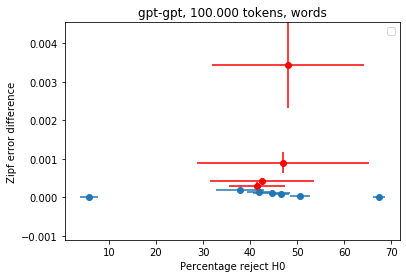

In [1786]:
perc_error(gpt_gpt_1000[0], "gpt", "gpt", "100.000", "words", save=True)

In [1525]:
web_gpt_100[2]

mean perc   std perc
Adjective 1-10     35.000000  14.337209
          11-20    21.000000  11.972190
          161-end   1.250000   2.795085
          21-40    23.500000   7.472171
          41-80    10.000000   4.249183
          81-160    4.250000   1.118034
          81-end    5.384817   3.649186
          total    10.918158   2.243411
Adverb    1-10     49.000000  17.919573
          11-20    23.000000  17.029386
          21-40    15.000000  10.000000
          41-end    7.220107   4.872122
          total    18.220486   6.296661
Noun      1-10     42.000000  18.737959
          11-20    31.000000  11.972190
          161-320   9.437500   2.967562
          21-40    25.000000   9.428090
          321-640   4.895833   1.661450
          321-end   6.170746   1.702804
          41-80    25.250000   5.329426
          641-end   4.365079   8.816314
          81-160   18.375000   3.586723
          total    11.365892   2.244390
Verb      1-10     52.000000  20.439613
          11-20    44.000000  17.763883
          161-320   4.500000   1.280869
          161-end   5.760772   1.787541
          21-40    35.500000   8.959787
          321-end   1.717949   2.889028
          41-80    21.250000   6.038074
          81-160    8.375000   2.128673
          total    12.607427   2.896762

In [1015]:
web_web_100[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total      32.333381   2.004135              0.001431              0.000477   
1-10       41.000000  17.919573              0.009605              0.011230   
11-20      49.000000   9.944289              0.003246              0.002374   
21-40      40.500000  13.426756              0.001520              0.001136   
41-80      45.250000  12.159244              0.001263              0.000531   
81-160     56.250000   4.859127              0.001008              0.000366   
161-320    63.187500   4.294396              0.000679              0.000269   
321-640    71.937500   3.726198              0.000465              0.000202   
641-1280   78.843750   2.918712                   NaN              0.000122   
1281-2560   7.750000   3.212702                   NaN              0.000039   
2561-end    0.000000   0.000000                   NaN                   NaN   

           std reject H0  std accept H0  
total           0.000471       0.000139  
1-10            0.005648       0.007811  
11-20           0.001759       0.000850  
21-40           0.000232       0.000266  
41-80           0.000246       0.000085  
81-160          0.000089       0.000050  
161-320         0.000056       0.000017  
321-640         0.000033       0.000010  
641-1280             NaN       0.000011  
1281-2560            NaN       0.000011  
2561-end             NaN            NaN

In [1016]:
gpt_gpt_100[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total     35.009531   1.440612              0.001538              0.000471   
1-10      48.000000  12.292726              0.012651              0.009977   
11-20     49.000000  17.288403              0.002812              0.001609   
21-40     47.000000  12.064641              0.001168              0.001231   
41-80     48.750000   8.100926              0.001322              0.000768   
81-160    50.750000   5.839283              0.001128              0.000417   
161-320   58.312500   6.884778              0.000753              0.000292   
321-640   66.187500   2.638523              0.000459              0.000199   
641-1280  55.906250   5.214996                   NaN              0.000096   
1281-end   0.000000   0.000000                   NaN              0.000014   

          std reject H0  std accept H0  
total          0.000301       0.000097  
1-10           0.004333       0.003980  
11-20          0.001403       0.000645  
21-40          0.000323       0.000226  
41-80          0.000308       0.000146  
81-160         0.000088       0.000026  
161-320        0.000035       0.000026  
321-640        0.000025       0.000016  
641-1280            NaN       0.000012  
1281-end            NaN       0.000006

### Comparing ranks

In [1017]:
web_gpt_100[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total     14.037114   1.820992              0.001142              0.000232   
1-10      53.000000  12.688578              0.007600              0.008579   
11-20     51.818182  22.654429              0.001748              0.001416   
21-40     43.333333  19.101115              0.001682              0.000845   
41-80     43.658537   9.024390              0.001748              0.000556   
81-160    32.716049   7.203997              0.001231              0.000412   
161-320   23.913043   3.301288              0.000856              0.000279   
321-640   12.211838   2.188681              0.000663              0.000176   
641-end    6.291752   0.951650              0.000558              0.000144   
641-1280   5.980239   1.814120              0.000600              0.000134   
1281-end   2.421533   1.512326              0.000504              0.000097   

          std reject H0  std accept H0  
total          0.000173       0.000023  
1-10           0.004559       0.004625  
11-20          0.000840       0.000503  
21-40          0.000645       0.000291  
41-80          0.000388       0.000096  
81-160         0.000085       0.000030  
161-320        0.000073       0.000036  
321-640        0.000053       0.000007  
641-end        0.000017       0.000011  
641-1280       0.000033       0.000011  
1281-end       0.000146       0.000044

In [1018]:
web_web_100[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total     10.756254   1.047472              0.001004              0.000195   
1-10      35.000000  16.278821              0.008438              0.005141   
11-20     38.181818  12.727273              0.001401              0.001717   
21-40     30.000000   6.751165              0.001753              0.000853   
41-80     31.463415   4.146341              0.001761              0.000506   
81-160    27.530864   6.074526              0.001186              0.000367   
161-320   23.229814   1.987578              0.000807              0.000257   
321-640   13.551402   1.408775              0.000677              0.000175   
641-1280   6.318253   0.894149              0.000580              0.000133   
1281-end   3.796460   0.837828              0.000594              0.000115   

          std reject H0  std accept H0  
total          0.000121       0.000019  
1-10           0.007126       0.001860  
11-20          0.000742       0.000444  
21-40          0.000615       0.000217  
41-80          0.000231       0.000096  
81-160         0.000154       0.000028  
161-320        0.000036       0.000017  
321-640        0.000055       0.000007  
641-1280       0.000043       0.000004  
1281-end       0.000094       0.000009

In [1019]:
gpt_gpt_100[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total     13.473473   2.072371              0.001204              0.000235   
1-10      43.000000  14.866069              0.008349              0.005736   
11-20     30.000000  13.514608              0.001073              0.001302   
21-40     32.857143  11.358915              0.002149              0.000845   
41-80     37.560976   9.203884              0.001899              0.000631   
81-160    29.629630   5.603361              0.001280              0.000428   
161-320   23.105590   4.052051              0.000893              0.000276   
321-640   12.990654   1.778977              0.000677              0.000174   
641-end    5.770681   0.870853              0.000592              0.000131   
641-1280   4.992200   0.994858              0.000707              0.000129   
1281-end   0.757576   1.071374              0.000490              0.000110   

          std reject H0  std accept H0  
total          0.000163       0.000020  
1-10           0.005221       0.001943  
11-20          0.000497       0.000476  
21-40          0.000578       0.000179  
41-80          0.000264       0.000096  
81-160         0.000125       0.000026  
161-320        0.000069       0.000018  
321-640        0.000046       0.000011  
641-end        0.000026       0.000004  
641-1280       0.000069       0.000003  
1281-end       0.000000       0.000010

### Comparing PoS ranks

In [1420]:
web_gpt_100[2].sort_index()

mean perc   std perc
Adjective 1-10     30.000000  14.907120
          11-20    27.000000  15.670212
          161-end   4.758621   5.140129
          21-40    15.000000   7.071068
          41-80    11.000000   6.032320
          81-160    5.750000   4.558646
          81-end    6.159288   2.930128
          total    11.097146   3.087383
Adverb    1-10     49.000000  15.951315
          11-20    35.000000  22.236107
          21-40    15.000000   5.270463
          41-end    6.255761   5.884856
          total    19.472551   5.336055
Noun      1-10     38.000000  23.944380
          11-20    24.000000  10.749677
          161-320  10.625000   2.144923
          21-40    26.500000  10.013879
          321-640   6.666667   1.603625
          321-end   5.487273   2.064743
          41-80    26.750000   7.173446
          641-end   1.550388   2.685350
          81-160   16.250000   3.173239
          total    11.717799   1.897177
Verb      1-10     50.000000  17.638342
          11-20    43.000000  20.027759
          161-320   3.437500   1.572882
          161-end   3.684955   1.901120
          21-40    40.000000  11.055416
          321-end   2.948403   4.288625
          41-80    22.000000   5.986095
          81-160    9.750000   2.108185
          total    12.835729   2.836247

In [1421]:
web_web_100[2].sort_index()

mean perc   std perc
Adjective 1-10     32.000000   9.189366
          11-20    24.000000  16.465452
          161-end   3.122093   2.738464
          21-40    17.000000   7.149204
          41-80    10.500000   3.689324
          81-160    5.500000   3.343734
          total     8.871964   2.339282
Adverb    1-10     29.000000  14.491377
          11-20    28.000000  10.327956
          21-40    17.000000   9.486833
          41-80     9.250000   3.129164
          81-end    2.453704   5.256210
          total    14.290782   2.850159
Noun      1-10     27.000000  12.516656
          11-20    28.000000  13.165612
          161-320  12.750000   4.489571
          21-40    27.500000  10.341395
          321-640   6.250000   0.988212
          41-80    22.500000   7.071068
          641-end   3.576443   1.413668
          81-160   17.375000   3.653860
          total     9.659857   1.147907
Verb      1-10     43.000000  13.374935
          11-20    30.000000   8.164966
          161-320   4.187500   1.641741
          21-40    22.000000   6.749486
          321-end   2.112480   2.331660
          41-80    15.500000   4.972145
          81-160   10.375000   3.007514
          total     9.023696   1.091738

In [1022]:
gpt_gpt_100[2]

mean perc   std perc
Adjective 1-10     28.000000  16.865481
          11-20    31.000000  26.012817
          161-end   2.838164   2.459591
          21-40    23.000000   7.888106
          41-80    11.250000   3.173239
          81-160    6.250000   2.700309
          81-end    4.605570   2.302025
          total    11.998817   1.895746
Adverb    1-10     40.000000  18.257419
          11-20    25.000000  17.159384
          21-40    16.000000   8.755950
          41-end    8.618143   6.561091
          total    18.173239   7.296562
Noun      1-10     36.000000  18.378732
          11-20    31.000000  11.972190
          161-320   9.187500   2.125613
          21-40    26.500000   7.472171
          321-end   4.350647   1.549563
          41-80    24.500000   8.147938
          81-160   15.500000   4.377975
          total    11.076956   1.220075
Verb      1-10     34.000000  14.298407
          11-20    36.000000  12.649111
          161-320   3.125000   1.767767
          161-end   4.700283   2.034830
          21-40    23.500000   7.472171
          321-end   0.000000   0.000000
          41-80    20.250000   6.395528
          81-160   13.125000   4.973890
          total    12.169815   2.050750

## Readable stats 100.000 tokens (10 x 10.000)

In [1503]:
web_gpt_1000 = readable_stats(web_train_20000[0:1000], gpt_train_20000[0:1000], times=10, n=10, t=0, norm=True)

In [1504]:
web_web_1000 = readable_stats(web_train_20000[0:1000], web_train_20000[1000:2000], times=10, n=10, t=0, norm=True)

In [1505]:
gpt_gpt_1000 = readable_stats(gpt_train_20000[0:1000], gpt_train_20000[1000:2000], times=10, n=10, t=0, norm=True)

In [995]:
bloep = readable_stats(web_train_20000[0:1000], gpt_train_20000[0:1000], times=10, n=10, t=0, norm=True)

### Comparing individual words

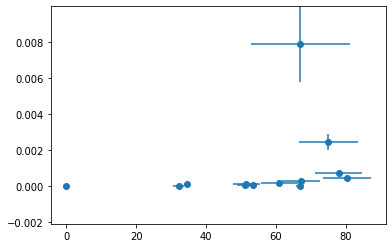

In [1510]:
perc_error(web_gpt_1000[0])

In [1003]:
web_web_1000[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total       32.384861   0.963870              0.000137              0.000041   
1-10        38.000000  21.499354              0.006474              0.003152   
11-20       44.000000   9.660918              0.001680              0.001081   
21-40       41.500000   8.181958              0.000549              0.000480   
41-80       39.750000   9.678872              0.000210              0.000219   
81-160      37.125000   3.866254              0.000160              0.000175   
161-320     40.062500   4.597044              0.000146              0.000103   
321-640     42.906250   3.227654              0.000142              0.000058   
641-1280    46.625000   2.811728              0.000117              0.000042   
1281-2560   49.515625   1.425790              0.000080              0.000030   
2561-5120   59.246094   1.655956              0.000051              0.000021   
5121-10240  57.875000   3.343260                   NaN              0.000011   
10241-end    0.000000   0.000000                   NaN              0.000001   

            std reject H0  std accept H0  
total        2.336562e-05   6.263892e-06  
1-10         5.406557e-03   2.167563e-03  
11-20        7.665458e-04   2.003960e-04  
21-40        2.781470e-04   9.984883e-05  
41-80        4.602513e-05   4.054804e-05  
81-160       2.738037e-05   4.849935e-05  
161-320      1.443523e-05   1.109581e-05  
321-640      6.861863e-06   3.668449e-06  
641-1280     3.223789e-06   2.423867e-06  
1281-2560    1.136046e-06   7.106437e-07  
2561-5120    7.117643e-07   4.045540e-07  
5121-10240            NaN   3.259144e-07  
10241-end             NaN   9.460547e-08

In [1004]:
gpt_gpt_1000[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total      33.735046   1.217201              0.000153              0.000048   
1-10       46.000000  14.298407              0.003824              0.002934   
11-20      51.000000   8.755950              0.001059              0.000957   
21-40      37.500000   6.770032              0.000429              0.000371   
41-80      44.000000   5.797509              0.000335              0.000286   
81-160     38.750000   4.526159              0.000268              0.000153   
161-320    41.937500   3.902568              0.000178              0.000104   
321-640    44.187500   3.551457              0.000157              0.000061   
641-1280   46.546875   1.946621              0.000119              0.000042   
1281-2560  50.906250   1.594805              0.000072              0.000027   
2561-5120  67.332031   1.457641              0.000042              0.000016   
5121-end    6.510506   2.136484                   NaN              0.000004   

           std reject H0  std accept H0  
total           0.000015   3.346623e-06  
1-10            0.001558   1.063838e-03  
11-20           0.000320   2.903427e-04  
21-40           0.000124   8.231257e-05  
41-80           0.000064   9.109717e-05  
81-160          0.000085   2.908189e-05  
161-320         0.000023   7.050586e-06  
321-640         0.000006   4.904786e-06  
641-1280        0.000005   2.032854e-06  
1281-2560       0.000002   9.689068e-07  
2561-5120       0.000002   5.141698e-07  
5121-end             NaN   7.551618e-07

### Comparing ranks

In [1005]:
bloep[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total      18.483664   1.056315              0.000186              0.000030   
1-10       73.000000  15.524175              0.005083              0.005426   
11-20      88.181818  12.888588              0.002032              0.001420   
21-40      80.952381  10.647943              0.000706              0.000657   
41-80      87.804878   7.712872              0.000501              0.000266   
81-160     68.271605   4.059082              0.000363              0.000140   
161-320    44.782609   4.170751              0.000223              0.000076   
321-640    31.993769   2.194217              0.000180              0.000063   
641-1280   27.269891   1.314162              0.000126              0.000043   
1281-2560  23.411397   1.850446              0.000087              0.000028   
2561-5120  11.593128   0.902566              0.000070              0.000018   
5121-end    6.921068   0.484242              0.000061              0.000015   

           std reject H0  std accept H0  
total           0.000016   2.689566e-06  
1-10            0.000781   2.520384e-03  
11-20           0.000320   4.928062e-04  
21-40           0.000102   2.485095e-04  
41-80           0.000069   9.646403e-05  
81-160          0.000029   3.030961e-05  
161-320         0.000019   1.067529e-05  
321-640         0.000016   9.626275e-06  
641-1280        0.000007   1.838580e-06  
1281-2560       0.000003   1.612597e-06  
2561-5120       0.000003   7.163724e-07  
5121-end        0.000002   1.091746e-06

In [1006]:
web_web_1000[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total       12.374572   0.704680              0.000112              0.000023   
1-10        41.000000  21.189620              0.004747              0.002272   
11-20       29.090909  13.965720              0.000613              0.000624   
21-40       30.476190   8.571429              0.000516              0.000280   
41-80       26.585366   6.937299              0.000269              0.000125   
81-160      27.777778   5.978420              0.000199              0.000091   
161-320     29.751553   3.023129              0.000211              0.000072   
321-640     30.872274   2.815655              0.000172              0.000056   
641-1280    27.722309   2.814216              0.000125              0.000043   
1281-2560   23.809524   1.483627              0.000089              0.000029   
2561-5120   13.713393   0.871690              0.000071              0.000019   
5121-10240   5.592658   0.428733              0.000059              0.000014   
10241-end    3.160643   0.659280              0.000053              0.000012   

            std reject H0  std accept H0  
total            0.000008   1.177611e-06  
1-10             0.003268   1.116725e-03  
11-20            0.000233   1.897759e-04  
21-40            0.000110   5.936467e-05  
41-80            0.000039   1.222935e-05  
81-160           0.000033   1.499601e-05  
161-320          0.000011   5.343125e-06  
321-640          0.000007   7.018519e-06  
641-1280         0.000007   3.537093e-06  
1281-2560        0.000002   1.099202e-06  
2561-5120        0.000003   7.751062e-07  
5121-10240       0.000002   4.566883e-07  
10241-end        0.000004   5.100294e-07

In [1007]:
gpt_gpt_1000[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total      14.466566   0.402865              0.000136              0.000029   
1-10       45.000000   9.219544              0.002427              0.002245   
11-20      42.727273   9.136251              0.000727              0.000628   
21-40      29.047619  10.952381              0.000516              0.000263   
41-80      31.707317   7.397927              0.000511              0.000185   
81-160     23.950617   4.423820              0.000356              0.000128   
161-320    26.894410   3.056128              0.000267              0.000088   
321-640    29.283489   3.061847              0.000187              0.000064   
641-1280   26.240250   1.436274              0.000129              0.000044   
1281-2560  21.459797   1.302266              0.000085              0.000027   
2561-5120   8.816868   0.506953              0.000066              0.000016   
5121-end    4.098832   0.714965              0.000057              0.000013   

           std reject H0  std accept H0  
total           0.000006   1.018354e-06  
1-10            0.001442   9.080485e-04  
11-20           0.000220   2.456211e-04  
21-40           0.000129   5.645004e-05  
41-80           0.000041   1.907145e-05  
81-160          0.000029   1.159898e-05  
161-320         0.000036   1.017985e-05  
321-640         0.000009   1.240244e-05  
641-1280        0.000006   2.681380e-06  
1281-2560       0.000004   1.973491e-06  
2561-5120       0.000003   4.648906e-07  
5121-end        0.000004   6.919502e-07

### PoS classes ranks

In [1422]:
bloep[2].sort_index()

mean perc   std perc
Adjective 1-10       84.000000   9.660918
          11-20      69.000000  19.119507
          161-320    22.562500   3.039811
          21-40      41.500000  10.554093
          321-640    10.000000   1.223681
          41-80      28.750000   7.192782
          641-end     6.122589   1.764928
          81-160     27.500000   4.639804
          total      16.496113   0.682665
Adverb    1-10       84.000000  15.055453
          11-20      52.000000  16.193277
          161-end    12.475618   4.831214
          21-40      35.000000  15.634719
          41-80      34.500000   5.109903
          81-160     23.375000   5.304937
          total      27.915031   3.067584
Noun      1-10       90.000000  16.996732
          11-20      82.000000  11.352924
          1281-2560  13.796875   0.531403
          161-320    31.250000   5.636562
          21-40      52.500000  12.304019
          2561-end    7.432287   0.479197
          321-640    26.156250   3.554053
          41-80      35.750000   7.364517
          641-1280   23.906250   2.115635
          81-160     29.125000   4.604120
          total      17.668589   1.057504
Verb      1-10       77.000000   9.486833
          11-20      97.000000   4.830459
          1281-end    5.581260   2.701415
          161-320    25.937500   2.521608
          21-40      81.000000   6.582806
          321-640    18.781250   2.187252
          41-80      58.500000   9.442810
          641-1280    9.500000   1.212099
          81-160     38.000000   6.800735
          total      18.584895   1.326580

In [1423]:
web_web_1000[2].sort_index()

mean perc   std perc
Adjective 1-10       32.000000  15.491933
          11-20      30.000000  17.638342
          1281-end    2.792157   0.989840
          161-320    23.687500   3.313090
          21-40      35.500000   3.689324
          321-640    12.125000   1.832860
          41-80      32.250000   5.827378
          641-1280    5.171875   0.479902
          81-160     29.000000   4.958158
          total      11.494548   0.971560
Adverb    1-10       28.000000  12.292726
          11-20      31.000000  15.238839
          161-320     9.875000   2.099934
          21-40      35.000000  11.055416
          321-end     4.428305   4.869674
          41-80      31.750000   8.083763
          81-160     19.875000   2.913689
          total      16.709853   2.269293
Noun      1-10       30.000000  16.329932
          11-20      28.000000  16.193277
          1281-2560  15.617188   1.589801
          161-320    29.000000   2.919641
          21-40      32.500000  11.843892
          2561-5120   6.882812   0.858546
          321-640    26.937500   2.490433
          41-80      24.750000   9.238356
          5121-end    3.627283   0.453423
          641-1280   23.984375   1.935160
          81-160     31.750000   3.238227
          total      12.422281   1.076961
Verb      1-10       38.000000  13.984118
          11-20      27.000000  18.885621
          1281-end    4.636558   0.491762
          161-320    25.125000   3.593976
          21-40      32.500000  10.606602
          321-640    19.687500   1.121909
          41-80      33.750000   6.897061
          641-1280   10.078125   1.248371
          81-160     31.750000   4.758034
          total      11.729624   0.358647

In [1424]:
gpt_gpt_1000[2].sort_index()

mean perc   std perc
Adjective 1-10       27.000000  16.363917
          11-20      33.000000  14.944341
          161-320    20.250000   2.703521
          21-40      28.500000  14.729034
          321-640     8.093750   1.623463
          41-80      32.250000   7.016845
          641-end     3.807969   2.017983
          81-160     26.125000   6.022239
          total      13.606444   1.153141
Adverb    1-10       33.000000  14.181365
          11-20      24.000000  15.776213
          161-end     5.918498   2.784707
          21-40      29.500000  10.916349
          41-80      26.250000   5.170697
          81-160     17.500000   3.864008
          total      18.438777   2.761752
Noun      1-10       30.000000  10.540926
          11-20      26.000000  18.973666
          1281-2560   9.796875   0.821201
          161-320    29.750000   3.148523
          21-40      24.500000  10.916349
          2561-end    4.460539   0.958473
          321-640    25.375000   2.257318
          41-80      27.250000   4.322101
          641-1280   21.640625   1.645784
          81-160     28.500000   5.130248
          total      14.216535   0.703041
Verb      1-10       35.000000  19.002924
          11-20      38.000000  14.757296
          1281-end    4.446065   2.170714
          161-320    25.812500   3.808001
          21-40      25.500000   5.986095
          321-640    19.312500   1.838770
          41-80      27.000000   8.062258
          641-1280    7.343750   1.303125
          81-160     27.375000   4.910660
          total      14.519170   0.900143

## 1.000.000 tokens (10 x 100.000)

In [1125]:
web_gpt_10000 = readable_stats(web_train_20000[0:10000], gpt_train_20000[0:10000], times=10, n=10, t=0, norm=True)

In [1126]:
web_web_10000 = readable_stats(web_train_20000[0:10000], web_train_20000[10000:20000], times=10, n=10, t=0, norm=True)

In [1127]:
gpt_gpt_10000 = readable_stats(gpt_train_20000[0:10000], gpt_train_20000[10000:20000], times=10, n=10, t=0, norm=True)

### Comparing individual words

In [1128]:
web_gpt_10000[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total        38.518997   0.461249              0.000039          7.319326e-06   
1-10         80.000000  10.540926              0.007396          7.985762e-03   
11-20        81.000000   7.378648              0.001566          3.044080e-03   
21-40        96.500000   2.415229              0.000437          7.979242e-04   
41-80        92.500000   3.333333              0.000609          4.886457e-04   
81-160       87.875000   4.126894              0.000335          3.008453e-04   
161-320      82.375000   2.548147              0.000136          1.378490e-04   
321-640      70.906250   2.657577              0.000054          4.550190e-05   
641-1280     58.953125   1.228217              0.000027          1.654382e-05   
1281-2560    57.031250   1.250000              0.000022          9.349706e-06   
2561-5120    57.753906   1.483490              0.000018          6.103528e-06   
5121-10240   59.740234   1.793004              0.000012          4.052262e-06   
10241-20480  66.240234   1.062974              0.000006          2.458344e-06   
20481-40960  51.937012   1.360804                   NaN          9.351078e-07   
40961-end     0.000000   0.000000                   NaN          3.888318e-07   

             std reject H0  std accept H0  
total         3.670268e-06   1.044495e-06  
1-10          1.932640e-03   2.285013e-03  
11-20         3.568538e-04   8.304956e-04  
21-40         7.026299e-05   3.664664e-04  
41-80         3.789433e-05   5.393225e-05  
81-160        1.032694e-05   4.567133e-05  
161-320       3.677998e-06   2.778692e-05  
321-640       3.007916e-06   3.327536e-06  
641-1280      1.175060e-06   9.875111e-07  
1281-2560     5.177237e-07   3.240603e-07  
2561-5120     3.604171e-07   1.744442e-07  
5121-10240    1.647741e-07   1.567281e-07  
10241-20480   5.399050e-08   3.373317e-08  
20481-40960            NaN   3.223646e-08  
40961-end              NaN   2.357861e-08

In [1129]:
web_web_10000[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total        32.060346   0.381099              0.000015          4.567834e-06   
1-10         41.000000  17.919573              0.002739          1.413565e-03   
11-20        45.000000  23.687784              0.000568          4.703960e-04   
21-40        38.000000   5.868939              0.000169          1.522590e-04   
41-80        40.500000   7.975657              0.000065          5.856181e-05   
81-160       33.500000   6.202598              0.000032          3.179933e-05   
161-320      37.625000   3.156783              0.000031          2.866063e-05   
321-640      38.531250   3.480009              0.000025          2.275025e-05   
641-1280     38.140625   2.496145              0.000022          1.464699e-05   
1281-2560    38.570312   1.329936              0.000019          9.400633e-06   
2561-5120    40.765625   1.216483              0.000017          6.246897e-06   
5121-10240   43.531250   1.043366              0.000012          4.122381e-06   
10241-20480  48.458984   0.672463              0.000007          2.660646e-06   
20481-40960  70.497559   0.758643              0.000004          1.488894e-06   
40961-end     4.999987   0.549009                   NaN          3.768031e-07   

             std reject H0  std accept H0  
total         1.923088e-06   3.164711e-07  
1-10          2.971036e-03   1.583460e-03  
11-20         3.298879e-04   4.002213e-04  
21-40         5.249423e-05   5.135277e-05  
41-80         1.337159e-05   1.237163e-05  
81-160        8.042612e-06   5.577929e-06  
161-320       4.663163e-06   1.835659e-06  
321-640       2.360057e-06   1.683067e-06  
641-1280      9.913758e-07   6.399537e-07  
1281-2560     6.683644e-07   3.448434e-07  
2561-5120     2.803561e-07   2.114174e-07  
5121-10240    1.512381e-07   6.037415e-08  
10241-20480   5.868028e-08   3.257245e-08  
20481-40960   4.914837e-08   1.257470e-08  
40961-end              NaN   2.129258e-08

In [1130]:
gpt_gpt_10000[0]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total        33.040629   0.378497              0.000019          6.081889e-06   
1-10         46.000000  17.763883              0.001607          1.767449e-03   
11-20        42.000000  24.404007              0.000451          3.147012e-04   
21-40        43.000000  11.832160              0.000191          1.948832e-04   
41-80        47.750000   7.857233              0.000108          8.764972e-05   
81-160       39.875000   4.910660              0.000075          4.744575e-05   
161-320      39.125000   2.520747              0.000046          3.095537e-05   
321-640      42.000000   2.135798              0.000037          2.135166e-05   
641-1280     40.984375   1.816283              0.000028          1.429423e-05   
1281-2560    41.140625   1.761310              0.000021          8.813750e-06   
2561-5120    43.128906   0.903884              0.000015          5.477213e-06   
5121-10240   46.642578   0.870375              0.000008          3.237501e-06   
10241-20480  63.463867   0.610177              0.000004          1.390656e-06   
20481-end     8.480423   1.000939                   NaN          2.558954e-07   

             std reject H0  std accept H0  
total         2.091303e-06   5.801726e-07  
1-10          1.020208e-03   1.508753e-03  
11-20         2.815433e-04   1.055812e-04  
21-40         4.354994e-05   4.885183e-05  
41-80         1.814751e-05   2.037709e-05  
81-160        8.336318e-06   1.324866e-05  
161-320       4.717177e-06   5.777043e-06  
321-640       3.024208e-06   4.062558e-06  
641-1280      1.779405e-06   9.598616e-07  
1281-2560     4.283392e-07   1.926636e-07  
2561-5120     2.885489e-07   1.694926e-07  
5121-10240    1.246740e-07   6.951037e-08  
10241-20480   6.795232e-08   2.730898e-08  
20481-end              NaN   8.278170e-09

### Comparing ranks

In [1131]:
web_gpt_10000[1]

mean perc   std perc  mean error reject H0  \
total         26.942140   1.127953              0.000033   
1-10          86.000000  10.198039              0.004755   
11-20        100.000000   0.000000              0.001572   
21-40        100.000000   0.000000              0.000467   
41-80        100.000000   0.000000              0.000618   
81-160        99.629630   0.565750              0.000326   
161-320       89.875776   2.561688              0.000148   
321-640       46.666667   4.139436              0.000075   
641-1280      24.867395   1.615550              0.000039   
1281-2560     32.419984   2.326268              0.000025   
2561-5120     39.449434   2.624315              0.000019   
5121-10240    40.115212   2.684622              0.000012   
10241-20480   22.308368   0.539187              0.000008   
20481-end      9.682776   0.483269              0.000006   

             mean error accept H0  std reject H0  std accept H0  
total                    0.000004   1.840810e-06   4.853272e-07  
1-10                     0.007136   1.584651e-03   2.719083e-03  
11-20                         NaN   1.023543e-04            NaN  
21-40                         NaN   3.142155e-05            NaN  
41-80                         NaN   3.305558e-05            NaN  
81-160                   0.000100   1.350660e-05   7.600387e-05  
161-320                  0.000051   3.317116e-06   6.778004e-06  
321-640                  0.000028   3.795596e-06   1.712134e-06  
641-1280                 0.000014   1.962119e-06   7.262942e-07  
1281-2560                0.000009   6.756821e-07   2.887958e-07  
2561-5120                0.000006   6.881249e-07   3.473503e-07  
5121-10240               0.000004   3.063625e-07   2.719703e-07  
10241-20480              0.000002   1.074859e-07   1.049471e-07  
20481-end                0.000002   1.395501e-07   4.653497e-08

In [1132]:
web_web_10000[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total        13.642965   0.219934              0.000014              0.000003   
1-10         38.000000  16.000000              0.001871              0.001473   
11-20        39.090909  25.078389              0.000283              0.000309   
21-40        35.238095  10.900498              0.000172              0.000095   
41-80        28.048780   8.810923              0.000084              0.000042   
81-160       23.456790   4.131654              0.000043              0.000025   
161-320      24.223602   3.838891              0.000043              0.000020   
321-640      23.084112   2.082573              0.000047              0.000017   
641-1280     23.759750   1.877333              0.000036              0.000012   
1281-2560    26.799375   1.605938              0.000026              0.000009   
2561-5120    29.964857   1.011497              0.000020              0.000006   
5121-10240   27.063074   0.731508              0.000013              0.000004   
10241-20480  20.576116   0.263205              0.000008              0.000003   
20481-40960   8.184171   0.207182              0.000006              0.000002   
40961-end     3.744316   0.334020              0.000006              0.000001   

             std reject H0  std accept H0  
total         1.373075e-06   2.146597e-07  
1-10          2.119353e-03   2.056242e-03  
11-20         1.834200e-04   1.415499e-04  
21-40         4.402946e-05   1.646921e-05  
41-80         2.127020e-05   7.397098e-06  
81-160        1.068732e-05   2.404938e-06  
161-320       5.597017e-06   1.198178e-06  
321-640       2.912296e-06   1.347804e-06  
641-1280      3.194266e-06   2.570624e-07  
1281-2560     5.608927e-07   1.923234e-07  
2561-5120     2.194048e-07   1.272757e-07  
5121-10240    1.696825e-07   1.157237e-07  
10241-20480   1.089791e-07   4.706710e-08  
20481-40960   7.417562e-08   2.374657e-08  
40961-end     1.195831e-07   2.718245e-08

In [1133]:
gpt_gpt_10000[1]

mean perc   std perc  mean error reject H0  mean error accept H0  \
total        14.997403   0.242674              0.000017              0.000004   
1-10         43.000000  14.866069              0.001196              0.001024   
11-20        36.363636  17.721444              0.000222              0.000268   
21-40        37.142857  11.625291              0.000162              0.000118   
41-80        35.365854   6.289657              0.000156              0.000066   
81-160       29.629630   3.312693              0.000111              0.000040   
161-320      22.857143   4.210795              0.000073              0.000027   
321-640      22.523364   1.576521              0.000053              0.000019   
641-1280     24.648986   1.896615              0.000037              0.000013   
1281-2560    26.885246   1.534191              0.000025              0.000009   
2561-5120    28.219446   1.557398              0.000017              0.000006   
5121-10240   23.372388   0.553109              0.000009              0.000003   
10241-20480   9.923836   0.257908              0.000006              0.000001   
20481-end     4.004077   0.293021              0.000006              0.000001   

             std reject H0  std accept H0  
total         8.353749e-07   1.083771e-07  
1-10          5.620675e-04   4.644888e-04  
11-20         1.010966e-04   3.451449e-05  
21-40         5.146744e-05   1.831069e-05  
41-80         9.555462e-06   8.321306e-06  
81-160        1.053288e-05   5.010665e-06  
161-320       6.728299e-06   1.577749e-06  
321-640       2.333485e-06   9.030727e-07  
641-1280      1.185989e-06   7.723919e-07  
1281-2560     6.817868e-07   4.075999e-07  
2561-5120     4.797627e-07   3.584801e-07  
5121-10240    2.731322e-07   1.177864e-07  
10241-20480   2.694994e-07   9.490014e-08  
20481-end     4.793096e-07   1.110814e-07

### Comparing PoS ranks

In [1427]:
web_gpt_10000[2].sort_index()

mean perc   std perc
Adjective 1-10         99.000000   3.162278
          11-20       100.000000   0.000000
          1281-2560    18.093750   1.778171
          161-320      36.125000   4.446831
          21-40        92.500000   7.546154
          2561-end      7.718258   0.532501
          321-640      41.281250   2.846820
          41-80        60.000000   8.498366
          641-1280     36.640625   2.718580
          81-160       30.250000   5.027701
          total        22.451125   1.189360
Adverb    1-10        100.000000   0.000000
          11-20       100.000000   0.000000
          161-320      62.812500   4.595155
          21-40        51.500000   5.797509
          321-end      27.191924   3.617502
          41-80        50.500000  10.192590
          81-160       69.125000   4.528076
          total        47.716611   3.260185
Noun      1-10        100.000000   0.000000
          10241-end    12.592332   1.007320
          11-20       100.000000   0.000000
          1281-2560    37.726562   2.445547
          161-320      33.500000   4.860913
          21-40        99.500000   1.581139
          2561-5120    41.121094   4.043930
          321-640      23.937500   1.811422
          41-80        81.250000   9.372685
          5121-10240   29.423828   1.476652
          641-1280     32.078125   2.051911
          81-160       55.875000   8.396635
          total        27.674727   1.606830
Verb      1-10        100.000000   0.000000
          11-20       100.000000   0.000000
          1281-2560    36.750000   2.719379
          161-320      35.687500   3.260267
          21-40       100.000000   0.000000
          2561-end     17.841628   1.274605
          321-640      29.218750   2.842242
          41-80        99.750000   0.790569
          641-1280     37.062500   3.161935
          81-160       82.375000   6.303934
          total        29.629125   1.482788

In [1429]:
web_web_10000[2].sort_index()

mean perc   std perc
Adjective 1-10         37.000000  14.181365
          11-20        30.000000  14.907120
          1281-2560    18.679688   0.912165
          161-320      29.062500   3.977476
          21-40        21.500000  10.287533
          2561-5120     7.421875   0.590693
          321-640      30.906250   2.595611
          41-80        25.250000   7.402139
          5121-end      3.682688   0.512590
          641-1280     26.890625   1.670650
          81-160       25.750000   6.015027
          total        11.791323   0.249026
Adverb    1-10         34.000000  19.550504
          11-20        28.000000  18.135294
          161-320      31.562500   3.832994
          21-40        26.500000   9.143911
          321-640      19.562500   2.560890
          41-80        24.750000   7.115125
          641-end       6.428496   0.902416
          81-160       27.375000   4.101575
          total        16.207088   1.054340
Noun      1-10         36.000000  13.498971
          10241-20480  11.142578   0.451783
          11-20        26.000000  15.776213
          1281-2560    29.898438   1.095020
          161-320      24.250000   2.140872
          20481-end     4.446819   0.311170
          21-40        24.500000   9.264628
          2561-5120    28.105469   0.850501
          321-640      25.843750   1.840245
          41-80        26.000000   6.582806
          5121-10240   23.382812   0.549025
          641-1280     26.468750   2.517517
          81-160       21.750000   4.174992
          total        14.041689   0.291072
Verb      1-10         36.000000  13.498971
          11-20        30.000000  13.333333
          1281-2560    26.257812   1.383129
          161-320      23.500000   2.188988
          21-40        31.000000  11.737878
          2561-5120    17.367188   0.645077
          321-640      28.093750   1.928912
          41-80        24.250000   2.371708
          5121-end      6.179314   0.384345
          641-1280     29.984375   1.372966
          81-160       22.500000   6.236096
          total        14.950968   0.268785

In [1430]:
gpt_gpt_10000[2].sort_index()

mean perc   std perc
Adjective 1-10        45.000000  15.811388
          11-20       23.000000  14.181365
          1281-2560    9.390625   0.586718
          161-320     27.437500   3.528776
          21-40       29.000000   9.944289
          2561-end     3.696391   0.590159
          321-640     28.437500   3.264258
          41-80       21.500000   6.582806
          641-1280    22.265625   1.824032
          81-160      25.125000   3.839216
          total       13.098018   0.821395
Adverb    1-10        46.000000  15.776213
          11-20       39.000000  12.866839
          161-320     23.437500   3.217384
          21-40       25.500000   8.316650
          321-end      7.563443   1.308525
          41-80       23.750000   6.795628
          81-160      28.000000   4.495368
          total       17.773845   1.310487
Noun      1-10        40.000000  15.634719
          10241-end    5.102446   0.365941
          11-20       32.000000  12.292726
          1281-2560   28.609375   1.770757
          161-320     23.500000   2.874698
          21-40       25.500000   6.851602
          2561-5120   25.242188   0.718816
          321-640     25.031250   2.480173
          41-80       24.750000   8.287373
          5121-10240  13.355469   0.436227
          641-1280    26.734375   1.678749
          81-160      20.625000   5.179085
          total       15.434657   0.357853
Verb      1-10        37.000000  13.374935
          11-20       40.000000  14.907120
          1281-2560   20.937500   1.803092
          161-320     24.812500   3.997069
          21-40       35.000000  16.158933
          2561-end     7.292922   0.539797
          321-640     28.250000   1.870365
          41-80       26.250000   3.952847
          641-1280    28.250000   2.011523
          81-160      22.875000   4.372023
          total       16.807849   0.545814

In [ ]:
# Divides a big corpus into "n" subcorpera and calculates the frequencies for each
# subcorpus. Returns a dataframe containing the frequencies by word and by rank.
def sample_corpora2(corpus, text, n=10, norm=True, subclasses=False):
    num_corp = len(corpus)
    corpus = [item for sublist in corpus for item in sublist]
    rank_corp, freq_corp = subsampling(corpus, k=num_corp*100, m=n)

    by_rank = pd.DataFrame()
    by_word = pd.DataFrame()

    ranks_freqs_df = ranks_freqs(rank_corp, freq_corp, text=text, norm=norm)
    ranks_freqs_df = fano_factor(ranks_freqs_df)
    ranks_freqs_df = zipfs_law(ranks_freqs_df, print_stats=False)
    ranks_freqs_df['Error'] = abs(ranks_freqs_df['Frequency'] - ranks_freqs_df['Estimated frequency'])
    ranks_freqs_df['Fano'] = abs(ranks_freqs_df['Fano'])
    ranks_freqs_df['Tot rank'] = ranks_freqs_df['Rank'].rank(method='first')
    
    by_ranks_pos = ranks_freqs_df.copy()
    by_ranks_pos.reset_index(inplace=True)

    if subclasses == False:
        by_ranks_pos['level_1'] = by_ranks_pos['level_1'].replace({'NN': 'Noun', 'NNS':'Noun', 
                                           'NNP':'Noun', 'VB':'Verb', 'VBD':'Verb', 
                                           'VBG':'Verb', 'VBN':'Verb', 'VBP':'Verb', 
                                          'VBZ':'Verb', 'JJ':'Adjective', 
                                           'JJR':'Adjective', 'JJS':'Adjective', 'RB':'Adverb',
                                          'RBR':'Adverb', 'RBS':'Adverb'})
    

    by_ranks_pos['PoS rank'] = by_ranks_pos.groupby('level_1')['Rank'].rank(method='first')
    by_ranks_pos = by_ranks_pos.set_index(['level_1', 'PoS rank'])
    
    if subclasses == False:
        classes = ['Noun', 'Verb', 'Adjective', 'Adverb']
    else:
        classes = ['NN', 'NNS', 'NNP', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
    
    by_ranks_pos = by_ranks_pos.loc[classes]
    by_ranks_pos = by_ranks_pos.filter(regex='c_frequency|Frequency|Error|Fano')
    by_ranks_pos = by_ranks_pos.rename(columns={"Frequency": "{} mean freq".format(text),
                                         "Error": "{} error".format(text),
                                         "Fano": "{} fano".format(text)})
    

    
    by_rank = ranks_freqs_df.filter(regex='Tot rank|c_frequency|Frequency|Error|Fano').set_index(['Tot rank'])
    by_rank = by_rank.rename(columns={"Frequency": "{} mean freq".format(text),
                                         "Error": "{} error".format(text),
                                         "Fano": "{} fano".format(text)})
    
    by_word = ranks_freqs_df.filter(regex='c_frequency|Frequency|Error|Fano')
    by_word = by_word.rename(columns={"Frequency": "{} mean freq".format(text),
                                         "Error": "{} error".format(text),
                                         "Fano": "{} fano".format(text)})

    by_word = by_word.sort_values(by=['{} mean freq'.format(text)], ascending=False)
    by_rank = by_rank.sort_values(by=['Tot rank'])
    by_ranks_pos = by_ranks_pos.sort_index(by=['level_1', 'PoS rank'])
    
    by_word = by_word.fillna(0)
    by_rank = by_rank.dropna()
    by_ranks_pos = by_ranks_pos.dropna()
    
    return by_word, by_rank, by_ranks_pos
#     return None

In [1207]:
# Divides a big corpus into "n" subcorpera and calculates the frequencies for each
# subcorpus. Returns a dataframe containing the frequencies by word and by rank.
def sample_corpora(corpus, n=10, norm=True, text=None):
    corpus_split = split_corpus(corpus, n)

    corpus_split = [[item for sublist in corpus for item in sublist] for corpus in corpus_split]
    corpus_split = [[item for sublist in corpus for item in sublist] for corpus in corpus_split]
    
    
    freqs = calculate_freqs(corpus_split, norm=norm, text=text)
    ranks = pd.DataFrame()
    pos = pd.DataFrame()
    
    for column in freqs:
        ok = pd.DataFrame()
        ok[column] = freqs[column]
        ok['rank'] = freqs[column].rank(ascending=False, method='first')
        ok = ok.set_index(['rank'])
        ranks = pd.concat([ranks, ok], axis=1)
        
    by_ranks_pos = freqs.copy()
    by_ranks_pos.reset_index(inplace=True)
#     print(by_ranks_pos)
    
    freqs_copy = freqs.copy()
    freqs_copy.reset_index(inplace=True)
    freqs_copy['level_1'] = freqs_copy['level_1'].replace({'NN': 'Noun', 'NNS':'Noun', 
                                       'NNP':'Noun', 'VB':'Verb', 'VBD':'Verb', 
                                       'VBG':'Verb', 'VBN':'Verb', 'VBP':'Verb', 
                                      'VBZ':'Verb', 'JJ':'Adjective', 
                                       'JJR':'Adjective', 'JJS':'Adjective', 'RB':'Adverb',
                                      'RBR':'Adverb', 'RBS':'Adverb'})
    
    for column in freqs_copy:
        if 'frequency' in column:
            ok = pd.DataFrame()
            ok['level_1'] = freqs_copy['level_1']
            ok['rank'] = freqs_copy.groupby('level_1')[column].rank(ascending = False, method='first')
            ok[column] = freqs_copy[column]
            ok = ok.set_index(['level_1', 'rank'])
            pos = pd.concat([pos, ok], axis=1)

    classes = ['Noun', 'Verb', 'Adjective', 'Adverb']
    
    pos = pos.loc[classes]
#     by_ranks_pos = by_ranks_pos.sort_index(by=['level_1'])
    
    
    return freqs, ranks, pos

In [1179]:
# # Divides a big corpus into "n" subcorpera and calculates the frequencies for each
# # subcorpus. Returns a dataframe containing the frequencies by word and by rank.
# def sample_corpora(corpus, n=10, norm=True, text=None):
#     corpus_split = split_corpus(corpus, n)

#     corpus_split = [[item for sublist in corpus for item in sublist] for corpus in corpus_split]
#     corpus_split = [[item for sublist in corpus for item in sublist] for corpus in corpus_split]
    
    
#     freqs = calculate_freqs(corpus_split, norm=norm, text=text)
#     ranks = pd.DataFrame(index=freqs.index)
#     for column in freqs:
#         ranks[column] = freqs[column].rank(ascending=False, method='first')
        
#     by_ranks_pos = freqs.copy()
#     by_ranks_pos.reset_index(inplace=True)
# #     print(by_ranks_pos)
    
    

#     by_ranks_pos['level_1'] = by_ranks_pos['level_1'].replace({'NN': 'Noun', 'NNS':'Noun', 
#                                            'NNP':'Noun', 'VB':'Verb', 'VBD':'Verb', 
#                                            'VBG':'Verb', 'VBN':'Verb', 'VBP':'Verb', 
#                                           'VBZ':'Verb', 'JJ':'Adjective', 
#                                            'JJR':'Adjective', 'JJS':'Adjective', 'RB':'Adverb',
#                                           'RBR':'Adverb', 'RBS':'Adverb'})
    
#     for column in freqs:
#         if 'frequency' in column:
#             by_ranks_pos[column] = by_ranks_pos.groupby('level_1')[column].rank(ascending = False, method='first')

#     by_ranks_pos = by_ranks_pos.set_index(['level_1'])
#     classes = ['Noun', 'Verb', 'Adjective', 'Adverb']
    
#     by_ranks_pos = by_ranks_pos.loc[classes]
# #     by_ranks_pos = by_ranks_pos.sort_index(by=['level_1'])
    
    
#     return freqs, ranks, by_ranks_pos

In [1232]:
# Applies sample_corpora "repeat" times and averages the obtained values for each 
# of the n subcorpora of both the words and ranks dataframes.
def average_freqs(corpus, text, n=10, repeat = 10, norm=True):
    freqs_df = pd.DataFrame()
    ranks_df = pd.DataFrame()
    pos_df = pd.DataFrame()
    for i in range(repeat):
        freqs, ranks, pos = sample_corpora(corpus, norm=norm, text=text)
        freqs_df = pd.concat([freqs_df, freqs], axis = 1, sort=False)
        ranks_df = pd.concat([ranks_df, ranks], axis = 1, sort=False)
        pos_df = pd.concat([pos_df, pos], axis = 1, sort=False)
        
    df_words_avg = pd.DataFrame(index=freqs_df.index)
    df_ranks_avg = pd.DataFrame(index=ranks_df.index)
    df_pos_avg = pd.DataFrame(index=pos_df.index)
    
    for i in range(n):
        df_words_avg["{} {}".format(text, i)] = freqs_df[['{} c_frequency {}'.format(text, i)]].mean(axis=1)
        df_ranks_avg["{} {}".format(text, i)] = ranks_df[['{} c_frequency {}'.format(text, i)]].mean(axis=1)
        df_pos_avg["{} {}".format(text, i)] = pos_df[['{} c_frequency {}'.format(text, i)]].mean(axis=1)
    df_words_avg['{} mean freq'.format(text)] = df_words_avg.mean(axis=1)
        
    return df_words_avg, df_ranks_avg, df_pos_avg

In [1218]:
hierzo = average_freqs(gpt_train_20000[0:10], "C1")

In [1228]:
# Takes 2 corpora and aligns their frequency values by specific words and ranks 
# so that the Mann-Whitney test can be applied to the frequencies of every word
# or rank.
def mann_whitney_df(corpus1, corpus2, n=10, repeat = 10, t=0, norm=True):
    words_corpus1, ranks_corpus1, pos_corpus1 = average_freqs(corpus1, text="C1", n=n, repeat = repeat, norm=norm)
    words_corpus2, ranks_corpus2, pos_corpus2 = average_freqs(corpus2, text="C2", n=n, repeat = repeat, norm=norm)
    
    words_df = pd.concat([words_corpus1, words_corpus2], axis=1)
    words_df = words_df.fillna(0)
    ranks_df = pd.concat([ranks_corpus1, ranks_corpus2], axis=1)
    ranks_df = ranks_df.dropna()
    pos_df = pd.concat([pos_corpus1, pos_corpus2], axis=1)
    pos_df = pos_df.dropna()
    
    words_df['comb mean'] = words_df[['C1 mean freq', 'C2 mean freq']].mean(axis=1)
    words_df = words_df.sort_values(by=['comb mean'], ascending=False)
    ranks_df = ranks_df.sort_values(by=['rank'])
        
    return words_df, ranks_df, pos_df

In [1327]:
from __future__ import print_function
import sys

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

In [1376]:
# Applies the Mann-Whitney test to a dataframe containing frequencies per word
# or rank.
def mann_whitney_test(df, n=10):
    stats = []
    p = []
    
    df1 = df.loc[:, ~df.columns.str.contains('mean')]
    
    for index, row in df1.iterrows():
        list_row = np.array(row)
        if row[:n].equals(row[n:]):
            stats.append(0)
            p.append(1)
            continue
        mann = mannwhitneyu(row[:n], row[n:])
        stats.append(mann[0])
        p.append(mann[1])
        
    df['statistics'] = stats
    df['p-value'] = p
    df["H0"] = df['p-value'] > 0.05
    return df

In [1281]:
# Takes 2 corpora, and applies the Mann-Whitney test to ranks and specific words.
# Returns dataframes containing the results for both methods.
def mann_whitney_words_ranks(corpus1, corpus2, n=10, repeat = 10, t=0, norm=True):
    words_df, ranks_df, pos_df = mann_whitney_df(corpus1, corpus2, n=n, repeat = repeat, t=t, norm=norm)
    df1 = mann_whitney_test(words_df, n=n)
    ranks_df = ranks_df.loc[~(ranks_df==0).all(axis=1)]
    df2 = mann_whitney_test(ranks_df, n=n)
    pos_df = pos_df.loc[~(pos_df==0).all(axis=1)]
    df3 = mann_whitney_test(pos_df, n=n)
    return df1, df2, df3

In [1224]:
# Takes 2 corpora, and applies the Mann-Whitney test to specific words and ranks.
# Calculates for both methods the percentage of words/ranks that reject H0.
def stats_mw(corpus1, corpus2, n=10, repeat = 10, t=0, norm=True, print_stats=True):
    words_df, ranks_df, pos_df = mann_whitney_words_ranks(corpus1, corpus2, n=n, repeat = repeat, t=t, norm=norm)

    tot_words = len(words_df)
    no_h0_words = len(words_df.loc[words_df['p-value']<=0.05])
    perc_words = no_h0_words/tot_words*100
    
    tot_ranks = len(ranks_df)
    no_h0_ranks = len(ranks_df.loc[ranks_df['p-value']<=0.05])
    perc_ranks = no_h0_ranks/tot_ranks*100
    
    if print_stats:
        print("WORDS:\n")
        print("Total words: ", tot_words)
        print("No H0: ", no_h0_words)
        print("Percentage: ", perc_words)
    
        print("\n\nRANKS:\n")
        print("Total ranks: ", tot_ranks)
        print("No H0: ", no_h0_ranks)
        print("Percentage: ", perc_ranks)
    
    stats = [perc_words, perc_ranks]
    
    return words_df, ranks_df, stats, pos_df

In [1299]:
# Takes 2 corpora, and applies the Mann-Whitney procedure to "times" subparts
# of both corpora. 
# Returns dataframes containing distributions of the total percentages as well 
# as per-rank percentages of rejected H0 ranks and words.
def stats_dist(corpus1, corpus2, times=10, n=10, repeat=10, t=0, norm=True):
    len_corp = int(len(corpus1)/times)
    ranks_stats_df = {}
    words_stats_df = {}
    pos_stats_df = pd.DataFrame()
    
    classes = ['Noun', 'Verb', 'Adjective', 'Adverb']
    
    
    for i in range(times):
        i_words = {}
        i_ranks = {}
        
        corpus1_samp = corpus1[i*len_corp:(i+1)*len_corp]
        corpus2_samp = corpus2[i*len_corp:(i+1)*len_corp]
        words_df, ranks_df, stats, ranks_pos_df = stats_mw(corpus1_samp, corpus2_samp, n=n, repeat=repeat, t=t, norm=norm, print_stats=False)
        words_df['comb mean'] = words_df[['C1 mean freq', 'C2 mean freq']].mean(axis=1)
        words_df = words_df.sort_values(by=['comb mean'], ascending=False)
        ranks_df = ranks_df.sort_values(by=['rank'])
        
        dif_ranks_words = dif_ranks(words_df)
        dif_ranks_ranks = dif_ranks(ranks_df)
        
        i_words['total']= stats[0]
        for index, value in dif_ranks_words.items():
            i_words[index] = value
        
        i_ranks['total'] = stats[1]
        for index, value in dif_ranks_ranks.items():
            i_ranks[index] = value
            
        words_stats_df[i] = i_words
        ranks_stats_df[i] = i_ranks
        
        
            
        i_pos = pd.DataFrame()
        pos = {}
        for pos_class in classes:
            pos[i] = {}
            df = ranks_pos_df.loc[[pos_class]]
            try:
                pos[i][(pos_class, 'total')] = len(df.loc[df['p-value']<=0.05])/len(df) * 100
            except ZeroDivisionError:
                pos[i][(pos_class,'total')] = None
            dif_ranks_pos = dif_ranks2(ranks_pos_df.loc[[pos_class]], error=False)
            for index, value in dif_ranks_pos.items():
                pos[i][(pos_class,index)] = value
            i_pos = pd.concat([i_pos, pd.DataFrame(pos)], axis=0)
            
        

        pos_stats_df = pd.concat([i_pos, pos_stats_df], axis=1)
   
    return pd.DataFrame(words_stats_df), pd.DataFrame(ranks_stats_df), pos_stats_df

In [1516]:
# Input: a dataframe with calculated Mann-Whitney values (of 2 corpora) for words 
# or ranks.
# Returns: dataframe with percentages of words or ranks that reject H0, grouped by
# ranks.
def dif_ranks2(df, error=True):
    df_by_ranks = pd.Series()
    error_by_ranks = pd.Series()
    
    ranks = df[0:10]
    
    try:
        top_ten = len(ranks.loc[ranks['p-value']<=0.05]) * 10
    except ZeroDivisionError:
        top_ten = None
    df_by_ranks['1-10'] = top_ten
    
    if error:
        error_ten = ranks['error diff'].mean()
        error_by_ranks['1-10'] = error_ten
    cur_ranks = 10
    max_rank = len(df)
    
    while 2*cur_ranks <= max_rank:
        ranks = df[cur_ranks:2*cur_ranks]
        try:
            perc = len(ranks.loc[ranks['p-value']<=0.05])/len(ranks) * 100
        except ZeroDivisionError:
            perc = None
        df_by_ranks['{}-{}'.format(cur_ranks+1,2*cur_ranks)] = perc
        if error:
            error1 = ranks['error diff'].mean()
            error_by_ranks['{}-{}'.format(cur_ranks+1,2*cur_ranks)] = error1
        cur_ranks *= 2
        
    ranks = df[cur_ranks:]
    try:
        perc = len(ranks.loc[ranks['p-value']<=0.05])/len(ranks) * 100
    except ZeroDivisionError:
        perc = None
    df_by_ranks['{}-end'.format(cur_ranks+1,max_rank)] = perc
    
    if error:
        error1 = ranks['error diff'].mean()
        error_by_ranks['{}-end'.format(cur_ranks+1,2*cur_ranks)] = error1
        return df_by_ranks, error_by_ranks
    
    return df_by_ranks.sort_index()

In [48]:
# Input: a dataframe with calculated Mann-Whitney values (of 2 corpora) for words 
# or ranks.
# Returns: dataframe with percentages of words or ranks that reject H0, grouped by
# ranks.
def dif_ranks(df):
    df_by_ranks = pd.Series()
    top_ten = len(df[0:10].loc[df[0:10]['p-value']<=0.05]) * 10
    df_by_ranks['1-10'] = top_ten
    cur_ranks = 10
    max_rank = len(df)
    
    while 2*cur_ranks <= max_rank:
        ranks = df[cur_ranks:2*cur_ranks]
        perc = len(ranks.loc[ranks['p-value']<=0.05])/len(ranks) * 100
        df_by_ranks['{}-{}'.format(cur_ranks+1,2*cur_ranks)] = perc
        cur_ranks *= 2
        
    ranks = df[cur_ranks:]
    perc = len(ranks.loc[ranks['p-value']<=0.05])/len(ranks) * 100
    df_by_ranks['{}-end'.format(cur_ranks+1,max_rank)] = perc
    return df_by_ranks

In [60]:
def stats_dist_t(corpus1, corpus2, times=10, n=10, repeat=10, t=30, norm=False):
    len_corp = int(len(corpus1)/times)
    stats_df = pd.DataFrame(columns = ['percentage words', 'percentage ranks'])
#     ranks_stats = pd.DataFrame(columns = ['total ranks', 'no H0 ranks', 'percentage ranks'])
    for i in range(times):
        corpus1_samp = corpus1[i*len_corp:(i+1)*len_corp]
        corpus2_samp = corpus2[i*len_corp:(i+1)*len_corp]
        stats = stats_mw(corpus1_samp, corpus2_samp, n=n, repeat=repeat, t=t, norm=False, print_stats=False)
        stats_df.loc[i] = stats[2]
    return stats_df

In [1226]:
def readable_stats2(corpus1, corpus2, times=10, n=10, repeat=10, t=0, norm=True, subclasses=False):
    words_stats_df, ranks_stats_df, pos_stats_df = stats_dist(corpus1, corpus2, times=times, n=n, repeat=repeat, t=t, norm=norm)
    ranks = pd.DataFrame()
    words = pd.DataFrame()
    pos = pd.DataFrame()
    
    
    words['mean perc'] = words_stats_df.mean(axis=1)
    words['std perc'] = words_stats_df.std(axis=1)
    
    ranks['mean perc'] = np.mean(ranks_stats_df, axis=1)
    ranks['std perc'] = np.std(ranks_stats_df, axis=1)
    
    pos['mean perc'] = pos_stats_df.mean(axis = 1)
    pos['std perc'] = pos_stats_df.std(axis = 1)
    
    return words, ranks, pos


 ## Percentages for 1000 tokens (10 x 100)

In [1393]:
gpt_web_old_10 = readable_stats2(web_train_20000[0:10], gpt_train_20000[0:10], times=10, n=10, repeat=10, t=0, norm=True)

In [1394]:
web_web_old_10 = readable_stats2(web_train_20000[0:10], web_train_20000[10:20], times=10, n=10, repeat=10, t=0, norm=True)

In [1395]:
gpt_gpt_old_10 = readable_stats2(gpt_train_20000[0:10], gpt_train_20000[10:20], times=10, n=10, repeat=10, t=0, norm=True)

### Comparing individual words

In [1396]:
gpt_web_old_10[0]

mean perc   std perc
total     91.251213   3.711444
1-10      27.000000  26.267851
11-20     48.000000  27.406406
21-40     57.500000  23.717082
41-80     70.500000  18.249810
81-160    87.500000   8.680278
161-320   93.687500   4.263968
321-end  100.000000   0.000000
321-640  100.000000        NaN
641-end  100.000000        NaN

In [1397]:
web_web_old_10[0]

mean perc   std perc
total     91.815893   2.806781
1-10      25.000000  17.159384
11-20     51.000000  19.119507
21-40     54.500000  22.292251
41-80     71.500000  13.703203
81-160    80.125000   9.417957
161-320   95.437500   3.596994
321-640  100.000000   0.000000
641-end  100.000000   0.000000
321-end  100.000000   0.000000

In [1398]:
gpt_gpt_old_10[0]

mean perc   std perc
total     87.05643   4.816598
1-10      22.00000  19.321836
11-20     38.00000  22.997584
21-40     49.00000  18.073922
41-80     58.25000  16.627036
81-160    81.12500   9.868053
161-320   92.25000   5.529278
321-end  100.00000   0.000000

### Comparing ranks

In [1399]:
gpt_web_old_10[1]

mean perc  std perc
total     0.347490  1.042471
1-10      1.000000  3.000000
11-20     0.000000  0.000000
21-40     0.000000  0.000000
41-80     0.000000  0.000000
81-160    1.097394  3.103898
161-end   0.000000  0.000000
161-320   0.000000  0.000000
321-end   0.000000  0.000000
81-end    0.000000  0.000000

In [1400]:
web_web_old_10[1]

mean perc  std perc
total     0.638806  1.197120
1-10      0.000000  0.000000
11-20     0.909091  2.727273
21-40     0.000000  0.000000
41-80     0.000000  0.000000
81-160    2.592593  5.192529
161-320   0.000000  0.000000
321-end   0.000000  0.000000
161-end   0.000000  0.000000

In [1401]:
gpt_gpt_old_10[1]

mean perc  std perc
total      0.07874   0.23622
1-10       1.00000   3.00000
11-20      0.00000   0.00000
21-40      0.00000   0.00000
41-80      0.00000   0.00000
81-160     0.00000   0.00000
161-end    0.00000   0.00000
161-320    0.00000   0.00000
321-end    0.00000   0.00000
81-end     0.00000   0.00000

### Comparing PoS ranks

In [1402]:
gpt_web_old_10[2]

mean perc   std perc
Adjective 1-10     2.000000   6.324555
          11-20    1.111111   3.333333
          11-end        NaN        NaN
          21-40    0.000000        NaN
          21-end   0.000000   0.000000
          41-end   0.000000        NaN
          total    1.094118   2.596570
Adverb    1-10    10.000000  14.907120
          11-20    0.000000   0.000000
          11-end   0.000000   0.000000
          21-end   0.000000   0.000000
          total   19.154705  35.130502
Noun      1-10     3.000000   6.749486
          11-20    0.000000   0.000000
          21-40   11.111111  22.469115
          21-end   0.000000        NaN
          41-80    0.000000   0.000000
          41-end   2.702703   6.043427
          81-end   0.000000   0.000000
          total    3.462137   8.273358
Verb      1-10     5.000000   9.718253
          11-20    0.000000   0.000000
          11-end        NaN        NaN
          21-40    0.000000   0.000000
          41-80    0.000000   0.000000
          41-end   0.000000   0.000000
          81-end   0.000000   0.000000
          total    0.672654   1.240612

In [1403]:
web_web_old_10[2]

mean perc   std perc
Adjective 1-10      2.000000   4.216370
          11-20     2.000000   6.324555
          21-40     0.000000   0.000000
          21-end    0.000000   0.000000
          41-end    0.000000   0.000000
          total     1.002240   1.798398
Adverb    1-10      5.000000   9.718253
          11-20     0.000000   0.000000
          11-end    0.000000   0.000000
          21-end    0.000000   0.000000
          total     2.364286   4.312410
Noun      1-10      5.000000   9.718253
          11-20     0.000000   0.000000
          161-end   0.000000   0.000000
          21-40     0.000000   0.000000
          41-80     1.388889   4.166667
          41-end    0.000000        NaN
          81-160    0.000000   0.000000
          81-end    0.000000   0.000000
          total     0.944233   1.668239
Verb      1-10      4.000000   5.163978
          11-20    15.000000  25.927249
          21-40     3.000000   6.749486
          41-80     0.000000   0.000000
          41-end    0.000000   0.000000
          81-end    0.000000   0.000000
          total     3.432465   5.592558

In [1404]:
gpt_gpt_old_10[2]

mean perc   std perc
Adjective 1-10     2.000000   4.216370
          11-20    0.000000   0.000000
          11-end        NaN        NaN
          21-40    0.000000        NaN
          21-end   0.000000   0.000000
          41-end   0.000000        NaN
          total    0.507060   1.069940
Adverb    1-10     7.000000  14.944341
          11-20    0.000000   0.000000
          11-end   0.000000   0.000000
          21-end   0.000000   0.000000
          total    2.800000   5.977736
Noun      1-10     6.000000  12.649111
          11-20    0.000000   0.000000
          21-40    0.000000   0.000000
          21-end   0.000000        NaN
          41-80    0.000000   0.000000
          41-end   0.000000   0.000000
          81-end   0.000000   0.000000
          total    0.981637   1.886463
Verb      1-10     1.000000   3.162278
          11-20    3.333333  10.000000
          11-end        NaN        NaN
          21-40    1.666667   5.000000
          41-80    0.000000   0.000000
          41-end   0.000000   0.000000
          81-end   0.000000   0.000000
          total    1.861111   4.014826

## Percentages for 10.000 tokens (10 x 1000)

In [1405]:
gpt_web_old_100 = readable_stats2(web_train_20000[0:100], gpt_train_20000[0:100], times=10, n=10, repeat=10, t=0, norm=True)

In [1406]:
web_web_old_100 = readable_stats2(web_train_20000[0:100], web_train_20000[100:200], times=10, n=10, repeat=10, t=0, norm=True)

In [1407]:
gpt_gpt_old_100 = readable_stats2(gpt_train_20000[0:100], gpt_train_20000[100:200], times=10, n=10, repeat=10, t=0, norm=True)

### Comparing individual words

In [1408]:
gpt_web_old_100[0]

mean perc   std perc
total       90.489233   0.954223
1-10        70.000000  14.907120
11-20       66.000000  13.498971
21-40       71.000000  11.498792
41-80       73.000000   8.232726
81-160      74.500000   8.316650
161-320     75.812500   3.762133
321-640     76.250000   4.045102
641-1280    78.281250   3.258436
1281-2560   95.289062   2.107300
2561-end   100.000000   0.000000

In [1409]:
web_web_old_100[0]

mean perc   std perc
total       90.914093   0.626209
1-10        57.000000  14.944341
11-20       59.000000  17.288403
21-40       54.500000  15.174906
41-80       63.250000   6.241661
81-160      72.125000   9.186532
161-320     72.500000   2.841288
321-640     77.875000   2.542179
641-1280    78.218750   2.104321
1281-2560   92.453125   0.978002
2561-end   100.000000   0.000000

In [1410]:
gpt_gpt_old_100[0]

mean perc   std perc
total       87.612080   1.456689
1-10        64.000000  16.465452
11-20       56.000000  13.498971
21-40       66.500000  13.343746
41-80       58.750000  10.752907
81-160      65.000000   5.833333
161-320     67.000000   5.244044
321-640     73.593750   3.321104
641-1280    76.296875   3.331746
1281-2560   98.164062   1.160681
2561-end   100.000000   0.000000

### Comparing ranks

In [1411]:
gpt_web_old_100[1]

mean perc   std perc
total    85.528332  10.378715
1-10     77.000000  24.919872
11-20    90.000000  18.385226
21-40    91.904762  17.823778
41-80    86.585366  16.906855
81-160   64.814815   9.470834
161-320  88.571429  18.876675
321-end  95.763671  11.019609

In [1412]:
web_web_old_100[1]

mean perc   std perc
total    54.754192  16.031515
1-10     45.000000  19.104973
11-20    46.363636  28.877055
21-40    62.380952  22.074909
41-80    52.926829  17.109717
81-160   47.901235  21.130956
161-320  60.310559  35.575968
321-end  53.393919  17.203944

In [1413]:
gpt_gpt_old_100[1]

mean perc   std perc
total    63.395459  11.583791
1-10     61.000000  23.000000
11-20    54.545455  22.998383
21-40    61.428571  29.543005
41-80    61.463415  27.133530
81-160   55.432099  16.677637
161-320  65.590062  24.311356
321-end  62.133679  34.907387

### Comparing PoS ranks

In [1431]:
gpt_web_old_100[2].sort_index()

mean perc   std perc
Adjective 1-10      54.000000  22.705848
          11-20     68.000000  30.840089
          21-40     89.000000  14.869805
          41-end    91.853314  13.688813
          total     80.930497  11.579682
Adverb    1-10      72.000000  26.997942
          11-20     68.000000  31.198291
          21-40     83.000000  22.527761
          21-end    83.409888  19.333046
          41-end   100.000000   0.000000
          total     76.391613   9.199597
Noun      1-10      56.000000  28.751812
          11-20     60.000000  41.365579
          161-end   95.235434   9.400048
          21-40     76.000000  27.467152
          41-80     80.250000  25.778167
          81-160    89.875000  17.021739
          total     83.971065  12.666796
Verb      1-10      94.000000  12.649111
          11-20     94.000000  10.749677
          21-40     93.000000   8.881942
          41-80     67.750000  18.160167
          81-end    73.767490  22.132299
          total     79.191354   7.664176

In [1432]:
web_web_old_100[2].sort_index()

mean perc   std perc
Adjective 1-10      54.000000  25.473298
          11-20     56.000000  34.383459
          21-40     66.500000  28.968374
          41-end    59.198942  26.090607
          total     61.185760  18.835255
Adverb    1-10      56.000000  26.331224
          11-20     53.000000  25.407785
          21-40     65.555556  17.400511
          21-end   100.000000        NaN
          41-end    88.888889  33.333333
          total     62.804329  13.768935
Noun      1-10      59.000000  26.012817
          11-20     53.000000  32.335052
          161-end   73.908768  25.396336
          21-40     53.000000  24.404007
          41-80     55.750000  25.523682
          81-160    50.125000  28.894264
          total     56.992907  11.418848
Verb      1-10      68.000000  18.135294
          11-20     55.000000  23.687784
          21-40     55.500000  36.549054
          41-80     47.750000  28.661094
          81-end    64.191064  25.991075
          total     56.334596  17.150579

In [1433]:
gpt_gpt_old_100[2].sort_index()

mean perc   std perc
Adjective 1-10     56.000000  27.162065
          11-20    65.000000  32.744805
          21-40    54.000000  28.751812
          41-end   79.177923  23.404741
          total    63.360628  18.222743
Adverb    1-10     51.000000  29.230882
          11-20    42.000000  31.902630
          21-end   70.704061  20.256369
          total    56.181624  20.376596
Noun      1-10     57.000000  36.224608
          11-20    58.000000  35.839147
          161-end  89.935588  24.569504
          21-40    69.500000  22.167293
          41-80    68.500000  23.752193
          81-160   80.555556  24.093820
          81-end   65.277778        NaN
          total    73.529334  14.162712
Verb      1-10     65.000000  34.721111
          11-20    57.000000  32.335052
          21-40    58.500000  24.949950
          41-80    51.750000  25.441927
          81-end   59.186474  30.638858
          total    57.507683  12.738365

## Percentages for 100.000 tokens (10 x 10.000)

In [1417]:
gpt_web_old_1000 = readable_stats2(web_train_20000[0:1000], gpt_train_20000[0:1000], times=10, n=10, repeat=10, t=0, norm=True)

In [1386]:
web_web_old_1000 = readable_stats2(web_train_20000[0:1000], web_train_20000[1000:2000], times=10, n=10, repeat=10, t=0, norm=True)

In [1418]:
gpt_gpt_old_1000 = readable_stats2(gpt_train_20000[0:1000], gpt_train_20000[1000:2000], times=10, n=10, repeat=10, t=0, norm=True)

### Comparing individual words

In [1305]:
gpt_web_old_1000[0]

mean perc   std perc
total        88.768942   0.466929
1-10         73.000000  16.363917
11-20        84.000000   8.432740
21-40        85.500000   5.986095
41-80        87.000000   6.213784
81-160       84.375000   3.397814
161-320      76.250000   2.124591
321-640      70.750000   2.190969
641-1280     70.687500   1.810523
1281-2560    72.187500   1.335508
2561-5120    80.765625   1.018159
5121-10240   82.150391   0.792960
10241-end   100.000000   0.000000

In [1387]:
web_web_old_1000[0]

mean perc   std perc
total         86.294267   0.276990
1-10          58.000000  17.511901
11-20         52.000000  14.757296
21-40         58.500000  15.643600
41-80         57.250000   9.162878
81-160        58.000000   7.149204
161-320       58.187500   5.701258
321-640       58.968750   2.841479
641-1280      63.203125   2.132557
1281-2560     66.382812   1.409165
2561-5120     68.199219   1.302142
5121-10240    70.101562   0.676445
10241-20480   99.803711   0.269906
20481-end    100.000000   0.000000

In [1435]:
gpt_gpt_old_1000[0]

mean perc   std perc
total        83.444958   0.453533
1-10         64.000000  15.055453
11-20        57.000000  14.944341
21-40        52.000000  11.352924
41-80        56.750000   9.283348
81-160       55.625000   6.568284
161-320      57.562500   1.652282
321-640      60.187500   2.803613
641-1280     62.265625   1.926731
1281-2560    66.835938   1.539875
2561-5120    71.183594   1.260811
5121-10240   90.546875   0.694146
10241-end   100.000000   0.000000

### Comparing ranks

In [1388]:
gpt_web_old_1000[1]

mean perc  std perc
total       94.107258  0.900820
1-10        91.000000  7.000000
11-20      100.000000  0.000000
21-40      100.000000  0.000000
41-80      100.000000  0.000000
81-160     100.000000  0.000000
161-320     92.795031  6.521443
321-640     80.996885  3.743506
641-1280   100.000000  0.000000
1281-2560  100.000000  0.000000
2561-end    71.317675  5.968988

In [1389]:
web_web_old_1000[1]

mean perc   std perc
total      32.942168  23.868803
1-10       54.000000  11.135529
11-20      55.454545  37.139451
21-40      36.190476  34.285714
41-80      41.219512  31.715759
81-160     40.370370  35.503434
161-320    34.037267  18.222802
321-640    30.000000  28.937121
641-1280   31.060842  31.625235
1281-2560  30.725995  36.993204
2561-end   37.963840  31.102362

In [1436]:
gpt_gpt_old_1000[1]

mean perc   std perc
total     48.455402  21.760545
1-10      50.000000  18.973666
11-20     46.363636  34.124226
21-40     53.809524  32.649447
41-80     55.853659  37.713501
81-160    60.370370  37.655131
161-320   46.459627  31.675557
321-640   43.676012  21.170419
641-1280  50.031201  34.012513
1281-end  47.958113  24.274855

### Comparing PoS ranks

In [1306]:
gpt_web_old_1000[2]

mean perc   std perc
Adjective 1-10      100.000000   0.000000
          11-20     100.000000   0.000000
          161-320   100.000000   0.000000
          21-40     100.000000   0.000000
          321-end    80.409026  10.169401
          41-80      76.500000  16.591497
          81-160     90.250000  13.791604
          total      90.830903   2.909525
Adverb    1-10      100.000000   0.000000
          11-20      99.000000   3.162278
          161-end     0.000000   0.000000
          21-40      68.500000  10.013879
          41-80      98.750000   3.173239
          81-160     88.750000   5.077524
          81-end     90.946240   4.186891
          total      89.680805   2.812062
Noun      1-10       94.000000  15.776213
          11-20     100.000000   0.000000
          1281-end   68.644461   8.241848
          161-320    99.937500   0.197642
          21-40      99.000000   2.108185
          321-640   100.000000   0.000000
          41-80      60.250000  28.733691
          641-1280  100.000000   0.000000
          81-160     63.625000  22.809979
          total      91.636871   2.829805
Verb      1-10       99.000000   3.162278
          11-20     100.000000   0.000000
          161-320    92.250000   4.372023
          21-40     100.000000   0.000000
          321-640    99.968750   0.098821
          41-80     100.000000   0.000000
          641-end    31.360475  17.273600
          81-160     77.375000   8.259044
          total      90.386824   3.319001

In [1390]:
web_web_old_1000[2]

mean perc   std perc
Adjective 1-10      72.000000  24.855136
          11-20     60.000000  44.969125
          161-320   30.250000  32.249569
          21-40     57.500000  39.808570
          321-end   31.145168  31.919913
          41-80     29.500000  17.472200
          81-160    29.000000  15.066980
          total     33.329221  12.769022
Adverb    1-10      45.000000  34.721111
          11-20     47.000000  46.439925
          161-end    0.000000   0.000000
          21-40     49.500000  45.365797
          41-80     42.750000  26.988938
          81-160    36.718750  22.459661
          81-end    33.535976   0.906849
          total     39.113581  19.519374
Noun      1-10      63.000000  24.517567
          11-20     54.000000  40.055517
          1281-end  36.699813  29.471769
          161-320   27.562500  29.718661
          21-40     44.500000  47.810389
          321-640   35.656250  31.041125
          41-80     42.750000  42.286227
          641-1280  32.328125  34.228178
          81-160    27.500000  25.248762
          total     35.036710  20.935006
Verb      1-10      49.000000  18.529256
          11-20     53.000000  38.311588
          161-320   30.312500  39.758658
          21-40     57.500000  35.997685
          321-640   24.750000  22.529302
          41-80     53.750000  26.120713
          641-end   13.759261  23.959820
          81-160    30.750000  21.083498
          total     29.482816  22.267939

In [1439]:
gpt_gpt_old_1000[2]

mean perc   std perc
Noun      1-10     68.000000  33.266600
          11-20    64.000000  38.643671
          161-320  47.125000  25.463072
          21-40    74.000000  36.802778
          321-640  49.468750  40.187832
          41-80    62.250000  33.633028
          641-end  46.977285  32.874590
          81-160   55.125000  36.028779
          total    49.868768  22.251169
Verb      1-10     52.000000  30.110906
          11-20    68.000000  47.328638
          161-320  44.937500  41.838655
          21-40    63.000000  40.633867
          321-end  37.296552  24.640003
          41-80    70.000000  39.528471
          81-160   38.125000  17.660475
          total    44.105940  20.762310
Adjective 1-10     47.000000  27.908581
          11-20    47.000000  46.916001
          161-end  37.574766  23.663015
          21-40    58.000000  32.761766
          41-80    37.000000  30.454885
          81-160   47.500000  30.838963
          total    42.074518  18.450843
Adverb    1-10     50.000000  27.888668
          11-20    32.000000  39.101009
          21-40    39.000000  35.023801
          41-80    31.500000  17.045690
          81-end   35.153627  24.038474
          total    35.875219  16.785679

## Percentages for 1.000.000 tokens

In [1311]:
gpt_web_old_10000 = readable_stats2(web_train_20000[0:10000], gpt_train_20000[0:10000], times=10, n=10, repeat=10, t=0, norm=True)

In [1440]:
web_web_old_10000 = readable_stats2(web_train_20000[0:10000], web_train_20000[10000:20000], times=10, n=10, repeat=10, t=0, norm=True)

In [1441]:
gpt_gpt_old_10000 = readable_stats2(gpt_train_20000[0:10000], gpt_train_20000[10000:20000], times=10, n=10, repeat=10, t=0, norm=True)

### Comparing individual words

In [1442]:
gpt_web_old_10000[0]

mean perc  std perc
total         91.063420  0.139922
1-10          90.000000  8.164966
11-20         87.000000  9.486833
21-40         98.000000  3.496029
41-80         96.000000  2.934469
81-160        94.250000  2.371708
161-320       91.312500  1.119973
321-640       84.437500  1.212994
641-1280      76.984375  2.430735
1281-2560     75.585938  0.789239
2561-5120     76.250000  0.725904
5121-10240    78.410156  0.664075
10241-20480   84.334961  0.517495
20481-40960   82.547852  0.427517
40961-81920  100.000000  0.000000
81921-end    100.000000  0.000000
40961-end    100.000000       NaN

In [1443]:
web_web_old_10000[0]

mean perc   std perc
total         85.064657   0.153446
1-10          58.000000  19.888579
11-20         49.000000  17.919573
21-40         59.500000  12.122064
41-80         52.000000   9.036961
81-160        55.375000   4.489571
161-320       56.625000   3.256937
321-640       57.156250   2.458201
641-1280      57.343750   1.271516
1281-2560     58.148438   2.271171
2561-5120     59.609375   1.434775
5121-10240    61.947266   1.184504
10241-20480   66.670898   0.541607
20481-40960   70.437012   0.606502
40961-81920   93.541504   0.320785
81921-end    100.000000   0.000000

In [1444]:
gpt_gpt_old_10000[0]

mean perc   std perc
total         83.163403   0.250821
1-10          57.000000  16.363917
11-20         60.000000  18.856181
21-40         59.000000  17.126977
41-80         59.250000   7.997395
81-160        57.250000   6.609127
161-320       56.875000   2.319902
321-640       58.375000   2.882237
641-1280      59.203125   2.233458
1281-2560     59.054688   1.619804
2561-5120     61.464844   1.032553
5121-10240    65.226562   0.464590
10241-20480   70.568359   0.522130
20481-40960   90.993652   0.223264
40961-end    100.000000   0.000000

### Comparing ranks

In [1445]:
gpt_web_old_10000[1]

mean perc  std perc
total        98.159908  0.716893
1-10         92.000000  6.000000
11-20       100.000000  0.000000
21-40       100.000000  0.000000
41-80       100.000000  0.000000
81-160      100.000000  0.000000
161-320     100.000000  0.000000
321-640     100.000000  0.000000
641-1280     86.349454  2.871744
1281-2560   100.000000  0.000000
2561-5120   100.000000  0.000000
5121-10240  100.000000  0.000000
10241-end    96.336532  2.027991

In [1446]:
web_web_old_10000[1]

mean perc   std perc
total       54.860511  37.715996
1-10        50.000000  15.491933
11-20       47.272727  24.663018
21-40       58.095238  20.180591
41-80       40.000000  23.169448
81-160      33.209877  24.817272
161-320     59.254658  32.058596
321-640     47.133956  26.297356
641-1280    44.867395  17.502093
1281-2560   49.609680  32.037289
2561-5120   54.400625  42.897164
5121-10240  58.096075  45.659586
10241-end   55.250900  39.129907

In [1447]:
gpt_gpt_old_10000[1]

mean perc   std perc
total      44.193756  31.169120
1-10       68.000000  16.613248
11-20      51.818182  23.372655
21-40      60.952381  32.492804
41-80      70.487805  25.263631
81-160     40.000000  24.469372
161-320    48.322981  30.658073
321-640    49.844237  36.659930
641-1280   63.213729  30.597179
1281-2560  50.320062  27.117245
2561-5120  45.290902  35.532842
5121-end   37.698202  36.275863

### Comparing PoS ranks

In [1451]:
gpt_web_old_10000[2].sort_index()

mean perc   std perc
Adjective 1-10       100.000000   0.000000
          11-20      100.000000   0.000000
          1281-end    95.611545   1.917431
          161-320    100.000000   0.000000
          21-40      100.000000   0.000000
          321-640    100.000000   0.000000
          41-80      100.000000   0.000000
          641-1280   100.000000   0.000000
          81-160      80.625000   4.723243
          total       97.443842   0.841542
Adverb    1-10       100.000000   0.000000
          11-20      100.000000   0.000000
          161-320    100.000000   0.000000
          21-40       90.500000   2.838231
          321-end     92.011876   4.081227
          41-80      100.000000   0.000000
          81-160     100.000000   0.000000
          total       96.515257   1.718637
Noun      1-10       100.000000   0.000000
          11-20      100.000000   0.000000
          1281-2560  100.000000   0.000000
          161-320     95.750000  10.137081
          21-40      100.000000   0.000000
          2561-5120  100.000000   0.000000
          321-640     87.750000   5.485935
          41-80      100.000000   0.000000
          5121-end    95.708171   2.332858
          641-1280   100.000000   0.000000
          81-160     100.000000   0.000000
          total       97.651018   1.014852
Verb      1-10       100.000000   0.000000
          11-20      100.000000   0.000000
          1281-2560  100.000000   0.000000
          161-320     95.312500   4.547683
          21-40      100.000000   0.000000
          2561-end    95.184117   2.555330
          321-640     91.375000   2.965367
          41-80      100.000000   0.000000
          641-1280   100.000000   0.000000
          81-160     100.000000   0.000000
          total       97.784213   0.566446

In [1452]:
web_web_old_10000[2].sort_index()

mean perc   std perc
Adjective 1-10       51.000000  27.668675
          11-20      56.000000  34.058773
          1281-end   52.629607  38.133167
          161-320    27.312500  23.148543
          21-40      67.500000  35.920437
          321-640    51.093750  34.752114
          41-80      41.750000  39.704639
          641-1280   55.218750  42.629959
          81-160     27.625000  31.227492
          total      50.383003  34.367234
Adverb    1-10       50.000000  28.284271
          11-20      53.000000  24.060110
          161-320    46.062500  24.368856
          21-40      52.000000  35.371049
          321-end    42.143072  33.632859
          41-80      46.250000  33.978138
          81-160     42.500000  22.935598
          total      44.417017  18.501611
Noun      1-10       64.000000  33.065591
          11-20      48.000000  32.249031
          1281-2560  55.335938  42.711430
          161-320    48.187500  40.133728
          21-40      43.500000  40.486623
          2561-5120  60.105469  46.249098
          321-640    54.187500  26.442827
          41-80      48.250000  40.432557
          5121-end   56.125932  42.095938
          641-1280   49.359375  38.881208
          81-160     49.250000  41.638324
          total      56.344332  39.849217
Verb      1-10       42.000000  22.509257
          11-20      54.000000  32.386554
          1281-2560  58.843750  49.952951
          161-320    36.375000  22.590097
          21-40      56.500000  29.538111
          2561-end   50.136236  35.207091
          321-640    45.000000  24.476285
          41-80      47.250000  34.267129
          641-1280   53.578125  40.792287
          81-160     48.000000  31.364789
          total      52.882734  36.824166

In [1453]:
gpt_gpt_old_10000[2].sort_index()

mean perc   std perc
Adjective 1-10       48.000000  18.737959
          11-20       9.000000  14.491377
          1281-end    0.000000   0.000000
          161-320    40.062500  22.064556
          21-40      23.500000  37.936350
          321-640    34.906250  34.429896
          41-80      46.250000  39.109000
          641-1280   36.371528  36.041949
          641-end    22.519685        NaN
          81-160     51.875000  30.099661
          total      36.169545  25.907641
Adverb    1-10       55.000000  28.771128
          11-20      48.000000  28.205594
          161-end    28.448607  23.515422
          21-40      63.500000  29.911908
          41-80      34.750000  29.590961
          81-160     23.250000  14.058410
          total      31.885104  11.117739
Noun      1-10       64.000000  31.340425
          11-20      39.000000  40.674863
          1281-2560  48.015625  30.342715
          161-320    73.375000  35.338394
          21-40      43.500000  42.755766
          2561-5120  22.031250  25.875199
          2561-end   56.428152  33.356060
          321-640    67.968750  30.826030
          41-80      54.000000  37.918040
          5121-end    9.596913  14.330312
          641-1280   57.718750  31.046141
          81-160     57.250000  38.209946
          total      47.083309  27.505161
Verb      1-10       63.000000  16.363917
          11-20      68.000000  28.205594
          1281-end   31.371508  32.246724
          161-320    31.500000  22.844964
          21-40      65.500000  27.933453
          321-640    31.125000  15.619582
          41-80      56.250000  33.937238
          641-1280   38.718750  30.658889
          81-160     60.750000  37.542568
          total      36.041128  24.162725

In [787]:
stats_dist(gpt_train_20000[0:10000], gpt_train_20000[10000:20000], times=10, n=10, repeat=5, t=30, norm=False)

percentage words  percentage ranks
0         47.299746         10.230725
1         45.477941          9.564760
2         45.070423          9.689033
3         50.496806         10.342393
4         45.001791          9.134158
5         46.982291          9.881272
6         45.960503          9.625291
7         43.994158          9.554345
8         45.127652          9.345167
9         45.510057          9.512618

## Percentages 1.000.000 tokens

In [819]:
web_1_gpt_2[0][0:10]

C1 0    C1 1    C1 2    C1 3    C1 4    C1 5    C1 6    C1 7  \
the DT   4142.3  4064.3  4231.3  4116.7  4154.3  4066.9  4085.3  4135.0   
to  TO   2072.7  2039.3  2066.5  2082.4  2044.0  2076.0  2076.5  2023.0   
of  IN   1936.6  1920.9  1944.5  1910.9  1948.0  1927.2  1952.0  1932.6   
and CC   1912.4  1915.9  1890.2  1922.0  1875.1  1909.7  1887.5  1851.9   
a   DT   1708.1  1684.6  1711.3  1693.7  1665.5  1720.3  1691.8  1696.3   
in  IN   1368.8  1390.0  1393.1  1418.7  1362.0  1359.4  1397.3  1364.4   
is  VBZ   882.1   855.2   843.9   868.6   879.2   881.6   837.7   853.0   
it  PRP   695.6   669.0   676.6   705.3   701.6   688.1   681.6   668.8   
for IN    718.6   721.7   715.8   690.4   695.8   696.6   685.8   709.9   
i   PRP   534.6   499.6   466.3   508.9   474.6   487.0   488.3   459.0   

           C1 8    C1 9  ...    C2 5    C2 6    C2 7    C2 8    C2 9   C2 sum  \
the DT   4161.5  4145.4  ...  4579.3  4514.5  4655.3  4615.4  4614.2  45616.0   
to  TO   2068.7  2051.9  ...  2697.6  2653.8  2697.1  2648.8  2651.8  26727.0   
of  IN   1955.3  1912.0  ...  2236.3  2265.5  2135.9  2207.4  2242.5  21987.0   
and CC   1896.0  1917.3  ...  2021.7  1975.2  1986.6  1943.5  1975.8  19792.0   
a   DT   1735.7  1690.7  ...  2121.7  2136.6  2122.4  2100.7  2105.8  21062.0   
in  IN   1368.8  1379.5  ...  1515.7  1553.5  1517.4  1503.4  1503.8  15038.0   
is  VBZ   868.3   852.4  ...  1027.2  1020.8  1025.4   997.3   999.2  10162.0   
it  PRP   686.0   695.4  ...  1020.3   979.5  1031.1  1014.2  1014.6  10192.0   
for IN    731.3   709.1  ...   842.6   806.0   818.1   805.4   847.8   8248.0   
i   PRP   487.3   503.4  ...   997.4   971.9  1027.8  1009.3  1019.5  10254.0   

         tot sum  statistics   p-value     H0  
the DT   86919.0         0.0  0.000140  False  
to  TO   47328.0         0.0  0.000140  False  
of  IN   41327.0         0.0  0.000140  False  
and CC   38770.0         0.0  0.000140  False  
a   DT   38060.0         0.0  0.000140  False  
in  IN   28840.0         0.0  0.000139  False  
is  VBZ  18784.0         0.0  0.000140  False  
it  PRP  17060.0         0.0  0.000140  False  
for IN   15323.0         0.0  0.000140  False  
i   PRP  15163.0         0.0  0.000140  False  

[10 rows x 26 columns]

In [721]:
web_gpt_1 = stats_mw(web_train_pos, gpt_train_pos_1, n=10, repeat = 10, t=30, norm=False)

WORDS:

Total words:  3112
No H0:  2473
Percentage:  79.46658097686375


RANKS:

Total words:  33243
No H0:  15426
Percentage:  46.40375417381103


In [723]:
web_1_gpt_2 = stats_mw(web_train_pos, gpt_train_pos_2, n=10, repeat = 10, t=30, norm=False)

WORDS:

Total words:  3121
No H0:  2518
Percentage:  80.6792694649151


RANKS:

Total ranks:  34188
No H0:  15540
Percentage:  45.45454545454545


In [724]:
web_2_gpt_1 = stats_mw(web_train_pos_2, gpt_train_pos_1, n=10, repeat = 10, t=30, norm=False)

WORDS:

Total words:  3122
No H0:  2489
Percentage:  79.72453555413198


RANKS:

Total ranks:  33243
No H0:  15439
Percentage:  46.442860151009235


In [725]:
web_2_gpt_2 = stats_mw(web_train_pos_2, gpt_train_pos_2, n=10, repeat = 10, t=30, norm=False)

WORDS:

Total words:  3137
No H0:  2526
Percentage:  80.52279247688875


RANKS:

Total ranks:  34188
No H0:  15651
Percentage:  45.77922077922078


## GPT-GPT and Web-web

In [726]:
web_1_web_2 = stats_mw(web_train_pos, web_train_pos_2, n=10, repeat = 10, t=30, norm=False)

WORDS:

Total words:  3159
No H0:  1963
Percentage:  62.139917695473244


RANKS:

Total ranks:  68791
No H0:  11427
Percentage:  16.61118460263697


In [727]:
gpt_1_gpt_2 = stats_mw(gpt_train_pos_1, gpt_train_pos_2, n=10, repeat = 10, t=30, norm=False)

WORDS:

Total words:  2746
No H0:  1664
Percentage:  60.5972323379461


RANKS:

Total ranks:  33243
No H0:  6849
Percentage:  20.602833679270823


In [587]:
df_web_1_gpt_1_rank.head(10)

C1 0    C1 1    C1 2    C1 3    C1 4    C1 5    C1 6    C1 7    C1 8  \
1.0   4085.2  4162.0  4174.0  4071.8  4100.4  4293.0  3987.4  3979.0  4269.2   
2.0   1987.4  2053.2  2067.2  1990.2  2049.8  2063.6  2140.8  2065.8  2089.6   
3.0   1888.0  2009.4  1999.8  1898.6  1856.4  2003.2  1866.8  1876.8  1998.8   
4.0   1873.2  1943.4  1910.6  1848.6  1857.2  1925.6  1903.8  1887.0  1958.4   
5.0   1672.4  1720.6  1718.8  1705.4  1723.8  1698.0  1708.4  1685.4  1693.2   
6.0   1359.0  1406.2  1384.6  1372.0  1382.4  1474.6  1350.8  1350.4  1363.2   
7.0    850.0   889.2   866.6   841.8   843.6   843.6   844.6   854.2   894.6   
8.0    690.2   716.4   703.0   712.8   711.2   715.8   731.2   680.8   717.8   
9.0    678.8   727.6   680.6   669.0   680.8   650.2   683.4   711.4   719.4   
10.0   529.4   527.8   542.6   545.2   545.4   531.6   512.0   523.0   528.2   

        C1 9  ...    C2 6    C2 7    C2 8    C2 9   C2 sum      C2 mean  \
1.0   4181.0  ...  4509.4  4556.4  4409.8  4592.0  45403.0  8255.090909   
2.0   2093.4  ...  2683.0  2765.6  2735.8  2681.4  27020.0  4912.727273   
3.0   1942.2  ...  2127.6  2173.4  2260.4  2162.2  21487.0  3906.727273   
4.0   1870.2  ...  2079.2  2103.2  2086.0  2173.8  21235.0  3860.909091   
5.0   1672.0  ...  2039.2  1991.6  2031.4  2017.6  19961.0  3629.272727   
6.0   1358.8  ...  1545.2  1578.0  1452.2  1504.0  15217.0  2766.727273   
7.0    893.8  ...  1213.0  1109.8  1111.6  1110.8  11218.0  2039.636364   
8.0    695.8  ...  1003.0  1070.6  1206.2  1127.6  11079.0  2014.363636   
9.0    666.8  ...  1058.0  1072.4  1072.8  1023.2  10421.0  1894.727273   
10.0   526.8  ...  1103.4  1053.8  1028.6   953.2  10306.0  1873.818182   

            tot sum  statistics   p-value     H0  
1.0   189176.727273         0.0  0.000140  False  
2.0   103900.363636         0.0  0.000140  False  
3.0    89077.090909         0.0  0.000140  False  
4.0    87737.454545         0.0  0.000140  False  
5.0    80637.818182         0.0  0.000140  False  
6.0    63314.181818         2.0  0.000260  False  
7.0    43287.272727         0.0  0.000139  False  
8.0    39608.727273         0.0  0.000140  False  
9.0    37721.454545         0.0  0.000140  False  
10.0   34075.636364         0.0  0.000140  False  

[10 rows x 28 columns]

In [581]:
df_web_1_gpt_2_rank = stats_mw(web_train_pos, gpt_train_pos_2, n=10, repeat = 5, t=30, norm=False, rank=True)

Total words:  2699
No H0:  667
Percentage:  24.71285661356058


In [582]:
df_web_2_gpt_1_rank = stats_mw(web_train_pos_2, gpt_train_pos_1, n=10, repeat = 5, t=30, norm=False, rank=True)

Total words:  2691
No H0:  681
Percentage:  25.30657748049052


In [583]:
df_web_2_gpt_2_rank = stats_mw(web_train_pos_2, gpt_train_pos_2, n=10, repeat = 5, t=30, norm=False, rank=True)

Total words:  2684
No H0:  717
Percentage:  26.713859910581224


### Web-Web

In [579]:
df_web_1_web_2_rank = stats_mw(web_train_pos, web_train_pos_2, n=10, repeat = 5, t=30, norm=False, rank=True)

Total words:  2710
No H0:  24
Percentage:  0.8856088560885609


In [580]:
df_web_1_web_2_rank.head(10)

C1 0    C1 1    C1 2    C1 3    C1 4    C1 5    C1 6    C1 7    C1 8  \
1.0   4227.6  4029.2  4111.6  4122.4  4126.6  4177.4  4075.4  4031.2  4168.6   
2.0   2058.8  2031.4  1998.8  1987.4  2080.0  2103.0  2028.2  2115.6  2141.2   
3.0   1914.4  1930.0  1904.8  1910.8  1931.6  1926.0  1875.2  1973.6  1983.8   
4.0   1903.6  1881.2  1832.0  1827.0  1929.4  1941.6  1879.4  1906.0  1960.2   
5.0   1668.8  1724.2  1642.8  1681.6  1695.2  1734.2  1725.8  1702.0  1700.0   
6.0   1369.4  1357.2  1330.0  1320.6  1387.2  1380.4  1406.2  1441.4  1412.4   
7.0    846.4   828.0   886.0   898.6   846.4   878.6   859.4   851.2   879.0   
8.0    672.6   709.2   699.8   696.2   724.2   722.6   712.8   719.2   711.4   
9.0    679.8   642.8   691.2   670.2   731.6   718.0   710.6   684.8   691.4   
10.0   546.8   537.2   506.8   536.8   507.4   529.2   546.0   524.6   543.6   

        C1 9  ...    C2 6    C2 7    C2 8    C2 9   C2 sum      C2 mean  \
1.0   4233.0  ...  4175.8  4196.6  4143.2  4023.4  41552.0  7554.909091   
2.0   2056.6  ...  1980.2  2005.0  1989.6  1898.0  19694.0  3580.727273   
3.0   1989.8  ...  1977.0  1930.6  1858.0  1964.8  19553.0  3555.090909   
4.0   1917.6  ...  1846.4  1867.8  1799.8  1859.6  18401.0  3345.636364   
5.0   1723.4  ...  1678.2  1730.4  1695.4  1698.0  17111.0  3111.090909   
6.0   1397.2  ...  1366.2  1428.0  1422.4  1376.4  13913.0  2529.636364   
7.0    848.4  ...   808.6   834.4   829.8   797.6   8311.0  1511.090909   
8.0    707.0  ...   703.2   675.0   693.0   661.8   6908.0  1256.000000   
9.0    647.6  ...   650.0   666.2   713.2   640.8   6737.0  1224.909091   
10.0   533.6  ...   572.8   556.4   607.4   552.0   5751.0  1045.636364   

            tot sum  statistics   p-value     H0  
1.0   180774.545455        28.0  0.088955   True  
2.0    87916.363636         5.0  0.000630  False  
3.0    84857.454545        33.0  0.173873   True  
4.0    81554.181818        14.0  0.006382  False  
5.0    74419.636364        39.0  0.326689   True  
6.0    60469.090909        37.0  0.270146   True  
7.0    36944.727273        17.0  0.012341  False  
8.0    30508.363636        21.0  0.027454  False  
9.0    29683.636364        39.0  0.326689   True  
10.0   24137.454545         0.0  0.000140  False  

[10 rows x 28 columns]

In [584]:
df_gpt_1_gpt_2_rank = stats_mw(gpt_train_pos_1, gpt_train_pos_2, n=10, repeat = 5, t=30, norm=False, rank=True)

Total words:  2401
No H0:  58
Percentage:  2.4156601416076633


In [458]:
df1_1 = mann_whitney_test(web_train_pos_2, gpt_train_pos_1, repeat = 5)

In [329]:
df1_2 = mann_whitney_test(web_train_pos, gpt_train_pos_2, repeat = 5)

In [404]:
df2 = mann_whitney_test(web_train_pos, web_train_pos_2, repeat = 5, t=0)

In [405]:
df3 = mann_whitney_test(gpt_train_pos_1, gpt_train_pos_2, repeat = 5, t=0)

In [483]:
df1

C1 0    C1 1    C1 2    C1 3    C1 4    C1 5    C1 6  \
the             DT   4168.0  4105.8  4181.0  4190.8  4037.4  4151.0  4112.8   
to              TO   2025.0  2047.0  2100.4  2087.6  2050.8  2100.0  2096.8   
of              IN   1958.0  1869.0  2013.0  1978.6  1924.0  1957.0  1902.4   
and             CC   1922.6  1877.0  1872.6  1853.6  1910.4  1958.2  1925.0   
a               DT   1672.4  1695.8  1701.6  1649.6  1725.2  1707.6  1742.2   
...                     ...     ...     ...     ...     ...     ...     ...   
videofor        NNP     0.2     0.2     0.0     0.4     0.0     0.2     0.0   
videoconference NN      0.0     0.2     0.2     0.2     0.0     0.2     0.0   
highthroughput  NN      0.2     0.0     0.0     0.4     0.0     0.0     0.0   
dorial          JJ      0.0     0.0     0.4     0.4     0.0     0.0     0.0   
skyward         VBP     0.0     0.2     0.2     0.2     0.0     0.2     0.0   

                       C1 7    C1 8    C1 9  ...    C2 5    C2 6    C2 7  \
the             DT   4209.4  4125.8  4021.0  ...  4496.8  4595.4  4378.4   
to              TO   2086.6  2038.6  1968.2  ...  2683.6  2696.2  2621.8   
of              IN   1956.8  1914.0  1867.2  ...  2122.0  2129.4  2123.8   
and             CC   1868.2  1869.0  1921.4  ...  1991.8  1961.8  1951.0   
a               DT   1702.0  1714.2  1687.4  ...  2132.2  2189.6  2133.4   
...                     ...     ...     ...  ...     ...     ...     ...   
videofor        NNP     0.0     0.0     0.0  ...     0.0     0.0     0.0   
videoconference NN      0.0     0.0     0.2  ...     0.0     0.0     0.0   
highthroughput  NN      0.2     0.0     0.2  ...     0.0     0.0     0.0   
dorial          JJ      0.2     0.0     0.0  ...     0.0     0.0     0.0   
skyward         VBP     0.0     0.2     0.0  ...     0.0     0.0     0.0   

                       C2 8    C2 9   C2 sum   tot sum  statistics   p-value  \
the             DT   4563.6  4640.2  45403.0  173412.0         0.0  0.000140   
to              TO   2778.6  2774.0  27020.0   95242.0         0.0  0.000140   
of              IN   2133.0  2097.0  21235.0   81150.0         0.0  0.000140   
and             CC   1965.2  2095.4  19961.0   77878.0         1.0  0.000191   
a               DT   2196.8  2133.6  21487.0   76970.0         0.0  0.000140   
...                     ...     ...      ...       ...         ...       ...   
videofor        NNP     0.0     0.0      0.0       2.0        27.0  0.022206   
videoconference NN      0.0     0.0      0.0       2.0        22.5  0.009339   
highthroughput  NN      0.0     0.0      0.0       2.0        27.0  0.022206   
dorial          JJ      0.0     0.0      0.0       2.0        31.5  0.047183   
skyward         VBP     0.0     0.0      0.0       2.0        22.5  0.009339   

                        H0  
the             DT   False  
to              TO   False  
of              IN   False  
and             CC   False  
a               DT   False  
...                    ...  
videofor        NNP  False  
videoconference NN   False  
highthroughput  NN   False  
dorial          JJ   False  
skyward         VBP  False  

[81980 rows x 26 columns]

In [409]:
df1.loc[(df1["C1 sum"] >= 0.015) | (df1["C2 sum"] >= 0.015)]

C1 0      C1 1      C1 2      C1 3      C1 4      C1 5  \
the    DT   0.054000  0.053749  0.053988  0.053910  0.054139  0.054997   
to     TO   0.027090  0.026731  0.027166  0.027116  0.027051  0.026520   
of     IN   0.025280  0.025198  0.026056  0.024723  0.025404  0.026014   
and    CC   0.025577  0.025221  0.024975  0.024094  0.025224  0.025440   
a      DT   0.021633  0.022503  0.022191  0.022532  0.022133  0.022309   
...              ...       ...       ...       ...       ...       ...   
more   RBR  0.001180  0.001172  0.001079  0.001104  0.001090  0.001051   
way    NN   0.000858  0.000968  0.000855  0.000919  0.000838  0.000825   
first  JJ   0.000928  0.001020  0.000946  0.000987  0.001013  0.001057   
really RB   0.000663  0.000601  0.000541  0.000653  0.000697  0.000590   
things NNS  0.000463  0.000518  0.000518  0.000487  0.000542  0.000481   

                C1 6      C1 7      C1 8      C1 9  ...      C2 5      C2 6  \
the    DT   0.054620  0.052901  0.054135  0.053801  ...  0.056170  0.055359   
to     TO   0.026983  0.026757  0.026598  0.027454  ...  0.033488  0.033534   
of     IN   0.025155  0.024965  0.024981  0.025156  ...  0.025880  0.026344   
and    CC   0.024686  0.024321  0.024506  0.024159  ...  0.023938  0.024264   
a      DT   0.022750  0.022603  0.021810  0.021874  ...  0.025196  0.026663   
...              ...       ...       ...       ...  ...       ...       ...   
more   RBR  0.001138  0.001119  0.000978  0.001204  ...  0.001727  0.001516   
way    NN   0.000949  0.000999  0.000752  0.000813  ...  0.001748  0.001626   
first  JJ   0.001009  0.000972  0.000928  0.000990  ...  0.001515  0.001607   
really RB   0.000613  0.000620  0.000540  0.000653  ...  0.001538  0.001636   
things NNS  0.000547  0.000635  0.000502  0.000500  ...  0.001436  0.001516   

                C2 7      C2 8      C2 9    C2 sum   tot sum  statistics  \
the    DT   0.055212  0.055343  0.055163  0.552186  2.184853        14.0   
to     TO   0.032916  0.032985  0.033012  0.328622  1.196178         0.0   
of     IN   0.025698  0.025511  0.026152  0.258264  1.022395        14.0   
and    CC   0.024139  0.024409  0.024134  0.242767  0.981940        21.0   
a      DT   0.026693  0.027101  0.025696  0.261336  0.967350         0.0   
...              ...       ...       ...       ...       ...         ...   
more   RBR  0.001558  0.001509  0.001414  0.015091  0.052414         0.0   
way    NN   0.001746  0.001772  0.001802  0.017002  0.051555         0.0   
first  JJ   0.001679  0.001606  0.001685  0.015442  0.050580         0.0   
really RB   0.001679  0.001829  0.001815  0.017380  0.047102         0.0   
things NNS  0.001545  0.001877  0.001629  0.015574  0.041534         0.0   

             p-value     H0  
the    DT   0.006382  False  
to     TO   0.000140  False  
of     IN   0.006382  False  
and    CC   0.027507  False  
a      DT   0.000140  False  
...              ...    ...  
more   RBR  0.000140  False  
way    NN   0.000140  False  
first  JJ   0.000140  False  
really RB   0.000140  False  
things NNS  0.000140  False  

[91 rows x 26 columns]

In [496]:
print("Total words: ", len(df1_norm))
print("No H0: ", len(df1_norm.loc[df1_norm['p-value']<=0.05]))
print("Percentage: ", len(df1_norm.loc[df1_norm['p-value']<=0.05])/len(df1_norm)*100)

Total words:  3965
No H0:  2776
Percentage:  70.0126103404792


In [497]:
print("Total words: ", len(df1_freq))
print("No H0: ", len(df1_freq.loc[df1_freq['p-value']<=0.05]))
print("Percentage: ", len(df1_freq.loc[df1_freq['p-value']<=0.05])/len(df1_freq)*100)

Total words:  3119
No H0:  2171
Percentage:  69.60564283424175


In [406]:
print("Total words: ", len(df1_1))
print("No H0: ", len(df1_1.loc[df1_1['p-value']<=0.05]))
print("Percentage: ", len(df1_1.loc[df1_1['p-value']<=0.05])/len(df1_1)*100)

Total words:  3120
No H0:  2205
Percentage:  70.67307692307693


In [334]:
print("Total words: ", len(df1_2))
print("No H0: ", len(df1_2.loc[df1_2['p-value']<=0.05]))
print("Percentage: ", len(df1_2.loc[df1_2['p-value']<=0.05])/len(df1_2)*100)

Total words:  3126
No H0:  2217
Percentage:  70.92130518234165


In [407]:
print("Total words: ", len(df2))
print("No H0: ", len(df2.loc[df2['p-value']<=0.05]))
print("Percentage: ", len(df2.loc[df2['p-value']<=0.05])/len(df2)*100)

Total words:  108154
No H0:  84643
Percentage:  78.26155297076392


In [408]:
print("Total words: ", len(df3))
print("No H0: ", len(df3.loc[df3['p-value']<=0.05]))
print("Percentage: ", len(df3.loc[df3['p-value']<=0.05])/len(df3)*100)

Total words:  50573
No H0:  37814
Percentage:  74.77112293120835


In [500]:
df22 = mann_whitney_test(web_train_pos_2, gpt_train_pos_1[0:10], repeat = 10, t=0, norm=True)

In [501]:
df22.loc[(df22["C1 sum"] >= 0.0003) | (df22["C2 sum"] >= 0.0003)]

C1 0      C1 1      C1 2      C1 3      C1 4      C1 5  \
the      DT   0.054837  0.054461  0.055672  0.055112  0.054804  0.055174   
to       TO   0.026277  0.025738  0.025632  0.025857  0.025775  0.025752   
of       IN   0.026204  0.026075  0.025989  0.025651  0.025525  0.025918   
and      CC   0.024229  0.024353  0.023899  0.024270  0.024529  0.024276   
a        DT   0.022796  0.022357  0.022237  0.022559  0.022417  0.022981   
...                ...       ...       ...       ...       ...       ...   
glass    NN   0.000034  0.000022  0.000030  0.000030  0.000022  0.000031   
payments NNS  0.000025  0.000018  0.000028  0.000016  0.000043  0.000029   
part     NNP  0.000035  0.000016  0.000026  0.000008  0.000043  0.000040   
charity  NN   0.000030  0.000034  0.000050  0.000036  0.000017  0.000012   
shoe     NN   0.000052  0.000042  0.000009  0.000018  0.000020  0.000080   

                  C1 6      C1 7      C1 8      C1 9  ...      C2 5      C2 6  \
the      DT   0.054322  0.053575  0.053821  0.055215  ...  0.043321  0.059166   
to       TO   0.026234  0.026310  0.025537  0.026152  ...  0.037889  0.027585   
of       IN   0.025526  0.024999  0.025690  0.025836  ...  0.024919  0.018467   
and      CC   0.023940  0.024082  0.024371  0.024303  ...  0.027025  0.028153   
a        DT   0.022809  0.022406  0.022558  0.022126  ...  0.026526  0.031532   
...                ...       ...       ...       ...  ...       ...       ...   
glass    NN   0.000039  0.000033  0.000033  0.000026  ...  0.000000  0.000000   
payments NNS  0.000038  0.000035  0.000034  0.000035  ...  0.000000  0.000000   
part     NNP  0.000031  0.000038  0.000035  0.000029  ...  0.000000  0.000000   
charity  NN   0.000033  0.000030  0.000030  0.000030  ...  0.000000  0.000000   
shoe     NN   0.000005  0.000001  0.000026  0.000045  ...  0.000000  0.000000   

                  C2 7      C2 8      C2 9    C2 sum   tot sum  statistics  \
the      DT   0.051176  0.042210  0.053275  0.517278  2.128540        29.0   
to       TO   0.033055  0.028046  0.033996  0.318760  1.156049         0.0   
of       IN   0.031440  0.025069  0.024960  0.276485  1.067799        41.0   
and      CC   0.024617  0.032113  0.027721  0.280774  1.046050         0.0   
a        DT   0.027074  0.025617  0.024882  0.269064  0.988621        10.0   
...                ...       ...       ...       ...       ...         ...   
glass    NN   0.000000  0.000000  0.000000  0.000000  0.000604         0.0   
payments NNS  0.000000  0.000000  0.000000  0.000000  0.000604         0.0   
part     NNP  0.000000  0.000000  0.000000  0.000000  0.000604         0.0   
charity  NN   0.000000  0.000000  0.000000  0.000000  0.000604         0.0   
shoe     NN   0.000000  0.000000  0.000000  0.000000  0.000601         0.0   

               p-value     H0  
the      DT   0.102834   True  
to       TO   0.000140  False  
of       IN   0.387526   True  
and      CC   0.000140  False  
a        DT   0.002424  False  
...                ...    ...  
glass    NN   0.000061  False  
payments NNS  0.000061  False  
part     NNP  0.000061  False  
charity  NN   0.000061  False  
shoe     NN   0.000061  False  

[4116 rows x 26 columns]

In [361]:
def t_test(df1, df2, var):
    # Computing sample standard deviation for sample1
    SD1 = df1[var].std(axis=0)

    # Computing sample standard deviation for sample2
    SD2 = df2[var].std(axis=0)

    # calculate length of 1st sample
    n1 = len(df1[var])

    # calculate length of 2nd sample
    n2 = len(df2[var])

    pooled_standard_deviation = math.sqrt(
                          ((n1 - 1)*SD1 * SD1 +
                         (n2-1)*SD2 * SD2) / 
                                      (n1 + n2-2))
    
#     print("N1: ", n1)
#     print("N2: ", n2)
    return (np.mean(df1[var]) - np.mean(df2[var]))/np.sqrt(pooled_standard_deviation**2 * (1/n1 + 1/n2))
    
    

In [429]:
t_test(real_test_plot_1, k40_test_plot_1, 'Error')

28.183517772106484

In [430]:
t_test(real_test_plot_1, real_test_plot_2, 'Error')

1.036788466533116

In [431]:
t_test(real_test_plot_1, k40_test_plot_1, 'Frequency')

-3.702908542647478

In [432]:
t_test(real_test_plot_1, real_test_plot_2, 'Frequency')

0.24899877074662544

In [433]:
t_test(real_test_plot_1, df_real_1, 'Error')

140.9892302551525

In [411]:
df11 = mann_whitney_test(web_train_pos[0:10], gpt_train_pos_1[0:10], repeat = 10, t=0)

In [414]:
df11.loc[(df11["C1 sum"] >= 0.015) | (df11["C2 sum"] >= 0.015)]

C1 0      C1 1      C1 2      C1 3      C1 4      C1 5  \
the    DT   0.056757  0.050062  0.056840  0.050109  0.052769  0.054304   
and    CC   0.034257  0.030980  0.032369  0.031811  0.031694  0.032160   
of     IN   0.026711  0.034136  0.031045  0.029938  0.030440  0.022481   
a      DT   0.026952  0.022814  0.026269  0.019430  0.024828  0.029662   
to     TO   0.018225  0.017946  0.018145  0.017801  0.018551  0.018779   
...              ...       ...       ...       ...       ...       ...   
home   NN   0.002717  0.001846  0.001723  0.001122  0.001723  0.001595   
trump  NNP  0.001582  0.003163  0.003163  0.000000  0.003163  0.001582   
class  NN   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
rookie NN   0.002928  0.001403  0.001526  0.001403  0.001526  0.001649   
2nd    CD   0.002920  0.001403  0.001403  0.001746  0.001403  0.001632   

                C1 6      C1 7      C1 8      C1 9  ...      C2 5      C2 6  \
the    DT   0.056751  0.060163  0.060126  0.051498  ...  0.051732  0.061423   
and    CC   0.031420  0.031786  0.030946  0.033232  ...  0.029232  0.025729   
of     IN   0.033005  0.027305  0.023665  0.034772  ...  0.024861  0.024385   
a      DT   0.023242  0.025815  0.026775  0.029355  ...  0.021745  0.023782   
to     TO   0.017142  0.017937  0.017835  0.017005  ...  0.031735  0.025597   
...              ...       ...       ...       ...  ...       ...       ...   
home   NN   0.000369  0.002735  0.001611  0.000587  ...  0.000000  0.000000   
trump  NNP  0.000000  0.000000  0.001582  0.001582  ...  0.000000  0.000000   
class  NN   0.000000  0.000000  0.000000  0.000000  ...  0.001902  0.002486   
rookie NN   0.000123  0.002928  0.001649  0.000123  ...  0.000000  0.000000   
2nd    CD   0.000115  0.002805  0.001517  0.000229  ...  0.000000  0.000000   

                C2 7      C2 8      C2 9    C2 sum   tot sum  statistics  \
the    DT   0.054445  0.050079  0.051737  0.569752  2.238260        33.0   
and    CC   0.025104  0.027071  0.027114  0.297252  1.235818        35.0   
of     IN   0.015340  0.023176  0.024765  0.258599  1.104192        30.0   
a      DT   0.020701  0.023178  0.021468  0.220658  0.951598        13.0   
to     TO   0.033106  0.033122  0.030444  0.293837  0.946404         0.0   
...              ...       ...       ...       ...       ...         ...   
home   NN   0.000000  0.000000  0.000000  0.000000  0.032057         0.0   
trump  NNP  0.000000  0.000000  0.000000  0.000000  0.031630        13.5   
class  NN   0.003284  0.001534  0.000000  0.015343  0.030687         5.0   
rookie NN   0.000000  0.000000  0.000000  0.000000  0.030511         0.0   
2nd    CD   0.000000  0.000000  0.000000  0.000000  0.030341         0.0   

             p-value     H0  
the    DT   0.173873   True  
and    CC   0.218971   True  
of     IN   0.118222   True  
a      DT   0.005056  False  
to     TO   0.000140  False  
...              ...    ...  
home   NN   0.000061  False  
trump  NNP  0.001596  False  
class  NN   0.000159  False  
rookie NN   0.000059  False  
2nd    CD   0.000059  False  

[125 rows x 26 columns]

In [338]:
df22 = mann_whitney_test(web_train_pos_2[0:10], gpt_train_pos_1[0:10], repeat = 10, t=30)

In [339]:
df33 = mann_whitney_test(web_train_pos[0:10], gpt_train_pos_2[0:10], repeat = 10, t=30)

In [340]:
print("Total words: ", len(df11))
print("No H0: ", len(df11.loc[df11['p-value']<=0.05]))
print("Percentage: ", len(df11.loc[df11['p-value']<=0.05])/len(df11)*100)

Total words:  53
No H0:  50
Percentage:  94.33962264150944


In [341]:
print("Total words: ", len(df22))
print("No H0: ", len(df22.loc[df22['p-value']<=0.05]))
print("Percentage: ", len(df22.loc[df1['p-value']<=0.05])/len(df22)*100)

Total words:  56
No H0:  47
Percentage:  96.42857142857143


In [342]:
print("Total words: ", len(df33))
print("No H0: ", len(df33.loc[df33['p-value']<=0.05]))
print("Percentage: ", len(df33.loc[df33['p-value']<=0.05])/len(df33)*100)

Total words:  33
No H0:  27
Percentage:  81.81818181818183


In [343]:
df44 = mann_whitney_test(web_train_pos[0:10], web_train_pos_2[0:10], repeat = 10, t=30)

In [345]:
print("Total words: ", len(df44))
print("No H0: ", len(df44.loc[df44['p-value']<=0.05]))
print("Percentage: ", len(df44.loc[df44['p-value']<=0.05])/len(df44)*100)

Total words:  32
No H0:  21
Percentage:  65.625


In [346]:
df55 = mann_whitney_test(web_train_pos[0:10], web_train_pos_2[0:10], repeat = 10, t=30)

In [348]:
print("Total words: ", len(df55))
print("No H0: ", len(df55.loc[df55['p-value']<=0.05]))
print("Percentage: ", len(df55.loc[df55['p-value']<=0.05])/len(df55)*100)

Total words:  32
No H0:  22
Percentage:  68.75


In [349]:
df11[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

C1 sum  C2 sum   p-value     H0
the  DT    455.0   392.0  0.005040  False
to   TO    208.0   289.0  0.000139  False
of   IN    265.0   203.0  0.000950  False
and  CC    211.0   226.0  0.076341   True
a    DT    144.0   186.0  0.009982  False
in   IN    165.0   151.0  0.007982  False
it   PRP    54.0   174.0  0.000139  False
is   VBZ   100.0   117.0  0.005040  False
you  PRP    20.0   188.0  0.000139  False
i    PRP    29.0   155.0  0.000138  False
for  IN     89.0    76.0  0.018502  False
that IN     31.0   112.0  0.000138  False
this DT     33.0    95.0  0.000139  False
be   VB     31.0    86.0  0.000138  False
with IN     48.0    60.0  0.003004  False
on   IN     44.0    61.0  0.008871  False
we   PRP    18.0    86.0  0.000138  False
as   IN     41.0    61.0  0.000136  False
are  VBP    43.0    52.0  0.026763  False
not  RB     41.0    49.0  0.029800  False

In [350]:
df22[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

C1 sum  C2 sum   p-value     H0
the  DT    550.0   392.0  0.000139  False
to   TO    222.0   289.0  0.000140  False
of   IN    242.0   203.0  0.002108  False
and  CC    174.0   226.0  0.000139  False
a    DT    188.0   186.0  0.195426   True
in   IN    165.0   151.0  0.184449   True
it   PRP    73.0   174.0  0.000138  False
is   VBZ    98.0   117.0  0.060247   True
you  PRP     7.0   188.0  0.000138  False
that IN     69.0   112.0  0.001095  False
i    PRP    23.0   155.0  0.000137  False
was  VBD   101.0    54.0  0.001859  False
this DT     45.0    95.0  0.000162  False
on   IN     68.0    61.0  0.173130   True
we   PRP    42.0    86.0  0.006342  False
for  IN     49.0    76.0  0.001867  False
be   VB     32.0    86.0  0.000139  False
with IN     52.0    60.0  0.015025  False
he   PRP    79.0    24.0  0.000189  False
as   IN     41.0    61.0  0.003513  False

In [351]:
df33[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

C1 sum  C2 sum   p-value     H0
the  DT    455.0   448.0  0.483718   True
of   IN    265.0   187.0  0.001637  False
to   TO    208.0   219.0  0.297644   True
and  CC    211.0   174.0  0.032740  False
a    DT    144.0   219.0  0.000835  False
in   IN    165.0   137.0  0.018627  False
is   VBZ   100.0   159.0  0.000190  False
for  IN     89.0    98.0  0.088574   True
it   PRP    54.0    93.0  0.003071  False
this DT     33.0    87.0  0.000139  False
on   IN     44.0    66.0  0.000815  False
be   VB     31.0    70.0  0.000190  False
you  PRP    20.0    79.0  0.000139  False
not  RB     41.0    58.0  0.006342  False
by   IN     57.0    42.0  0.015061  False
as   IN     41.0    57.0  0.007959  False
with IN     48.0    48.0  0.243356   True
are  VBP    43.0    50.0  0.064525   True
or   CC     29.0    61.0  0.000137  False
i    PRP    29.0    57.0  0.020347  False

In [352]:
df44[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

C1 sum  C2 sum   p-value     H0
the  DT    455.0   550.0  0.003982  False
of   IN    265.0   242.0  0.173873   True
to   TO    208.0   222.0  0.076160   True
and  CC    211.0   174.0  0.000298  False
a    DT    144.0   188.0  0.002424  False
in   IN    165.0   165.0  0.483696   True
is   VBZ   100.0    98.0  0.207006   True
for  IN     89.0    49.0  0.000139  False
was  VBD    27.0   101.0  0.000138  False
it   PRP    54.0    73.0  0.000712  False
on   IN     44.0    68.0  0.000256  False
with IN     48.0    52.0  0.153292   True
he   PRP    21.0    79.0  0.000457  False
that IN     31.0    69.0  0.000257  False
from IN     48.0    47.0  0.451176   True
by   IN     57.0    38.0  0.001254  False
not  RB     41.0    44.0  0.283559   True
s    POS    24.0    58.0  0.000139  False
as   IN     41.0    41.0  0.402955   True
at   IN     39.0    40.0  0.418918   True

In [353]:
df55[['C1 sum', 'C2 sum', 'p-value', 'H0']].head(20)

C1 sum  C2 sum   p-value     H0
the  DT    455.0   550.0  0.000472  False
of   IN    265.0   242.0  0.082469   True
to   TO    208.0   222.0  0.039195  False
and  CC    211.0   174.0  0.012341  False
a    DT    144.0   188.0  0.003117  False
in   IN    165.0   165.0  0.500000   True
is   VBZ   100.0    98.0  0.256444   True
for  IN     89.0    49.0  0.000190  False
was  VBD    27.0   101.0  0.000137  False
it   PRP    54.0    73.0  0.009847  False
on   IN     44.0    68.0  0.002689  False
with IN     48.0    52.0  0.108810   True
he   PRP    21.0    79.0  0.000139  False
that IN     31.0    69.0  0.000140  False
from IN     48.0    47.0  0.403081   True
by   IN     57.0    38.0  0.002406  False
not  RB     41.0    44.0  0.500000   True
s    POS    24.0    58.0  0.000137  False
as   IN     41.0    41.0  0.283132   True
at   IN     39.0    40.0  0.483689   True

In [354]:
def test_trial(data, x, c=5, m=10, pos=None):
    varss = ['Frequency', 'Error', 'Fano']
    t_values = [[], [], []]
    len_x = 0
    len_data = len(data)
    for sen in x:
        len_x +=len(sen)
        
    k = int(len_x/50)
    if k % 2 != 0:
        k+= 1
    
    print("Length of X: {} tokens".format(len_x))
    corpus = data
    
    
    rank_sents, freq_sents, sen_len = subsampling(x, k = k, m = m)
    ranks_freqs_df = ranks_freqs(rank_sents, freq_sents)
    fano_df = fano_factor(ranks_freqs_df)
    df1 = plot_zipf(fano_df)
    print("N1: ", len(df1))
    
    for i in range(c):
        corpus = []
        used = set()
        count = 0
        while count < len_x:
            index = np.random.randint(len_data)
            if index in used:
                continue
                    
            sample = data[index]
            len_sample = len(sample)
                    
            if len_sample == 0:
                continue
                        
            corpus.append(sample)
            count += len_sample          
            used.add(index)

                    
        rank_sents, freq_sents, sen_len = subsampling(corpus, k = k, m = m)
        ranks_freqs_df = ranks_freqs(rank_sents, freq_sents)
        fano_df = fano_factor(ranks_freqs_df)
        df2 = plot_zipf(fano_df)
        
        for i, var in enumerate(varss):
            t_values[i].append(t_test(df1, df2, var))
        
    for i, var in enumerate(varss):
        print("\n{}:\n{} \n Min: {}\n".format(var, t_values[i], min(t_values[i])))
    
    return None

In [360]:
test_trial(real_test_1, real_test_2[:1000])

Length of X: 20902 tokens
N1:  749


NameError: name 't_test' is not defined

In [362]:
test_trial(real_test_1, k40_test_2[:1000])

Length of X: 22793 tokens
N1:  719

Frequency:
[1.765057751793215, 1.5330802018952803, 1.496695895613792, 2.328221326679277, 2.167058186485792] 
 Min: 1.496695895613792


Error:
[-11.48488070234498, -10.516382322111625, -11.326543145158514, -9.803789151412081, -9.965641426847998] 
 Min: -11.48488070234498


Fano:
[0.16200977908423234, -0.12708316263161837, 0.6387835894574031, 0.008685933482800912, 1.1654090498273608] 
 Min: -0.12708316263161837



In [363]:
test_trial(real_test_1, real_test_2[:1000], c=20)

Length of X: 20902 tokens
N1:  833

Frequency:
[-0.8898734117419977, -0.8932080560572621, -0.27148657965873824, -0.6842290252695282, -0.17206582445919752, -0.7940147066748728, -0.3471184690141442, -0.6059832176668699, -0.6979077833641925, -0.3229766117692293, 0.016378602574428927, -0.5348534686418097, -0.8247504446674528, 1.0140979363819342, -0.6901320832484237, 0.41349012201941643, -0.2619666373801106, -0.5259406433048834, -0.035780072900284524, -0.36890465947117684] 
 Min: -0.8932080560572621


Error:
[-5.943162266954881, -3.4567695071444464, -5.181927443234408, -9.34734628151079, -2.7087170379593113, -5.0136946215740625, -5.9495983127456835, -4.836375574781384, -6.392903439291823, -8.478558595316725, -2.8109744661641387, -2.7813589693601655, -6.3710685606341455, -0.049289195536749895, -5.594638158403592, -0.9947571167823608, -6.530493019973257, -2.9460839867844415, -3.713138864303443, -7.2210603171062315] 
 Min: -9.34734628151079


Fano:
[1.080237452419848, -0.15424938860576484, 0.2

In [179]:
test_trial(real_test_1, k40_test_2[:1000], c=20)

Length of X: 22793 tokens
N1:  690

Frequency:
[1.8875191549196593, 1.9942504986739324, 2.048810825879919, 1.2824602154204514, 1.2697666135779042, 2.339049406484217, 2.3052175214535042, 2.139617065478955, 2.299733979232183, 2.558362969712035, 1.4952036943551887, 1.9155664574234856, 1.907752201912117, 2.707891196676376, 1.854522085658398, 1.8912545960495528, 1.5632488052760112, 2.298529741638384, 1.358670800398188, 1.8877145757229024] 
 Mean: 1.950257120297168
 Abs mean: 1.950257120297168


Error:
[-7.0140465163823515, -8.859762726242863, -6.039266869997254, -7.43873786399816, -6.545667780504268, -8.885813644196, -4.523020514270861, -8.562522624921844, -11.58017156415659, -5.085460337936067, -8.572575415199832, -7.5771275880797795, -10.024004179942594, -5.5264710376800155, -7.906573696825801, -8.064187783474713, -9.359269931747368, -8.916026671513547, -9.083780869304196, -7.059795254104259] 
 Mean: -7.83121414352392
 Abs mean: 7.83121414352392


Fano:
[-0.25382849382525546, -0.261695319

In [180]:
test_trial(real_test_1, real_test_2[:1000], c=30)

Length of X: 20902 tokens
N1:  791

Frequency:
[0.11651400958423151, -0.32366356485199627, -0.10849533927772095, -0.2982935571137964, 0.08197994162288724, -0.24811798738155078, 0.02200120263698408, 0.049531154480914795, 0.11030641865240856, -0.46632752254126986, 1.3537398916492192, -0.2243311340585402, 0.10412052647089196, -0.1817744160995562, -0.5553652210248268, 0.17973493535970314, -0.5330253601627962, -0.26068076910886223, -0.5852219771054765, 0.05471850243603504, 0.01389983084965956, -0.18088853475866196, -0.13516673660005724, -0.6575490348668067, -0.7894421358024051, 0.030289638266189276, -0.3335798968732121, -0.23014993547749896, -0.34445555585015725, 0.026408270742698945] 
 Mean: -0.14377614520677892
 Abs mean: 0.2866591000569005


Error:
[0.23947900273271097, -3.6960446356752383, -2.015650628654689, -3.4352447181700465, 0.9342405332087912, 0.8129026943602442, -2.845954466120317, -4.30069672097934, -2.810029935906583, -2.831159709287474, 5.591503833924968, -1.9290357747598368, 

In [181]:
test_trial(real_test_1, k40_test_2[:1000], c=30)

Length of X: 22793 tokens
N1:  762

Frequency:
[0.8222743641955595, 1.4511514879407703, 2.38617828053341, 1.816235879645777, 1.3678408785962453, 1.2833006029381904, 1.7094830815148556, 1.4815811290436858, 1.5747266290997775, 1.9547755326038374, 1.7002923469130593, 1.8706496175273684, 1.9803654971147246, 1.8226314059916406, 1.4597205480622164, 1.61745877004879, 1.361810774115906, 1.8474693993003497, 1.4177955122482144, 1.0721043343402485, 2.322004509867529, 1.855117797465955, 1.7224381559652429, 1.9504894830963808, 1.5335579651125513, 1.1033192717347315, 1.2321992230734333, 1.581503753915583, 0.7857002022844448, 1.6284766688078194] 
 Mean: 1.5904217701032768
 Abs mean: 1.5904217701032768


Error:
[-11.96451710537302, -12.077144591394369, 20.152050843126457, -13.572285569148836, -10.866460185425613, -13.49929332226844, -13.383409535385246, 4.945877601784747, -12.02940594172913, -10.922196991054838, -12.942943721280514, -10.827597125043866, -12.498675364804894, -12.580843903537225, -10.44

In [162]:
np.abs([-1,-3])

array([1, 3])

In [143]:
length

437442

In [144]:
length = 0
for sen in real_test_2:
    length+= len(sen)

In [145]:
length

428334

In [146]:
length = 0
for sen in k40_test_1:
    length+= len(sen)

In [147]:
length

507620

In [150]:
length = 0
for sen in k40_test_2[:1000]:
    length+= len(sen)

In [198]:
df_real_1

0         1         2         3         4  \
the            DT        1.0       1.0       1.0       1.0       1.0   
to             TO        2.0       2.0       2.0       2.0       2.0   
of             IN        3.0       3.0       3.0       3.0       3.0   
and            CC        4.0       4.0       4.0       4.0       4.0   
a              DT        5.0       5.0       5.0       5.0       5.0   
...                      ...       ...       ...       ...       ...   
spectaclehis   JJ   246750.0  233432.0  235807.0  191790.0  197783.0   
townsquare     NNP  195214.0   55788.0  194122.0  249554.0  220167.0   
rarecasualplay NNP  247153.0  238557.0  242107.0  253150.0  256554.0   
unrewarding    VBG  241640.0  253525.0  224952.0  219968.0  226183.0   
kyriazis       NNP  253593.0  236783.0  219018.0  233236.0  230762.0   

                           5         6         7         8         9  ...  \
the            DT        1.0       1.0       1.0       1.0       1.0  ...   
to             TO        2.0       2.0       2.0       2.0       2.0  ...   
of             IN        3.0       3.0       3.0       3.0       3.0  ...   
and            CC        4.0       4.0       4.0       4.0       4.0  ...   
a              DT        5.0       5.0       5.0       5.0       5.0  ...   
...                      ...       ...       ...       ...       ...  ...   
spectaclehis   JJ   230486.0   52783.0  253186.0  250026.0  225388.0  ...   
townsquare     NNP  237067.0  256414.0  250449.0  247084.0  213416.0  ...   
rarecasualplay NNP  215709.0  178001.0   65407.0  238952.0  186647.0  ...   
unrewarding    VBG  242416.0  209679.0  251306.0  206382.0   62014.0  ...   
kyriazis       NNP   49586.0  252285.0  236916.0  224053.0  209913.0  ...   

                          7        8        9  Frequency      Fano  \
the            DT   57184.0  57323.0  57569.0    57448.9  0.000000   
to             TO   27596.0  27781.0  28164.0    27899.9  0.000000   
of             IN   25893.0  26116.0  26006.0    26095.2  0.000000   
and            CC   25284.0  25413.0  25227.0    25389.7  0.000000   
a              DT   23636.0  23459.0  23373.0    23446.6  0.000000   
...                     ...      ...      ...        ...       ...   
spectaclehis   JJ       1.0      0.0      0.0        0.1  0.021747   
townsquare     NNP      0.0      0.0      0.0        0.1 -0.081862   
rarecasualplay NNP      1.0      0.0      0.0        0.1 -0.076867   
unrewarding    VBG      0.0      0.0      0.0        0.1 -0.002145   
kyriazis       NNP      1.0      0.0      0.0        0.2  0.031726   

                    Estimated frequency  Rank (log)  Frequency (log)  \
the            DT          54222.533931    0.000000        10.958651   
to             TO          41921.050494    0.693147        10.236378   
of             IN          33925.516297    1.098612        10.169507   
and            CC          28344.426663    1.386294        10.142099   
a              DT          24245.129017    1.609438        10.062481   
...                                 ...         ...              ...   
spectaclehis   JJ              0.128036   12.263129        -2.302585   
townsquare     NNP             0.127903   12.264000        -2.302585   
rarecasualplay NNP             0.127690   12.265396        -2.302585   
unrewarding    VBG             0.126561   12.272827        -2.302585   
kyriazis       NNP             0.125991   12.276599        -1.609438   

                    Estimated frequency (log)     Error  
the            DT                   10.900852  0.057799  
to             TO                   10.643543 -0.407165  
of             IN                   10.431923 -0.262416  
and            CC                   10.252186 -0.110087  
a              DT                   10.095971 -0.033490  
...                                       ...       ...  
spectaclehis   JJ                   -2.055440 -0.247145  
townsquare     NNP                  -2.056481 -0.246104  
rarecasua

In [200]:
df_real_1.loc[df_real_1['Frequency'] >= 50]

0       1       2       3       4       5       6  \
the         DT      1.0     1.0     1.0     1.0     1.0     1.0     1.0   
to          TO      2.0     2.0     2.0     2.0     2.0     2.0     2.0   
of          IN      3.0     3.0     3.0     3.0     3.0     3.0     3.0   
and         CC      4.0     4.0     4.0     4.0     4.0     4.0     4.0   
a           DT      5.0     5.0     5.0     5.0     5.0     5.0     5.0   
...                 ...     ...     ...     ...     ...     ...     ...   
pc          NN   1744.0  2276.0  2511.0  1973.0  2818.0  3092.0  1820.0   
governments NNS  2129.0  2045.0  2422.0  2416.0  2399.0  2676.0  2608.0   
reached     VBN  2085.0  2337.0  2271.0  1583.0  2358.0  2440.0  2677.0   
classes     NNS  2120.0  2422.0  2354.0  2565.0  2079.0  3714.0  2201.0   
chapter     NN   3291.0  3503.0  2348.0  1757.0  2851.0  2517.0  2154.0   

                      7       8       9  ...        7        8        9  \
the         DT      1.0     1.0     1.0  ...  57184.0  57323.0  57569.0   
to          TO      2.0     2.0     2.0  ...  27596.0  27781.0  28164.0   
of          IN      3.0     3.0     3.0  ...  25893.0  26116.0  26006.0   
and         CC      4.0     4.0     4.0  ...  25284.0  25413.0  25227.0   
a           DT      5.0     5.0     5.0  ...  23636.0  23459.0  23373.0   
...                 ...     ...     ...  ...      ...      ...      ...   
pc          NN   2509.0  3250.0  2237.0  ...     52.0     49.0     49.0   
governments NNS  2582.0  2878.0  2111.0  ...     36.0     47.0     52.0   
reached     VBN  3634.0  2684.0  2235.0  ...     47.0     55.0     57.0   
classes     NNS  2077.0  2724.0  2381.0  ...     49.0     51.0     57.0   
chapter     NN   2387.0  4485.0  2796.0  ...     50.0     51.0     48.0   

                 Frequency      Fano  Estimated frequency  Rank (log)  \
the         DT     57448.9  0.000000         54222.533931    0.000000   
to          TO     27899.9  0.000000         41921.050494    0.693147   
of          IN     26095.2  0.000000         33925.516297    1.098612   
and         CC     25389.7  0.000000         28344.426663    1.386294   
a           DT     23446.6  0.000000         24245.129017    1.609438   
...                    ...       ...                  ...         ...   
pc          NN        50.7 -0.075939            26.784930    7.792762   
governments NNS       51.0 -0.386458            26.737489    7.794246   
reached     VBN       51.0  0.079319            26.687579    7.795811   
classes     NNS       50.8 -0.424456            26.257427    7.809420   
chapter     NN        59.0  2.570124            22.451523    7.940548   

                 Frequency (log)  Estimated frequency (log)     Error  
the         DT         10.958651                  10.900852  0.057799  
to          TO         10.236378                  10.643543 -0.407165  
of          IN         10.169507                  10.431923 -0.262416  
and         CC         10.142099                  10.252186 -0.110087  
a           DT         10.062481                  10.095971 -0.033490  
...                          ...                        ...       ...  
pc          NN          3.925926                   3.287839  0.638086  
governments NNS         3.931826                   3.286067  0.645759  
reached     VBN         3.931826                   3.284198  0.647627  
classes     NNS         3.927896                   3.267949  0.659947  
chapter     NN          4.077537                   3.111358  0.966179  

[2102 rows x 28 columns]

In [1606]:
corpus = web_train_20000
num_corp = len(corpus)
corpus = [item for sublist in corpus for item in sublist]
rank_corp, freq_corp = subsampling(corpus, k=num_corp*100, m=10)
ranks_freqs_df = ranks_freqs(freq_corp, rank_corp, norm=True)
ranks_freqs_df['Tot rank'] = ranks_freqs_df['Rank'].rank(method='first')

In [1581]:
ranks_freqs_df[['Tot rank', 'Rank', 'Frequency']].sort_values(by=['Tot rank'])

Tot rank     Rank     Frequency
the       DT        1.0      1.0  5.368147e-02
to        TO        2.0      2.0  2.680619e-02
of        IN        3.0      3.2  2.533253e-02
and       CC        4.0      3.8  2.490559e-02
a         DT        5.0      5.0  2.230304e-02
...                 ...      ...           ...
torrodney NNP   51038.0  47315.6  9.999200e-07
freq      VB    51039.0  47516.1  9.999900e-07
kanji     NN    51040.0  47819.5  9.996102e-07
protect   NN    51041.0  47836.9  1.999550e-06
5highest  CD    51042.0  48447.1  2.999460e-06

[51042 rows x 3 columns]

In [1607]:
test_dinges = [item for sublist in web_train_20000[1000] for item in sublist]

In [ ]:
def highlight(colour, text):
    if colour == "red":
        return "\033[1;41m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;42m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;43m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;46m" + str(text) + "\033[1;m"
    return str(text)

In [1806]:
text = ""
for word, pos in test_dinges:
    try:
        rank = ranks_freqs_df.loc[word]['Tot rank'][0]
        if rank <= 100:
            text += highlight("green", word)
        elif rank <= 1000:
            text += highlight("yellow", word)
        elif rank <= 10000:
            text += highlight("red", word)
#         elif rank <= 100000:
#             text += highlight("cyan", word)
        else:
            text += word

    except KeyError:
        text += highlight("magenta", word)
    text += " "
print(text)

actor ted danson and friends working to save the great belize barrier reefin media as it life sometimes when it rains it pours…after posting about the recent travel pulse article on belize that we liked belize s charm is difficult to describe but easily experienced november 21 another piece this time in the huffington post was brought to our attention and as this one has cheers television star and well known environmental activist ted danson sharing the byline with oceana ceo andrew sharpless our ears picked up mr danson has graced our pages before largely as a board member of oceana and as a particular friend of belize who has been selflessly instrumental in helping with things like banning the destructive practices of commercial bottom trawling and oil drilling on the belize great barrier reef and although we like to post mostly good news on the blog we feel it s only proper to convey mr danson s oceana s and a growing number of other groups and individuals concerns here the november

In [1609]:
test_dinges2 = [item for sublist in gpt_train_20000[1000] for item in sublist]

In [1617]:
from nltk.probability import ConditionalFreqDist

In [1618]:
cfdist = ConditionalFreqDist()

In [1630]:
context = None
for token, pos in test_dinges:
    outcome = token
    cfdist[context][outcome] += 1
    context = token

In [1632]:
cfdist['the'].max()

'e'

In [1807]:
text = ""
for word, pos in test_dinges2:
    try:
        rank = ranks_freqs_df.loc[word]['Tot rank'][0]
        if rank <= 100:
            text += highlight("green", word)
        elif rank <= 1000:
            text += highlight("yellow", word)
        elif rank <= 10000:
            text += highlight("red", word)
#         elif rank <= 100000:
#             text += highlight("cyan", word)
        else:
            text += word

    except KeyError:
        text += highlight("magenta", word)
    text += " "
print(text)

2 the new rules of the european union come into effect on 24 july it has no permanent ban on foreign investment and no restrictions on capital controls 3 the eu s law of migration can take effect for three months after the first draft of the eu convention which was agreed for all eu states 4 the new rules of the eu s law of migration come into effect on 2 september 2013 this is because the number of people seeking legal status in europe has steadily increased in the years before the eu referendum the total number of people admitted to the eu this year has almost tripled from a peak of 3 million to almost 16 million while the number of refugees entering the eu this year has risen by more than 50 as they migrate here the number of temporary temporary residents in the eu over the past three years will almost double after the eu general elections in july 5 the eu s constitution makes clear that migrants born in the eu illegally have the right to residence and protection in the eu they can 

In [1614]:
 tokens = WSTokenizer().tokenize(test[0]) 

NameError: name 'WSTokenizer' is not defined

In [1666]:
# Takes 2 corpora, and applies the Mann-Whitney procedure to "times" subparts
# of both corpora. 
# Returns dataframes containing distributions of the total percentages as well 
# as per-rank percentages of rejected H0 ranks and words.
def stats_dist3(corpus1, corpus2, times=10, n=10, t=0, norm=True, subclasses=False):
    if subclasses == False:
        classes = ['Noun', 'Verb', 'Adjective', 'Adverb']
    else:
        classes = ['NN', 'NNS', 'NNP', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
    
    len_corp = int(len(corpus2)/times)
    ranks_stats_df = {}
    words_stats_df = {}
    
    pos_stats_df = pd.DataFrame()
    
    error_ranks_stats_df = {}
    error_words_stats_df = {}
    
    
    for i in range(times):
        i_words = {}
        i_ranks = {}
        
        i_error_words = {}
        i_error_ranks = {}
        
        corpus1_samp = corpus1
        corpus2_samp = corpus2[i*len_corp:(i+1)*len_corp]
        words_df, ranks_df, stats, ranks_pos_df = stats_mw2(corpus1_samp, corpus2_samp, n=n, t=t, norm=norm, print_stats=False, subclasses=subclasses)
        words_df['comb mean'] = words_df[['C1 mean freq', 'C2 mean freq']].mean(axis=1)
        words_df = words_df.sort_values(by=['comb mean'], ascending=False)
        ranks_df = ranks_df.sort_values(by=['Tot rank'])
        
        
        dif_ranks_words, dif_ranks_error_words = dif_ranks2(words_df)
        dif_ranks_ranks, dif_ranks_error_ranks = dif_ranks2(ranks_df)
        dif_ranks_pos = dif_ranks2(ranks_pos_df, error=False)
        
        
        i_words['total']= stats[0]
        for index, value in dif_ranks_words.items():
            i_words[index] = value
        
        i_ranks['total'] = stats[1]
        for index, value in dif_ranks_ranks.items():
            i_ranks[index] = value
         
        
    
        i_pos = pd.DataFrame()
        pos = {}
        for pos_class in classes:
            pos[i] = {}
            df = ranks_pos_df.loc[[pos_class]]
            try:
                pos[i][(pos_class, 'total')] = len(df.loc[df['p-value']<=0.05])/len(df) * 100
            except ZeroDivisionError:
                pos[i][(pos_class,'total')] = None
            dif_ranks_pos = dif_ranks2(ranks_pos_df.loc[[pos_class]], error=False).sort_index()
            for index, value in dif_ranks_pos.items():
                pos[i][(pos_class,index)] = value
            i_pos = pd.concat([i_pos, pd.DataFrame(pos)], axis=0)
            
        

        pos_stats_df = pd.concat([i_pos, pos_stats_df], axis=1).sort_index()
        words_stats_df[i] = i_words
        ranks_stats_df[i] = i_ranks
        
#         print(ranks_df.loc[ranks_df['H0'] == False]['error diff'])
        
        i_error_words['total'] = words_df['error diff'].mean()
        for index, value in dif_ranks_error_words.items():
            i_error_words[index] = value
        
        i_error_ranks['total'] = ranks_df['error diff'].mean()
        for index, value in dif_ranks_error_ranks.items():
            i_error_ranks[index] = value
            
        error_words_stats_df[i] = i_error_words
        error_ranks_stats_df[i] = i_error_ranks
        
   
    return pd.DataFrame(words_stats_df), pd.DataFrame(ranks_stats_df), pos_stats_df, pd.DataFrame(error_words_stats_df), pd.DataFrame(error_ranks_stats_df)

In [1652]:
def readable_stats3(corpus1, corpus2, times=10, n=10, t=0, norm=True, subclasses=False):
    words_stats_df, ranks_stats_df, pos_stats_df, words_error_stats_df, ranks_error_stats_df = stats_dist3(corpus1, corpus2, times=times, n=n, t=t, norm=norm, subclasses=subclasses)
    ranks = pd.DataFrame()
    words = pd.DataFrame()
    pos = pd.DataFrame()
    
    words['mean perc'] = words_stats_df.mean(axis=1)
    ranks['mean perc'] = ranks_stats_df.mean(axis=1)
    
    pos['mean perc'] = pos_stats_df.mean(axis = 1)
    
    return words, ranks, pos

In [1709]:
def domme_test(corpus, times = 10):
    num_corp = len(corpus) * times
    web = web_train_20000[0:num_corp]
    gpt = gpt_train_20000[0:num_corp]
    words_web, ranks_web, pos_web = readable_stats3(corpus, web, times=times)
    print("1")
    words_gpt, ranks_gpt, pos_gpt = readable_stats3(corpus, gpt, times=times)
    print("2")
    if words_web['mean perc'][1:5].mean() < words_gpt['mean perc'][1:5].mean():
        print("Words: human")
    else:
        print("Words: machine")
    if ranks_web['mean perc'][1:5].mean() < ranks_gpt['mean perc'][1:5].mean():
        print("Ranks: human")
    else:
        print("Ranks: machine")
    return words_web, words_gpt, ranks_web, ranks_gpt

In [1716]:
def domme_test_rep(corpora, rep = 50, times = 5):
    j = int(len(corpora)/rep)
    w_human = 0
    w_machine = 0
    r_human = 0
    r_machine = 0
    for i in range(rep):
        corpus = corpora[i*j:(i+1)*j]
        num_corp = len(corpus) * times
        web = web_train_20000[i*num_corp:(i+1)*num_corp]
        gpt = gpt_train_20000[i*num_corp:(i+1)*num_corp]
        words_web, ranks_web, pos_web = readable_stats3(corpus, web, times=times)
        words_gpt, ranks_gpt, pos_gpt = readable_stats3(corpus, gpt, times=times)
        
        if words_web['mean perc'][1:5].mean() < words_gpt['mean perc'][1:5].mean():
            w_human += 1
        else:
            w_machine += 1
        
        if ranks_web['mean perc'][1:5].mean() < ranks_gpt['mean perc'][1:5].mean():
            r_human += 1
        else:
            r_machine += 1
    return w_human, r_human, w_machine, r_machine

In [1696]:
test_web = domme_test_rep(web_train_20000[4000:4500], times=1)

In [1697]:
test_gpt = domme_test_rep(gpt_train_20000[4000:4500], times=1)

In [1698]:
test_web_5 = domme_test_rep(web_train_20000[4000:4500], times=5)

In [1699]:
test_gpt_5 = domme_test_rep(gpt_train_20000[4000:4500], times=5)

In [1700]:
test_web

(36, 38, 14, 12)

In [1701]:
test_web_5

(49, 49, 1, 1)

In [1702]:
test_gpt

(11, 17, 39, 33)

In [1703]:
test_gpt_5

(8, 7, 42, 43)

In [1828]:
test_large = domme_test_rep(gpt_train_large_20000[4000:4100], times = 5, rep=10)

In [1833]:
test_xl

(4, 3, 6, 7)

In [1832]:
test_medium2

(0, 4, 10, 6)

In [1829]:
test_medium2 = domme_test_rep(gpt_train_medium_20000[4000:4100], times = 5, rep=10)

In [1830]:
test_xl = domme_test_rep(gpt_train_xl_20000[4000:4100], times = 5, rep=10)

In [1826]:
test_medium = domme_test(gpt_train_medium_20000[4000:4010], times = 10)

1
2
Words: machine
Ranks: machine


In [1710]:
test_smallest = domme_test(web_train_20000[4000:4005], times = 5)

1
2
Words: human
Ranks: human


In [1718]:
test_smallest1 = domme_test_rep(web_train_20000[4000:4050], times = 5)

In [1719]:
test_smallest1

(28, 42, 22, 8)

In [1690]:
test2 = domme_test(web_train_20000[4000:4010], rep=1)

Words: human
Ranks: human


In [1713]:
len(web_train_20000[4000:4050])

50

In [1720]:
test_smallest2 = domme_test_rep(web_train_20000[4000:4050], rep=10, times = 5)